# Fluxonium properties

This notebook describes basic properties of a fluxonium circuit, which consists of three elements in parallel: a capacitor with charging energy $E_C$, an inductor with inductive energy $E_L$, and a Josephson junction with Josephson energy $E_J$

## Import
Import the necessary packages. The easiest way to configure qutip is by creating a qutip environment as instructed on qutip.org, then starting Jupyter notebook from this environnment in Anaconda.

In [186]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

In [187]:
savefig = True
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [188]:
%matplotlib inline

In [189]:
# %pwd

## Qubit parameters
Below we define the parameters used in the simulation:

$N$ is the dimension of the harmonic oscillator Hilbert space

$E_J=\phi_0I_0=\phi_0^2/L_J$ is the Josephson energy

$E_C = e^2/2C_\sum$ is the charging energy

$E_L = \phi_0^2/L$ is the inductive energy

where $\phi_0 = \Phi_0/2\pi=\hbar/2e$ is the reduced flux quantum. The unit of these parameters as define above is joule (J), but we usually work with frequency unit, more specifically GHz. To convert from joules to Hz, we divide the energies above by the Planck constant $h$, so $1~\mathrm{J} \approx 1.5092\times 10^{24} ~\mathrm{GHz}$


In [377]:
N = 50 #number of levels
E_J = 60*0.8 #Josephson energy, GHz
E_C = 60/45 #Charging energy, GHz
E_L = 60/2 #Inductive energy, GHz
level_num = 10
phi_ext = np.linspace(0,1,201)
energies = np.zeros((len(phi_ext), level_num))
states = np.zeros((len(phi_ext), level_num, N))
max_display_y = 10

## Spectrum
The Hamiltonian is written as 
$$H=4E_Cn^2 + \frac{1}{2}E_L\phi^2 - E_J\cos(\phi+\phi_\mathrm{ext})$$
where, in the harmonic oscillator basis, the operators $n$ and $\phi$ are written as
$$n = \frac{i}{\sqrt{2}}\left(\frac{8E_C}{E_L}\right)^\frac{1}{4}(a^\dagger -a),$$
$$\phi = \frac{1}{\sqrt{2}}\left(\frac{E_L}{8E_C}\right)^\frac{1}{4}(a^\dagger +a)$$

In [378]:
for idx, phi in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi)
    energies[idx, :] = H.eigenenergies()[:level_num]


23.434831553374856


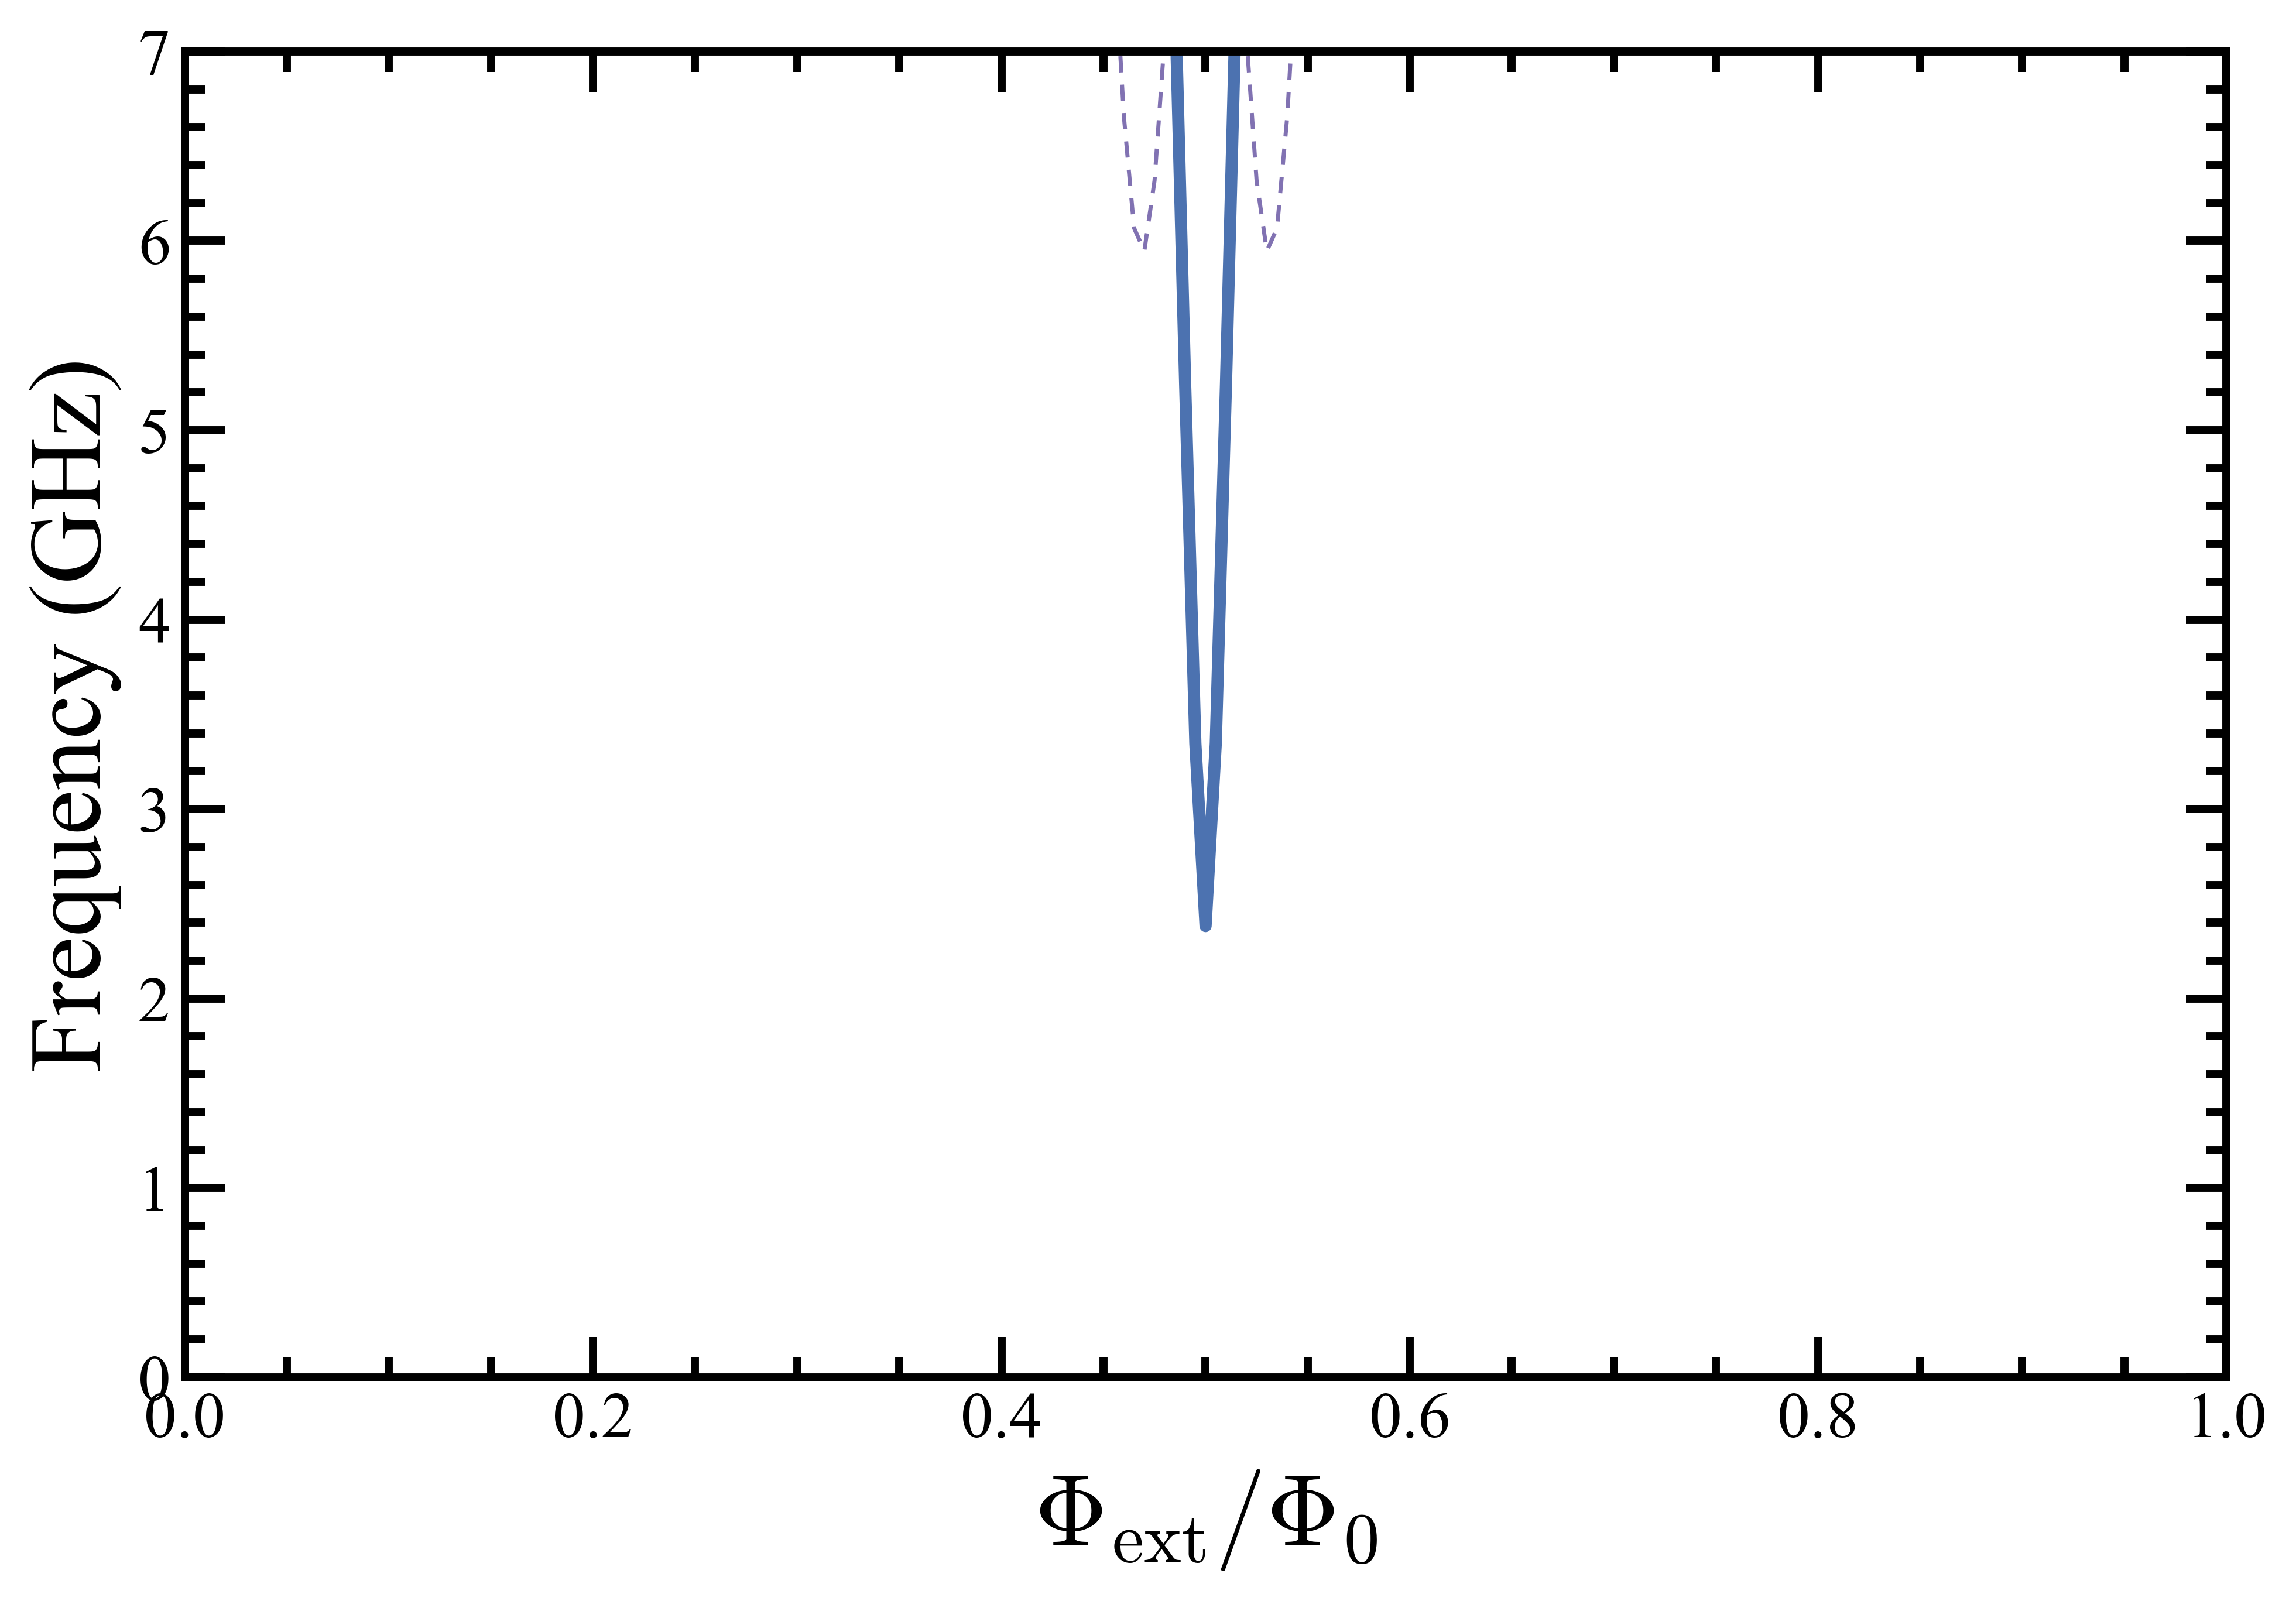

In [379]:
mpl.rcParams['figure.dpi']= 500
plt.figure(figsize=[9,6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num):
    plt.plot(phi_ext, energies[:,idx]-energies[:,0], linewidth = '3')
for idx in range(2,level_num):
    plt.plot(phi_ext, energies[:,idx]-energies[:,1], linewidth = '1', linestyle = '--')
plt.ylim([0,7])
# plt.axhline(y=7.5,linestyle = '--', color = 'orange')
print (energies[101,3]-energies[101,0])

## Wave functions
Below we plot the wave functions $|\psi_i(\phi)\rangle$ of state $i$ in the phase basis. Note that we computed the eigenfunctions above in the harmonic oscillator basis, so now we have to transform them to the phase basis. We follow the formula (for instance, as given in Sakurai's Modern Quantum Machanics), 
$$\langle b^{(k)}|\psi\rangle = \sum_l \langle b^{(k)}|a^{(l)}\rangle \langle a^{(l)}|\psi\rangle = \sum_l c_a \langle a^{(l)}|\psi\rangle,$$
where $\langle a^{(l)}|\psi\rangle$ are the eigenfunctions computed, and $c_a = \langle b^{(k)}|a^{(l)}\rangle$ are the coefficients we must find, which for the harmonic oscillator in the phase basis, is given as
$$ \psi^{(n)} (X) = (2^nn!)^{-1/2} \left(\frac{m\omega}{\pi\hbar}\right)^{1/4} e^{-X^2/2}H_n(X),$$
where $X=x\sqrt{m\omega/\hbar}$, and $H_n$ is the Hermite polynomial of order $n$. 

For an LC oscillator as defined via the Hamiltonian above, simply replace
$x\rightarrow \phi$, $p\rightarrow n$, $m\rightarrow 1/(8E_C)$ and $\omega \rightarrow \sqrt{8E_CE_L}$ to get $\psi^{(n)}(\phi)$

In [380]:
def ho_wf(phi,l,Ec,El):
    ratio = (8.0*Ec/El)**(0.25)
    coeff = (2.0**l*np.math.factorial(l)*np.sqrt(np.pi)*ratio)**(-0.5)
    return coeff * np.exp(-0.5*(phi/ratio)**2) * hpoly(l,phi/ratio)

toPlotNum = 5
# phi_ext=[0.5]
phi = np.linspace(-2*np.pi,2*np.pi,201)
waveFunc = np.zeros((len(phi), len(phi_ext), toPlotNum))
potential = np.zeros((len(phi), len(phi_ext)))
for phi_idx, phi_e in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N,E_L,E_C,E_J, phi_e*2*np.pi)
    evalues, evectors = H.eigenstates()
    for state_idx in range(toPlotNum):
        wFunc = np.zeros(len(phi))
        for lvl_idx in range(N):
            coeff = np.real(evectors[state_idx].full()[lvl_idx, 0])
            wFunc = wFunc + 1.5*coeff*ho_wf(phi, lvl_idx, E_C, E_L)
        waveFunc[:, phi_idx, state_idx] = wFunc + evalues[state_idx]
    potential[:,phi_idx] = 0.5*E_L*phi**2 - E_J*np.cos(phi-phi_e*2*np.pi)   
    

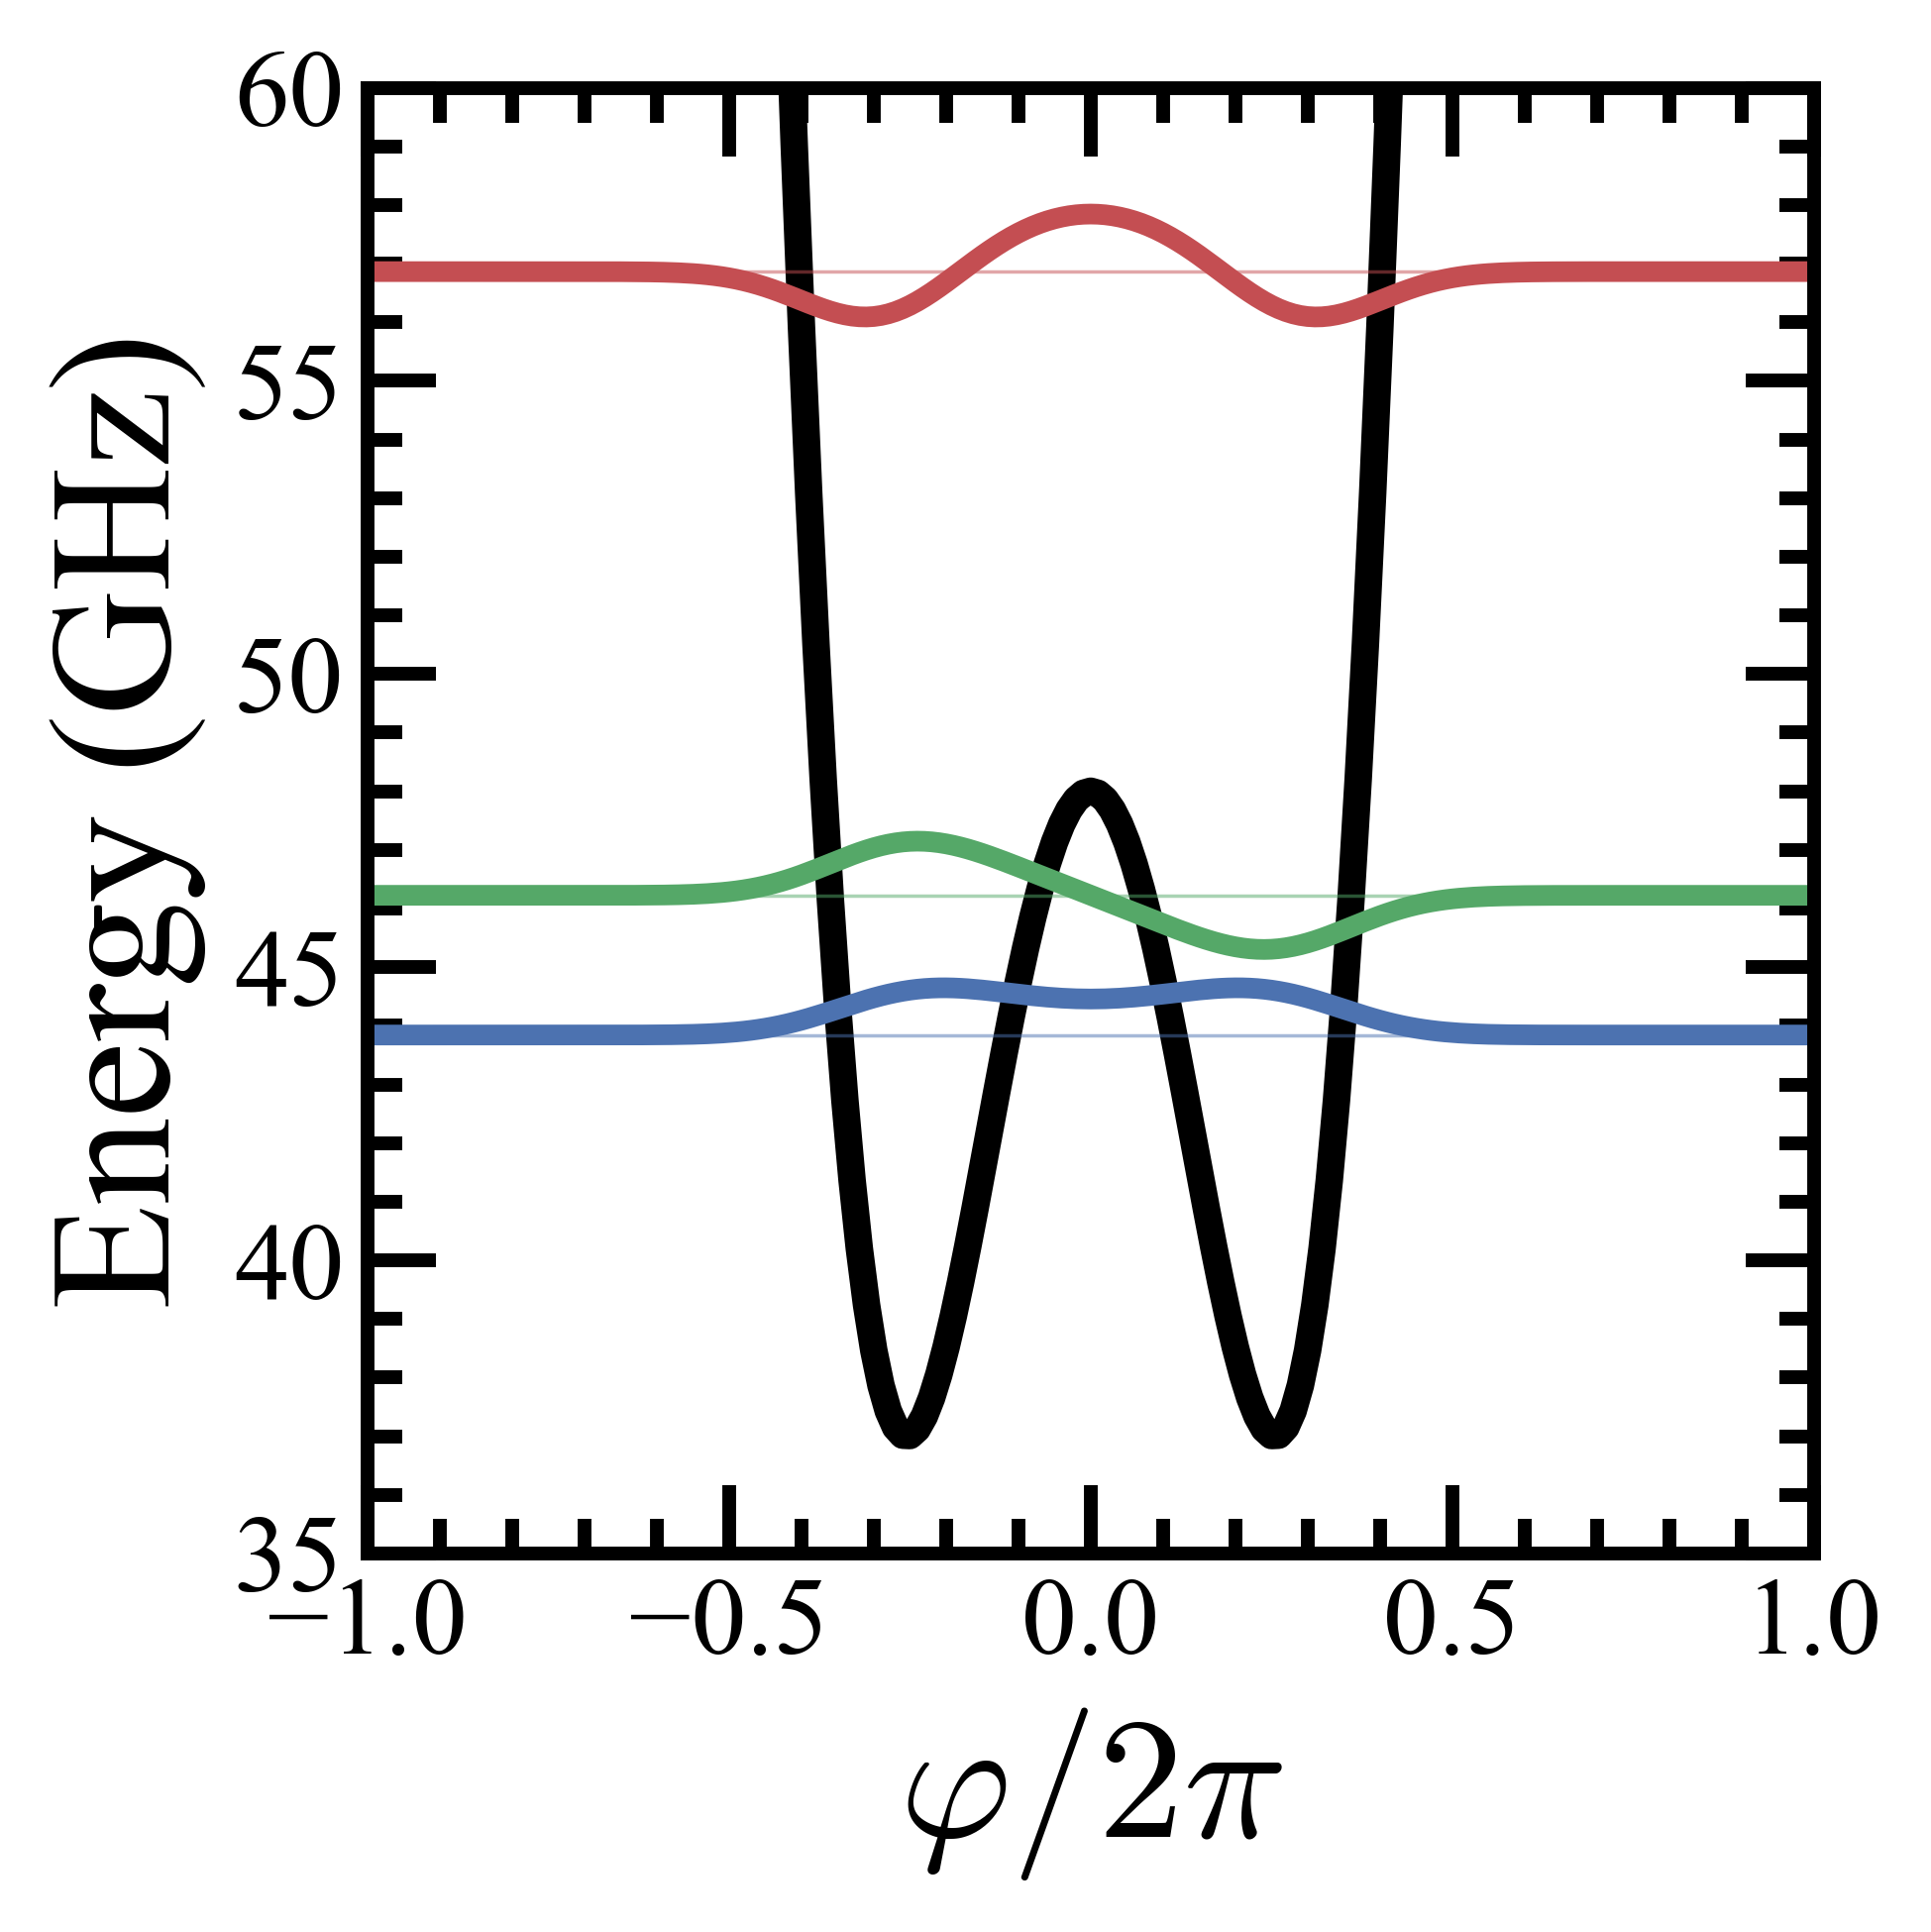

In [387]:
plt.figure(figsize = [4,4])
phi_idx = 100   
# print (phi_ext[100])
plt.plot(phi/(2*np.pi),potential[:, phi_idx], linewidth = 4, color = 'k')
for state_idx in range(toPlotNum):
    string = 'C'+str(state_idx)
    plt.plot(phi/(2*np.pi),np.ones(len(phi))*energies[phi_idx,state_idx], linewidth = 0.5, alpha = 0.5, color = string)
    plt.plot(phi/(2*np.pi),waveFunc[:, phi_idx, state_idx])
plt.ylim([35,60])
plt.xlim([phi[0]/(2*np.pi),phi[-1]/(2*np.pi)])
plt.xlabel(r'$\varphi/2\pi$')
plt.ylabel('Energy (GHz)')
plt.tight_layout()
if savefig == True:
    figname = 'flux_qubit.pdf'
    plt.savefig(figpath+figname)

In [291]:
# plt.figure(figsize = [6,6])
# phi_idx = 101
# plt.plot(phi/(2*np.pi),potential[:, phi_idx], linewidth = 5, color = 'k')
# for state_idx in range(toPlotNum):
#     plt.plot(phi/(2*np.pi),np.ones(len(phi))*energies[phi_idx,state_idx], linewidth = 1, alpha = 0.5, color = 'g')
#     plt.plot(phi/(2*np.pi),waveFunc[:, phi_idx, state_idx])
# plt.ylim([-4,8])
# plt.xlim([-2,2])
# plt.xlabel(r'$\phi/2\pi$')

## Matrix elements

In [167]:
toCompute = 10 #Number of transitions to compute
n_me = np.zeros((len(phi_ext), toCompute), dtype = complex)
p_me = np.zeros_like(n_me)

for idx, phi in enumerate(phi_ext):
    n_me[idx, 0] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    n_me[idx, 1] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)
    n_me[idx, 2] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 3)
    n_me[idx, 3] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 4)
    n_me[idx, 4] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 5)
#     n_me[idx, 5] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 6)
#     n_me[idx, 6] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 7)
#     n_me[idx, 7] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 8)
#     n_me[idx, 8] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 9)
#     n_me[idx, 9] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 10)
    
    
    p_me[idx, 0] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    p_me[idx, 1] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)
    p_me[idx, 2] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 3)
    p_me[idx, 3] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 4)
#     p_me[idx, 4] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 5)
#     p_me[idx, 5] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 6)
#     p_me[idx, 6] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 7)
#     p_me[idx, 7] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 8)
#     p_me[idx, 8] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 9)
#     p_me[idx, 9] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 10)

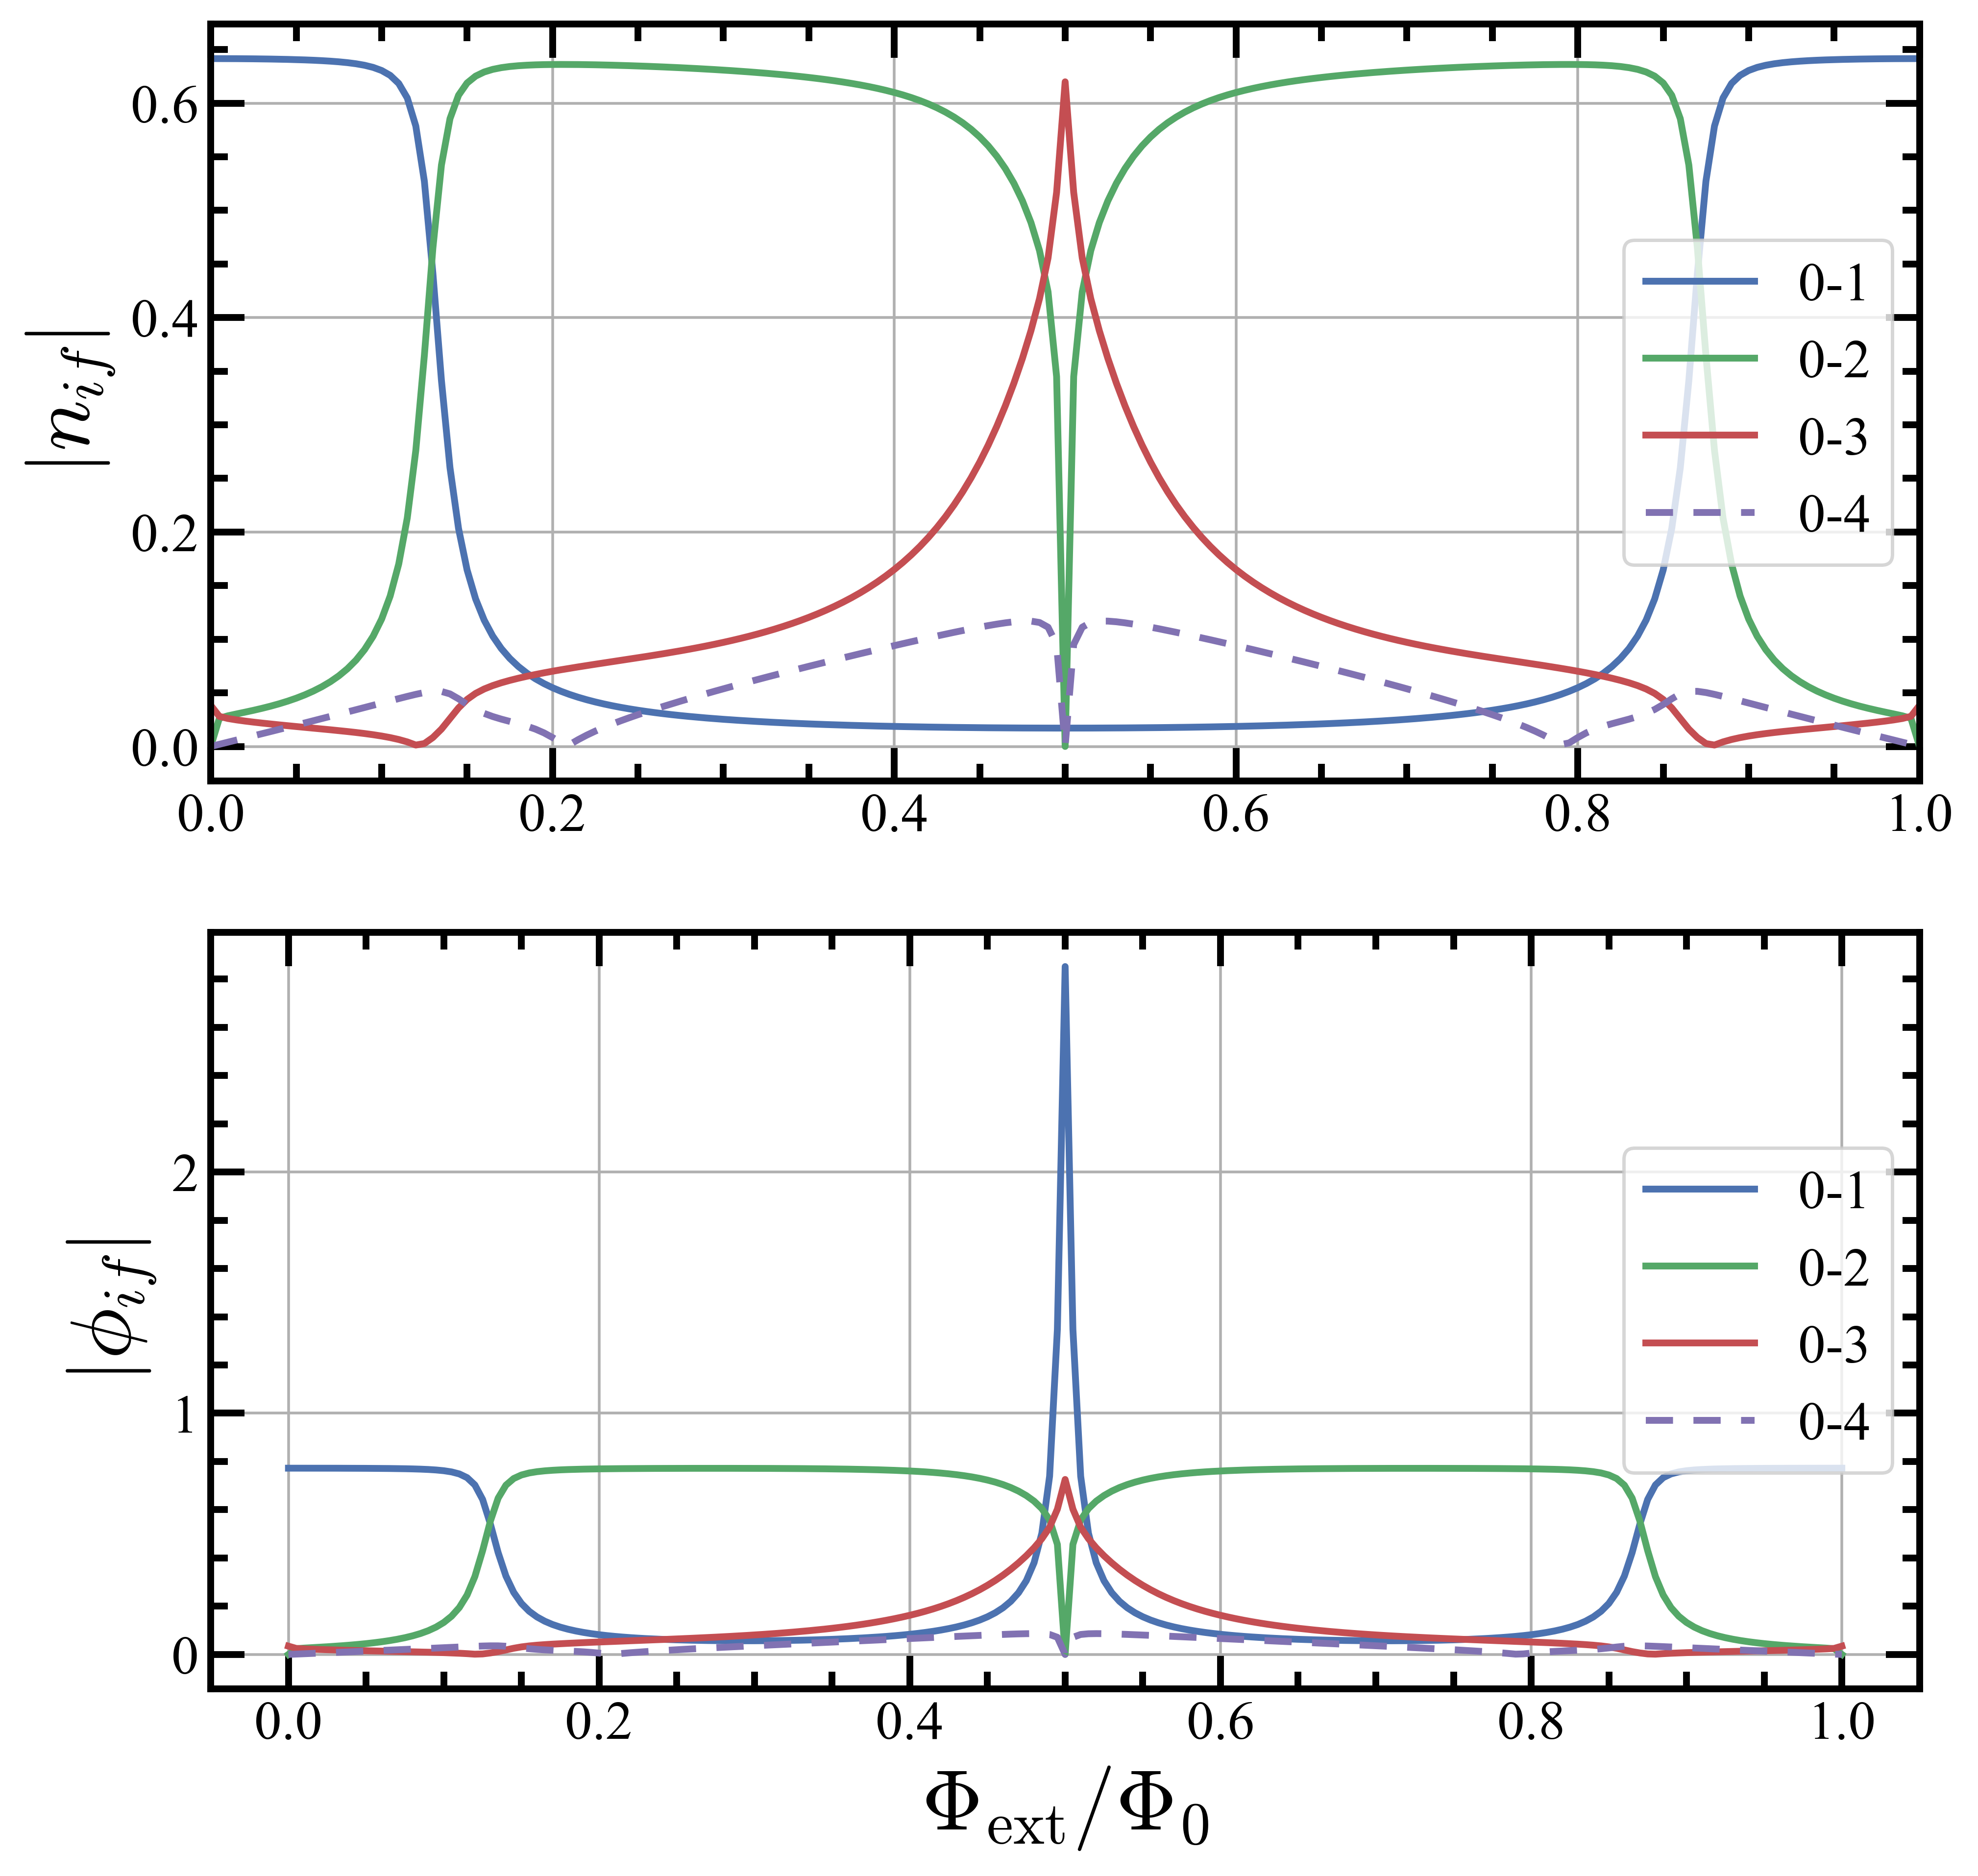

In [132]:
fig, (ax1, ax2) = plt.subplots(2, figsize=[9,9])
ax1.set_xlim([phi_ext[0], phi_ext[-1]])
ax1.set_xlim([phi_ext[0], phi_ext[-1]])
ax2.set_xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
ax1.set_ylabel(r'$|n_{if}|$')
ax2.set_ylabel(r'$|\phi_{if}|$')

ax1.plot(phi_ext, abs(n_me[:, 0]), linewidth = '2',label = "0-1", linestyle = '-')
ax1.plot(phi_ext, abs(n_me[:, 1]), linewidth = '2',label = "0-2", linestyle = '-')
ax1.plot(phi_ext, abs(n_me[:, 2]), linewidth = '2',label = "0-3", linestyle = '-')
ax1.plot(phi_ext, abs(n_me[:, 3]), linewidth = '2',label = "0-4", linestyle = '--')
# ax1.plot(phi_ext, abs(n_me[:, 4]), linewidth = '2',label = "0-5", linestyle = '-')
# ax1.plot(phi_ext, abs(n_me[:, 5]), linewidth = '2',label = "0-6", linestyle = '-')
# ax1.plot(phi_ext, abs(n_me[:, 6]), linewidth = '2',label = "0-7", linestyle = '-')
# ax1.plot(phi_ext, abs(n_me[:, 7]), linewidth = '2',label = "0-8", linestyle = '-')
# ax1.plot(phi_ext, abs(n_me[:, 8]), linewidth = '2',label = "0-9", linestyle = '-')
# ax1.plot(phi_ext, abs(n_me[:, 9]), linewidth = '2',label = "0-10", linestyle = '-')
    
ax2.plot(phi_ext, abs(p_me[:, 0]), linewidth = '2',label = "0-1", linestyle = '-')
ax2.plot(phi_ext, abs(p_me[:, 1]), linewidth = '2',label = "0-2", linestyle = '-')
ax2.plot(phi_ext, abs(p_me[:, 2]), linewidth = '2',label = "0-3", linestyle = '-')
ax2.plot(phi_ext, abs(p_me[:, 3]), linewidth = '2',label = "0-4", linestyle = '--')
# ax2.plot(phi_ext, abs(p_me[:, 4]), linewidth = '2',label = "0-5", linestyle = '-')
# ax2.plot(phi_ext, abs(p_me[:, 5]), linewidth = '2',label = "0-6", linestyle = '-')
# ax2.plot(phi_ext, abs(p_me[:, 6]), linewidth = '2',label = "0-7", linestyle = '-')
# ax2.plot(phi_ext, abs(p_me[:, 7]), linewidth = '2',label = "0-8", linestyle = '-')
# ax2.plot(phi_ext, abs(p_me[:, 8]), linewidth = '2',label = "0-9", linestyle = '-')
# ax2.plot(phi_ext, abs(p_me[:, 9]), linewidth = '2',label = "0-10", linestyle = '-')

ax1.legend(loc='best')
ax1.grid('minor')
ax2.legend(loc='right')
ax2.grid('minor')


## Explore specific matrix elements

In [176]:
toCompute = 10 #Number of transitions to compute
n_me = np.zeros((len(phi_ext), toCompute), dtype = complex)
p_me = np.zeros_like(n_me)

for idx, phi in enumerate(phi_ext):
    n_me[idx, 0] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    n_me[idx, 1] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)
    n_me[idx, 2] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 3)
    n_me[idx, 3] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 1, 2)
    n_me[idx, 4] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 1, 3)
    
    p_me[idx, 0] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    p_me[idx, 1] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)
    p_me[idx, 2] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 3)
    p_me[idx, 3] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 1, 2)
    p_me[idx, 4] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 1, 3)


(0.0, 2.0)

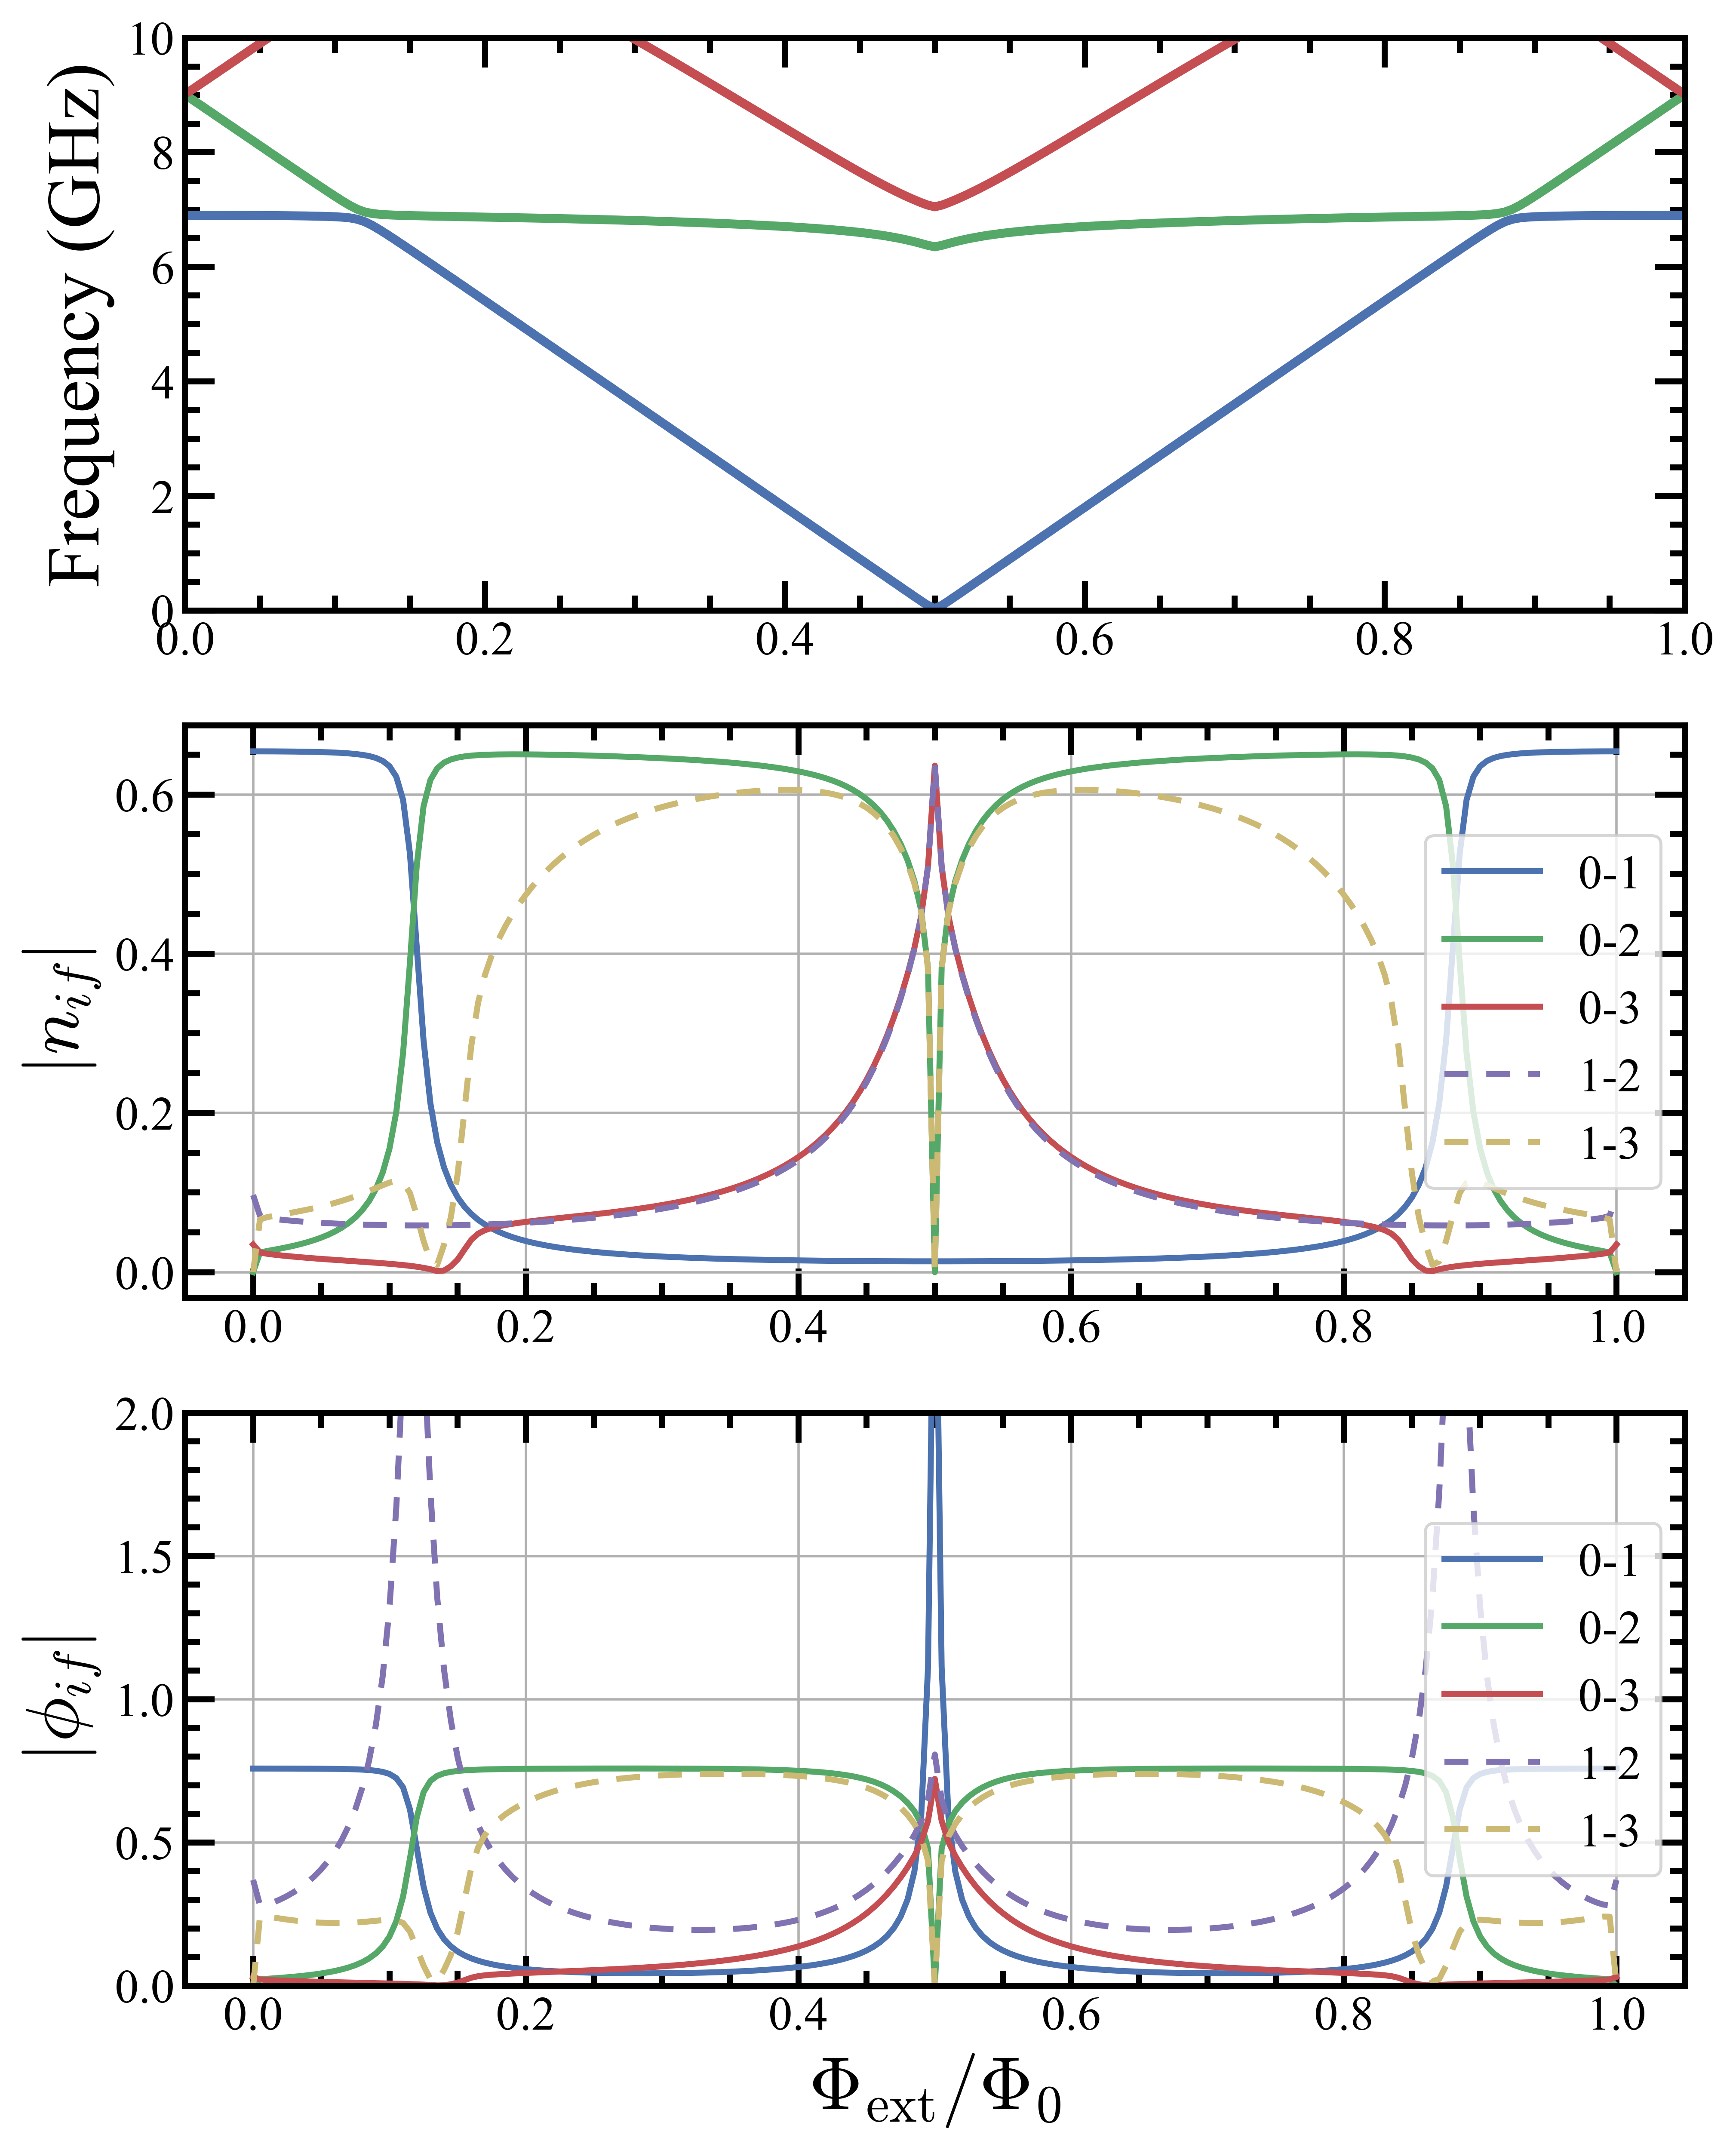

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=[9,12])
ax1.set_xlim([phi_ext[0], phi_ext[-1]])
ax1.set_xlim([phi_ext[0], phi_ext[-1]])
ax3.set_xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
ax2.set_ylabel(r'$|n_{if}|$')
ax3.set_ylabel(r'$|\phi_{if}|$')
ax1.set_ylabel('Frequency (GHz)')

for idx in range(1,level_num):
    ax1.plot(phi_ext, energies[:,idx]-energies[:,0], linewidth = '3')
    
ax2.plot(phi_ext, abs(n_me[:, 0]), linewidth = '2',label = "0-1", linestyle = '-')
ax2.plot(phi_ext, abs(n_me[:, 1]), linewidth = '2',label = "0-2", linestyle = '-')
ax2.plot(phi_ext, abs(n_me[:, 2]), linewidth = '2',label = "0-3", linestyle = '-')
ax2.plot(phi_ext, abs(n_me[:, 3]), linewidth = '2',label = "1-2", linestyle = '--')
ax2.plot(phi_ext, abs(n_me[:, 4]), linewidth = '2',label = "1-3", linestyle = '--')
    
ax3.plot(phi_ext, abs(p_me[:, 0]), linewidth = '2',label = "0-1", linestyle = '-')
ax3.plot(phi_ext, abs(p_me[:, 1]), linewidth = '2',label = "0-2", linestyle = '-')
ax3.plot(phi_ext, abs(p_me[:, 2]), linewidth = '2',label = "0-3", linestyle = '-')
ax3.plot(phi_ext, abs(p_me[:, 3]), linewidth = '2',label = "1-2", linestyle = '--')
ax3.plot(phi_ext, abs(p_me[:, 4]), linewidth = '2',label = "1-3", linestyle = '--')

ax1.set_ylim([0,10])
ax2.legend(loc='best')
ax2.grid('minor')
ax3.legend(loc='right')
ax3.grid('minor')
ax3.set_ylim([0,2])

## Dispersive shifts 
The dispersive shift between levels $i$ and $j$ of a  fluxonium circuit coupled capacitively to a resonator is written as
$$\chi_{ij} = g^2\left( \sum_{k\neq i}|n_{ik}|^2\frac{2f_{ik}}{f_{ik}^2-f_r^2} - \sum_{k\neq j}|n_{jk}|^2\frac{2f_{jk}}{f_{jk}^2-f_r^2}\right),$$
where $g$ is the qubit-cavity coupling constant, $n_{ik}$ is the charge matrix element between states $i$ and $k$, $f_{ik}$ is the transition frequency between those states, and $f_r$ is the cavity frequency. Note that the dispersive shift $\chi$ has the same unit as the coupling $g$. For inductive coupling, we can simply replace $n$ with $\phi$

Let's now simulate the $0-1$ dispersive shift at different flux bias for fixed cavity resonance and coupling coefficient.

In [139]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R = 7.5 #Readout frequency, GHz
chi_01 = np.zeros_like(phi_ext)
for idx, phi in enumerate(phi_ext):
    chi_01[idx]= fluxonium.charge_dispersive_shift(N, level_num, E_L, E_C, E_J, phi*2*np.pi, iState, fState, w_R, g)

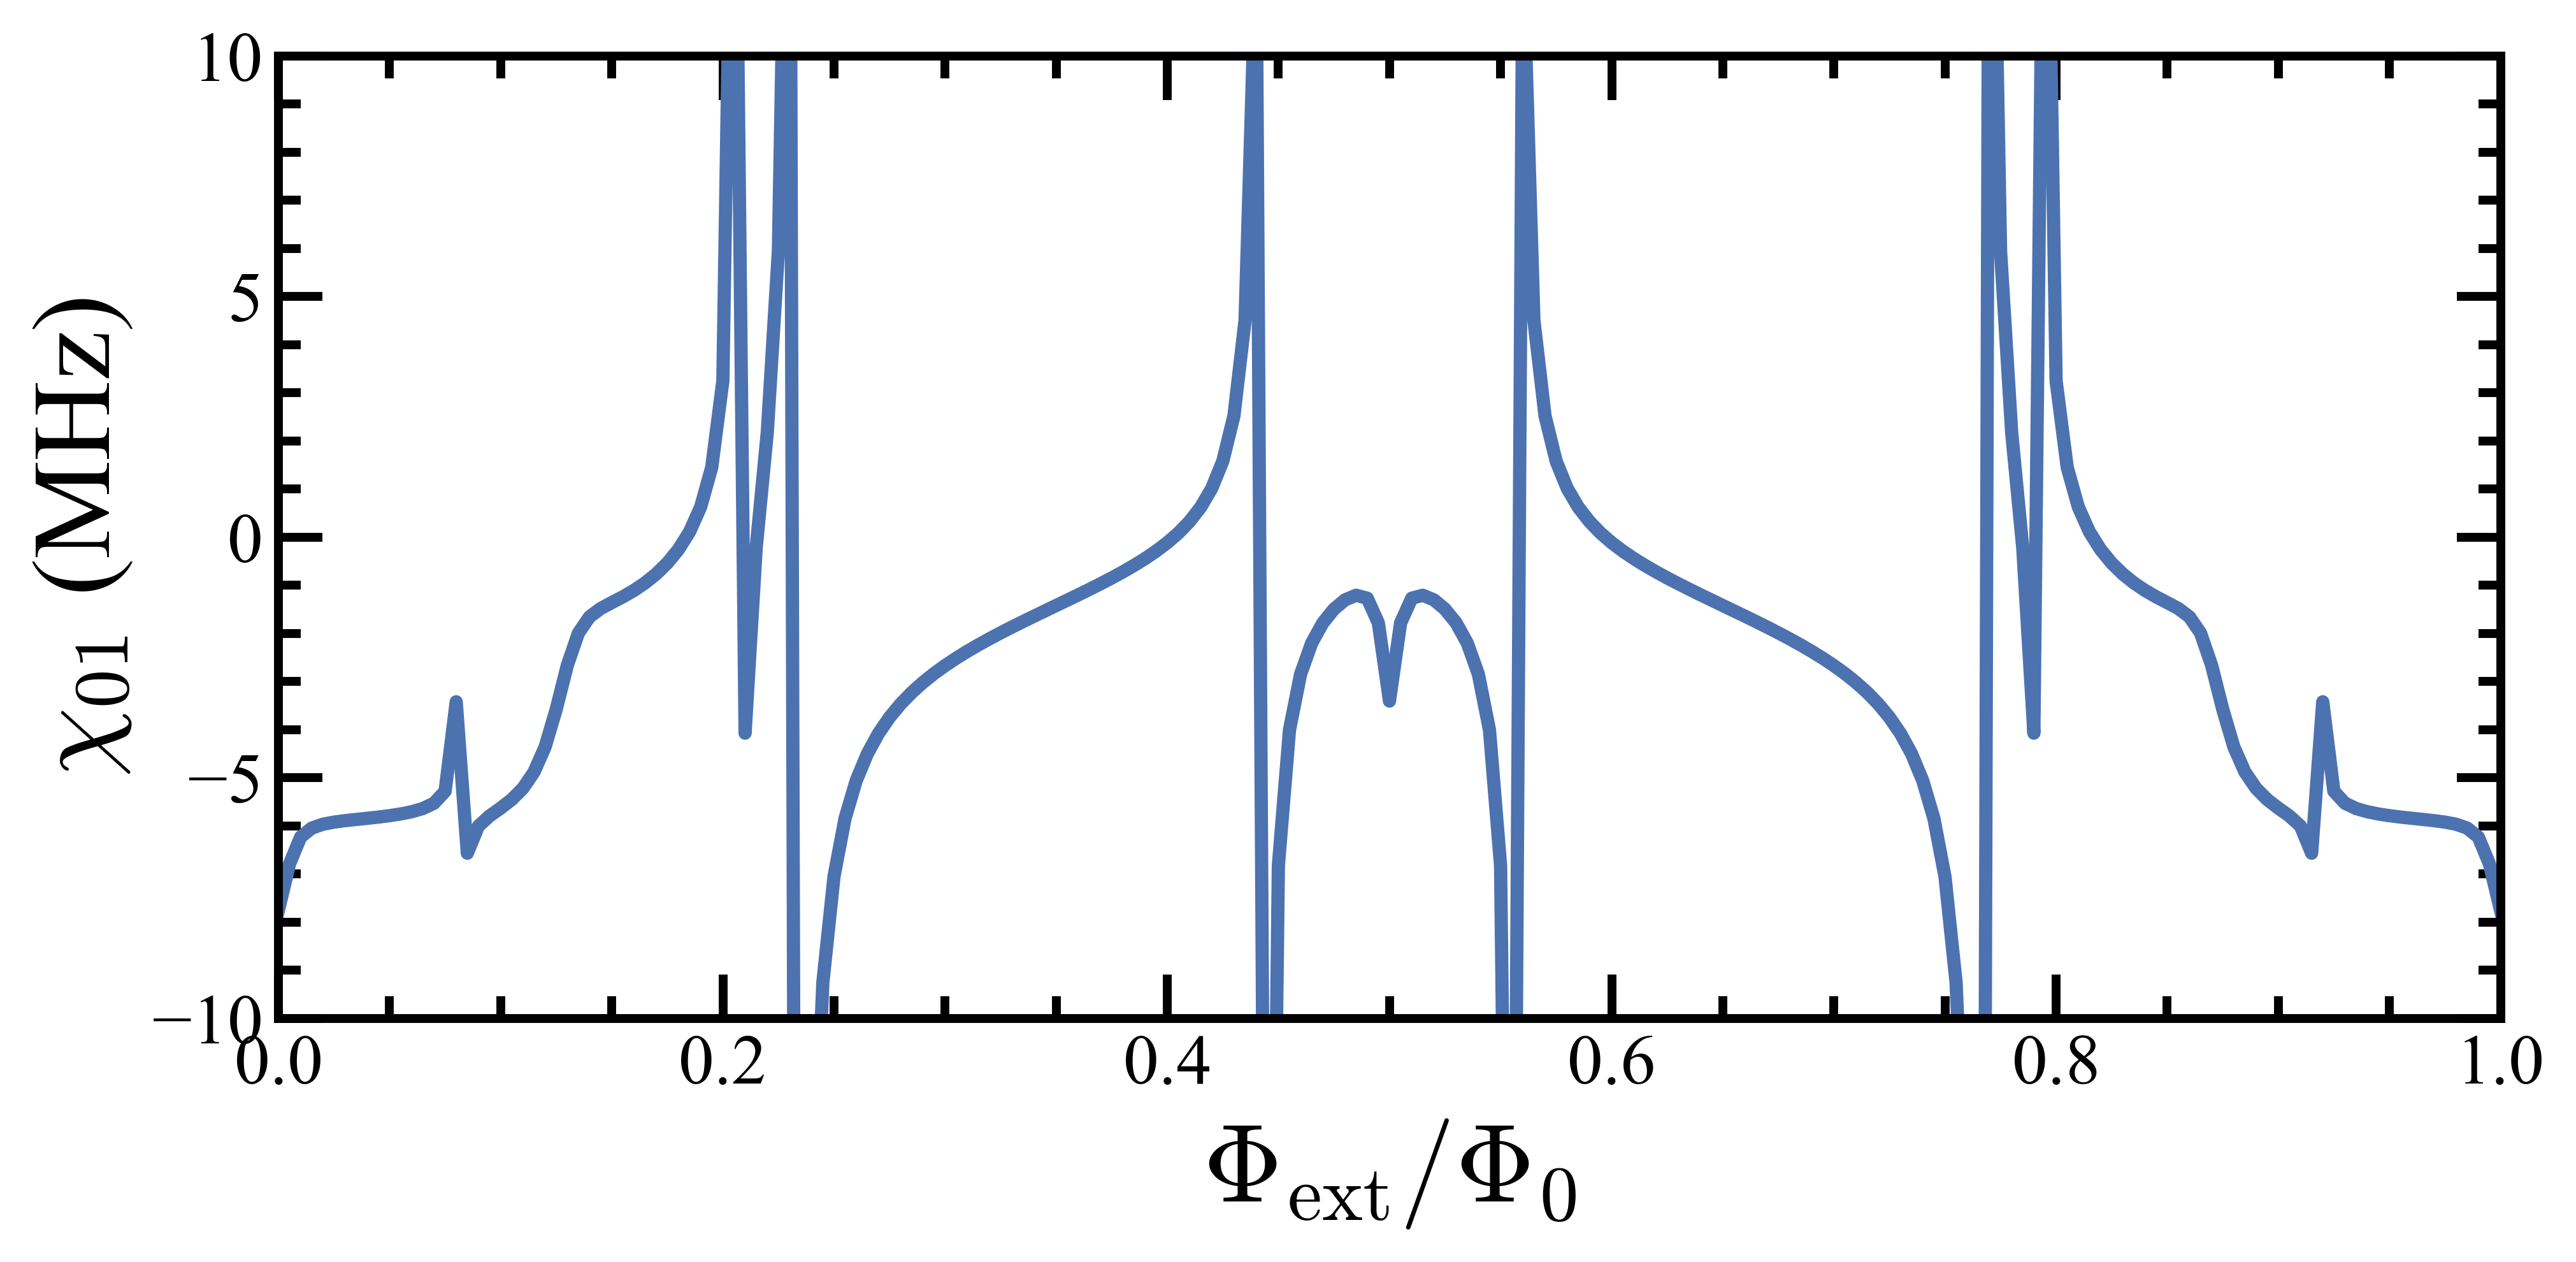

In [141]:
plt.figure(figsize=[9,4])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([-10,10])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(phi_ext, chi_01*1e3, linewidth = 3)

We can simulate dispersive shift with varying resonator frequency to find the optimal readout design

In [91]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R_array = np.linspace(4,10,101) #Readout frequency, GHz
chi_R_01 = np.zeros_like(w_R_array)
for idx, w_R in enumerate(w_R_array):
    chi_R_01[idx]= fluxonium.charge_dispersive_shift(N, level_num, E_L, E_C, E_J, np.pi, iState, fState, w_R, g)

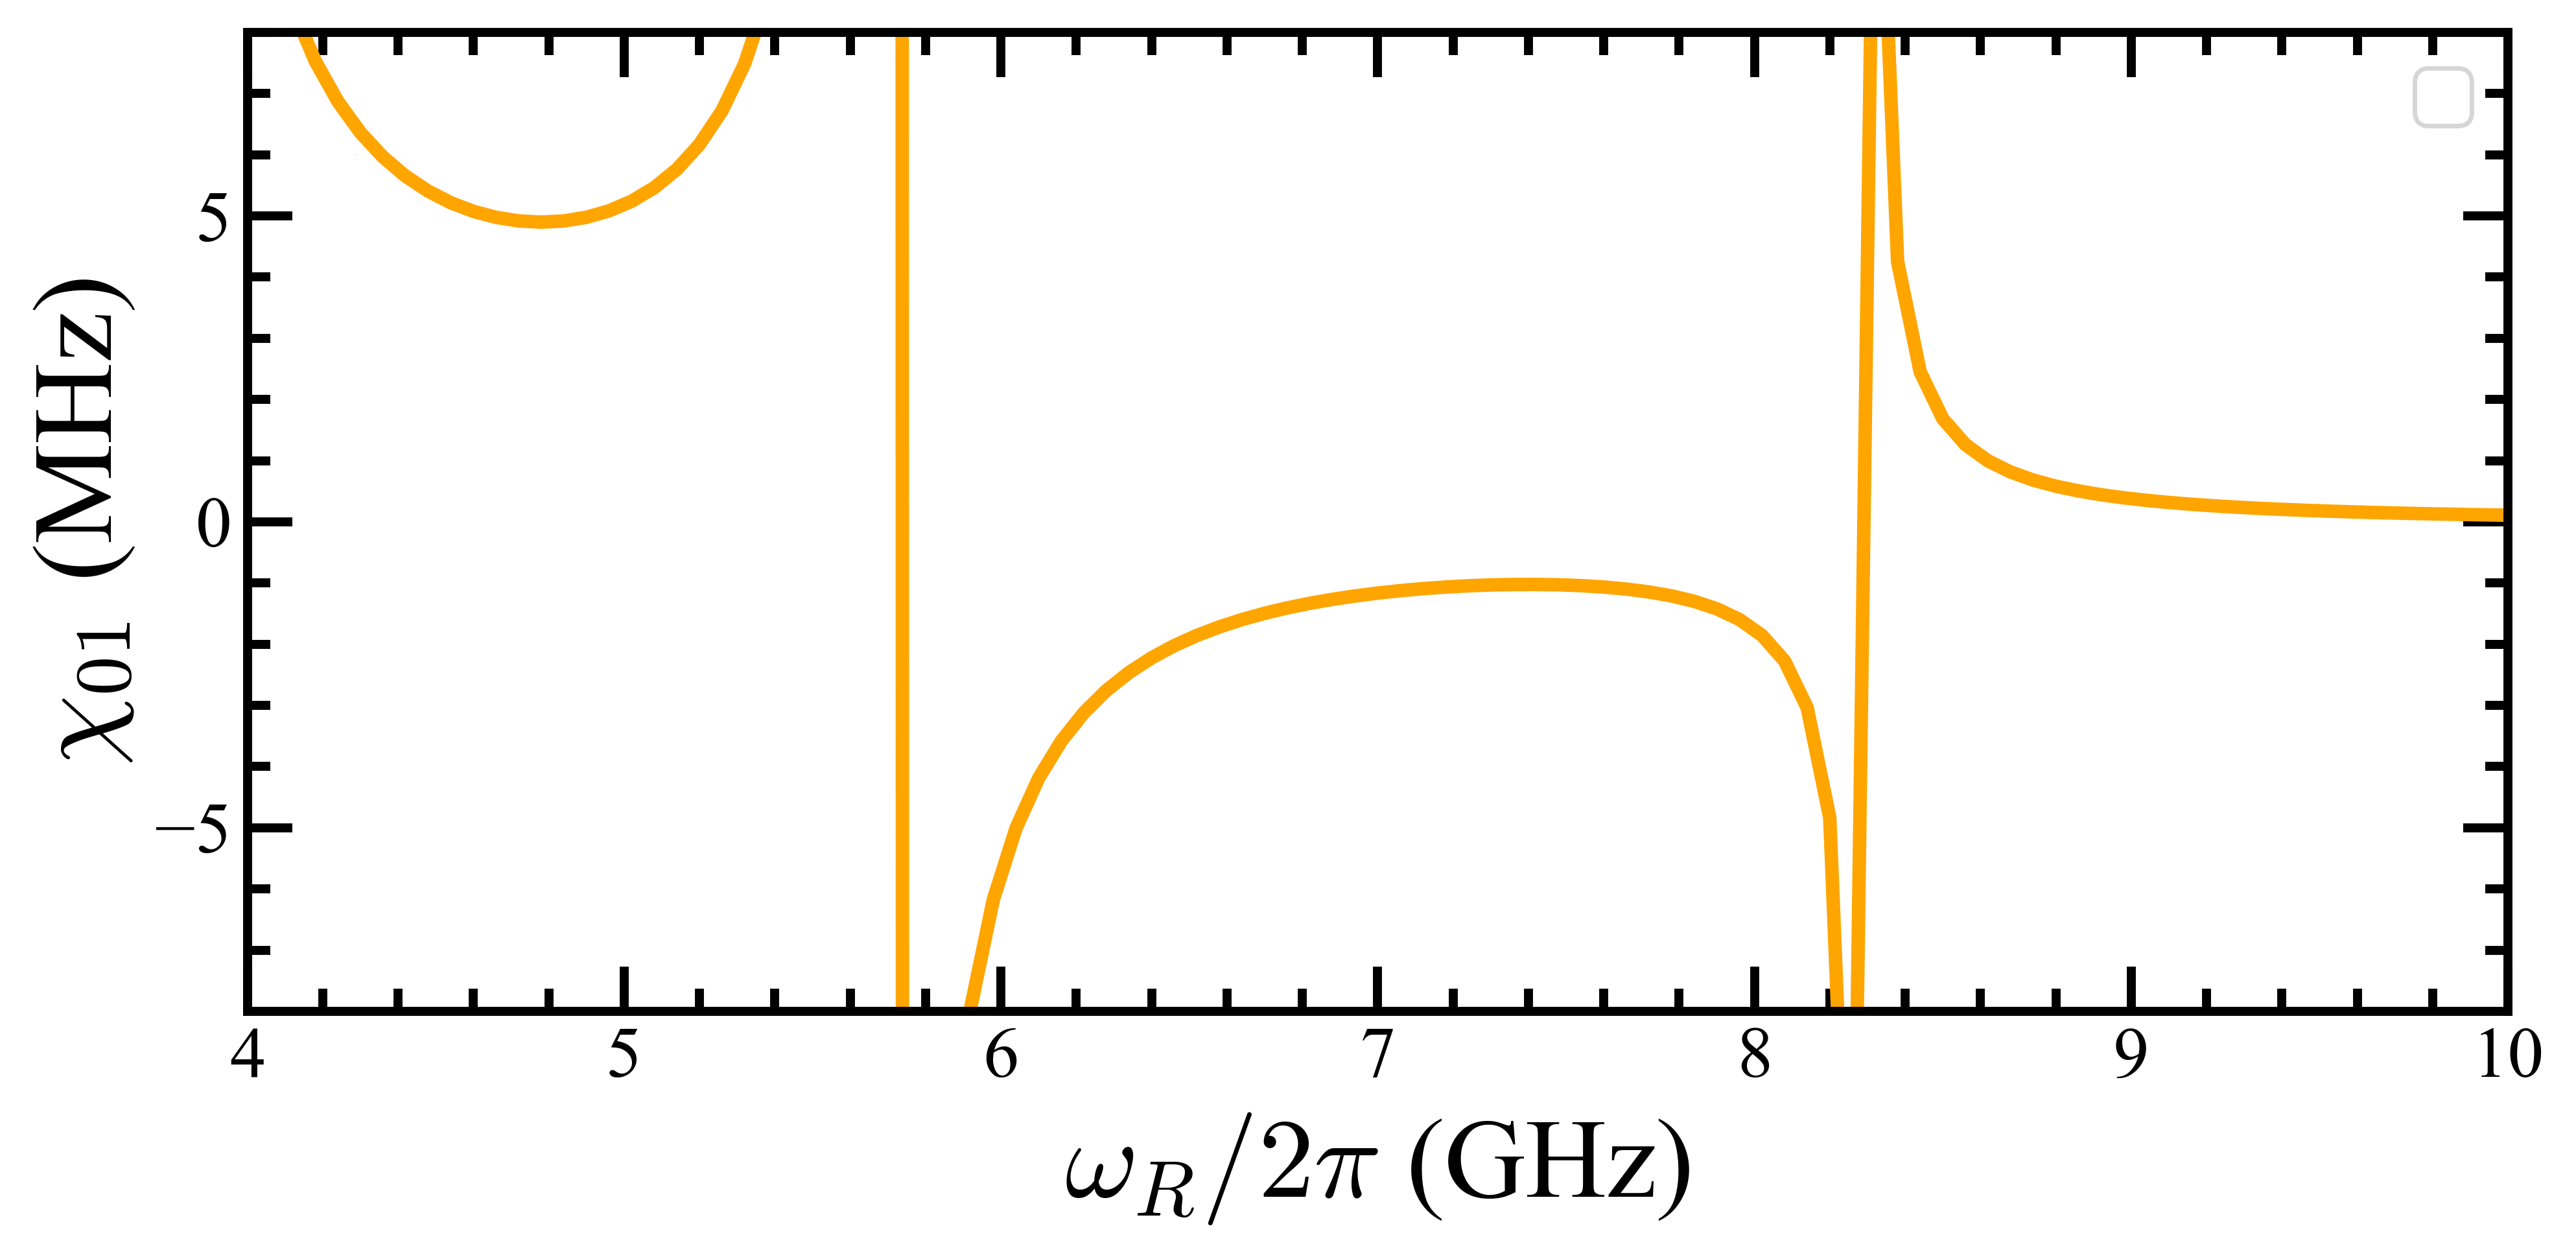

In [92]:
plt.figure(figsize=[9,4])
plt.xlim([w_R_array[0], w_R_array[-1]])
plt.ylim([-8,8])
plt.xlabel(r'$\omega_R/2\pi$ (GHz)')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(w_R_array, chi_R_01*1e3, linewidth = 3, color = 'orange')
# plt.axvline(x=5.45,linestyle = '--', color = 'red', label =r'$\omega_{03}/2\pi$')
plt.legend()

We can repeat the computation process with inductive coupling.

In [16]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R = 7.5 #Readout frequency, GHz
chi_01 = np.zeros_like(phi_ext)
for idx, phi in enumerate(phi_ext):
    chi_01[idx]= fluxonium.flux_dispersive_shift(N, level_num, E_L, E_C, E_J, phi*2*np.pi, iState, fState, w_R, g)

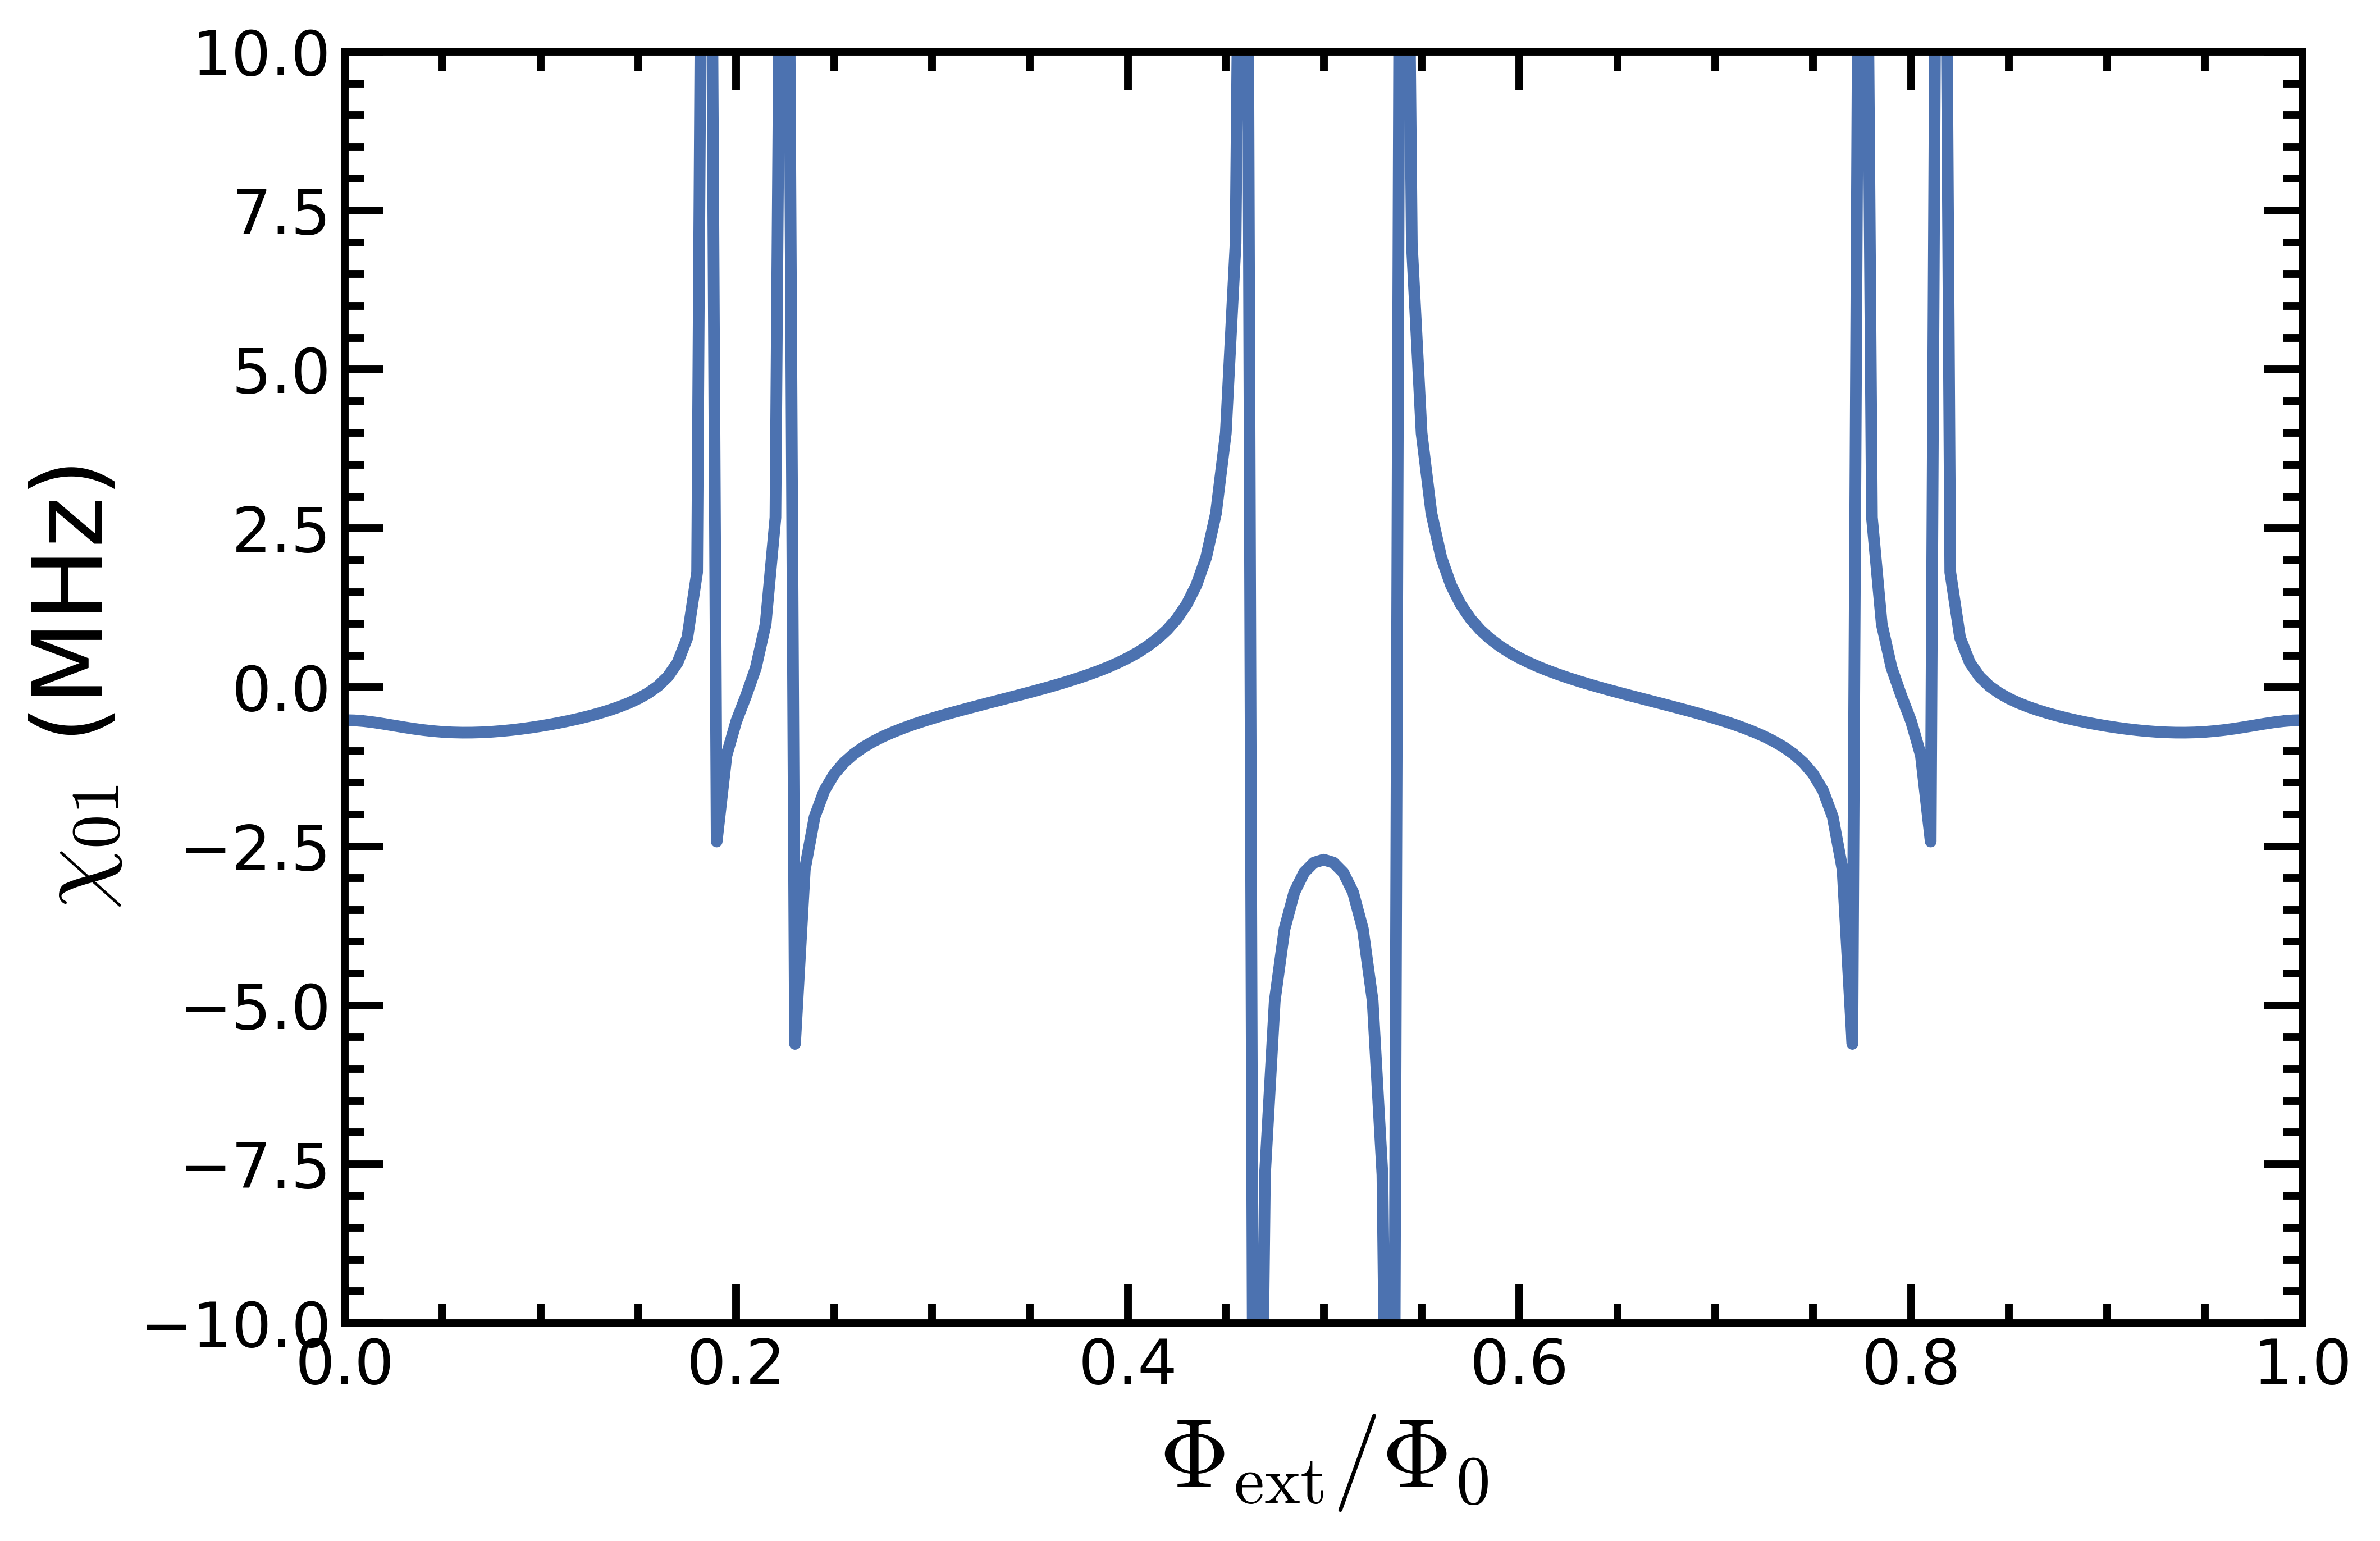

In [17]:
plt.figure(figsize=[9,6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([-10,10])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(phi_ext, chi_01*1e3, linewidth = 3)

In [98]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R_array = np.linspace(4,10,101) #Readout frequency, GHz
chi_R_01 = np.zeros_like(w_R_array)
for idx, w_R in enumerate(w_R_array):
    chi_R_01[idx]= fluxonium.flux_dispersive_shift(N, level_num, E_L, E_C, E_J, np.pi, iState, fState, w_R, g)

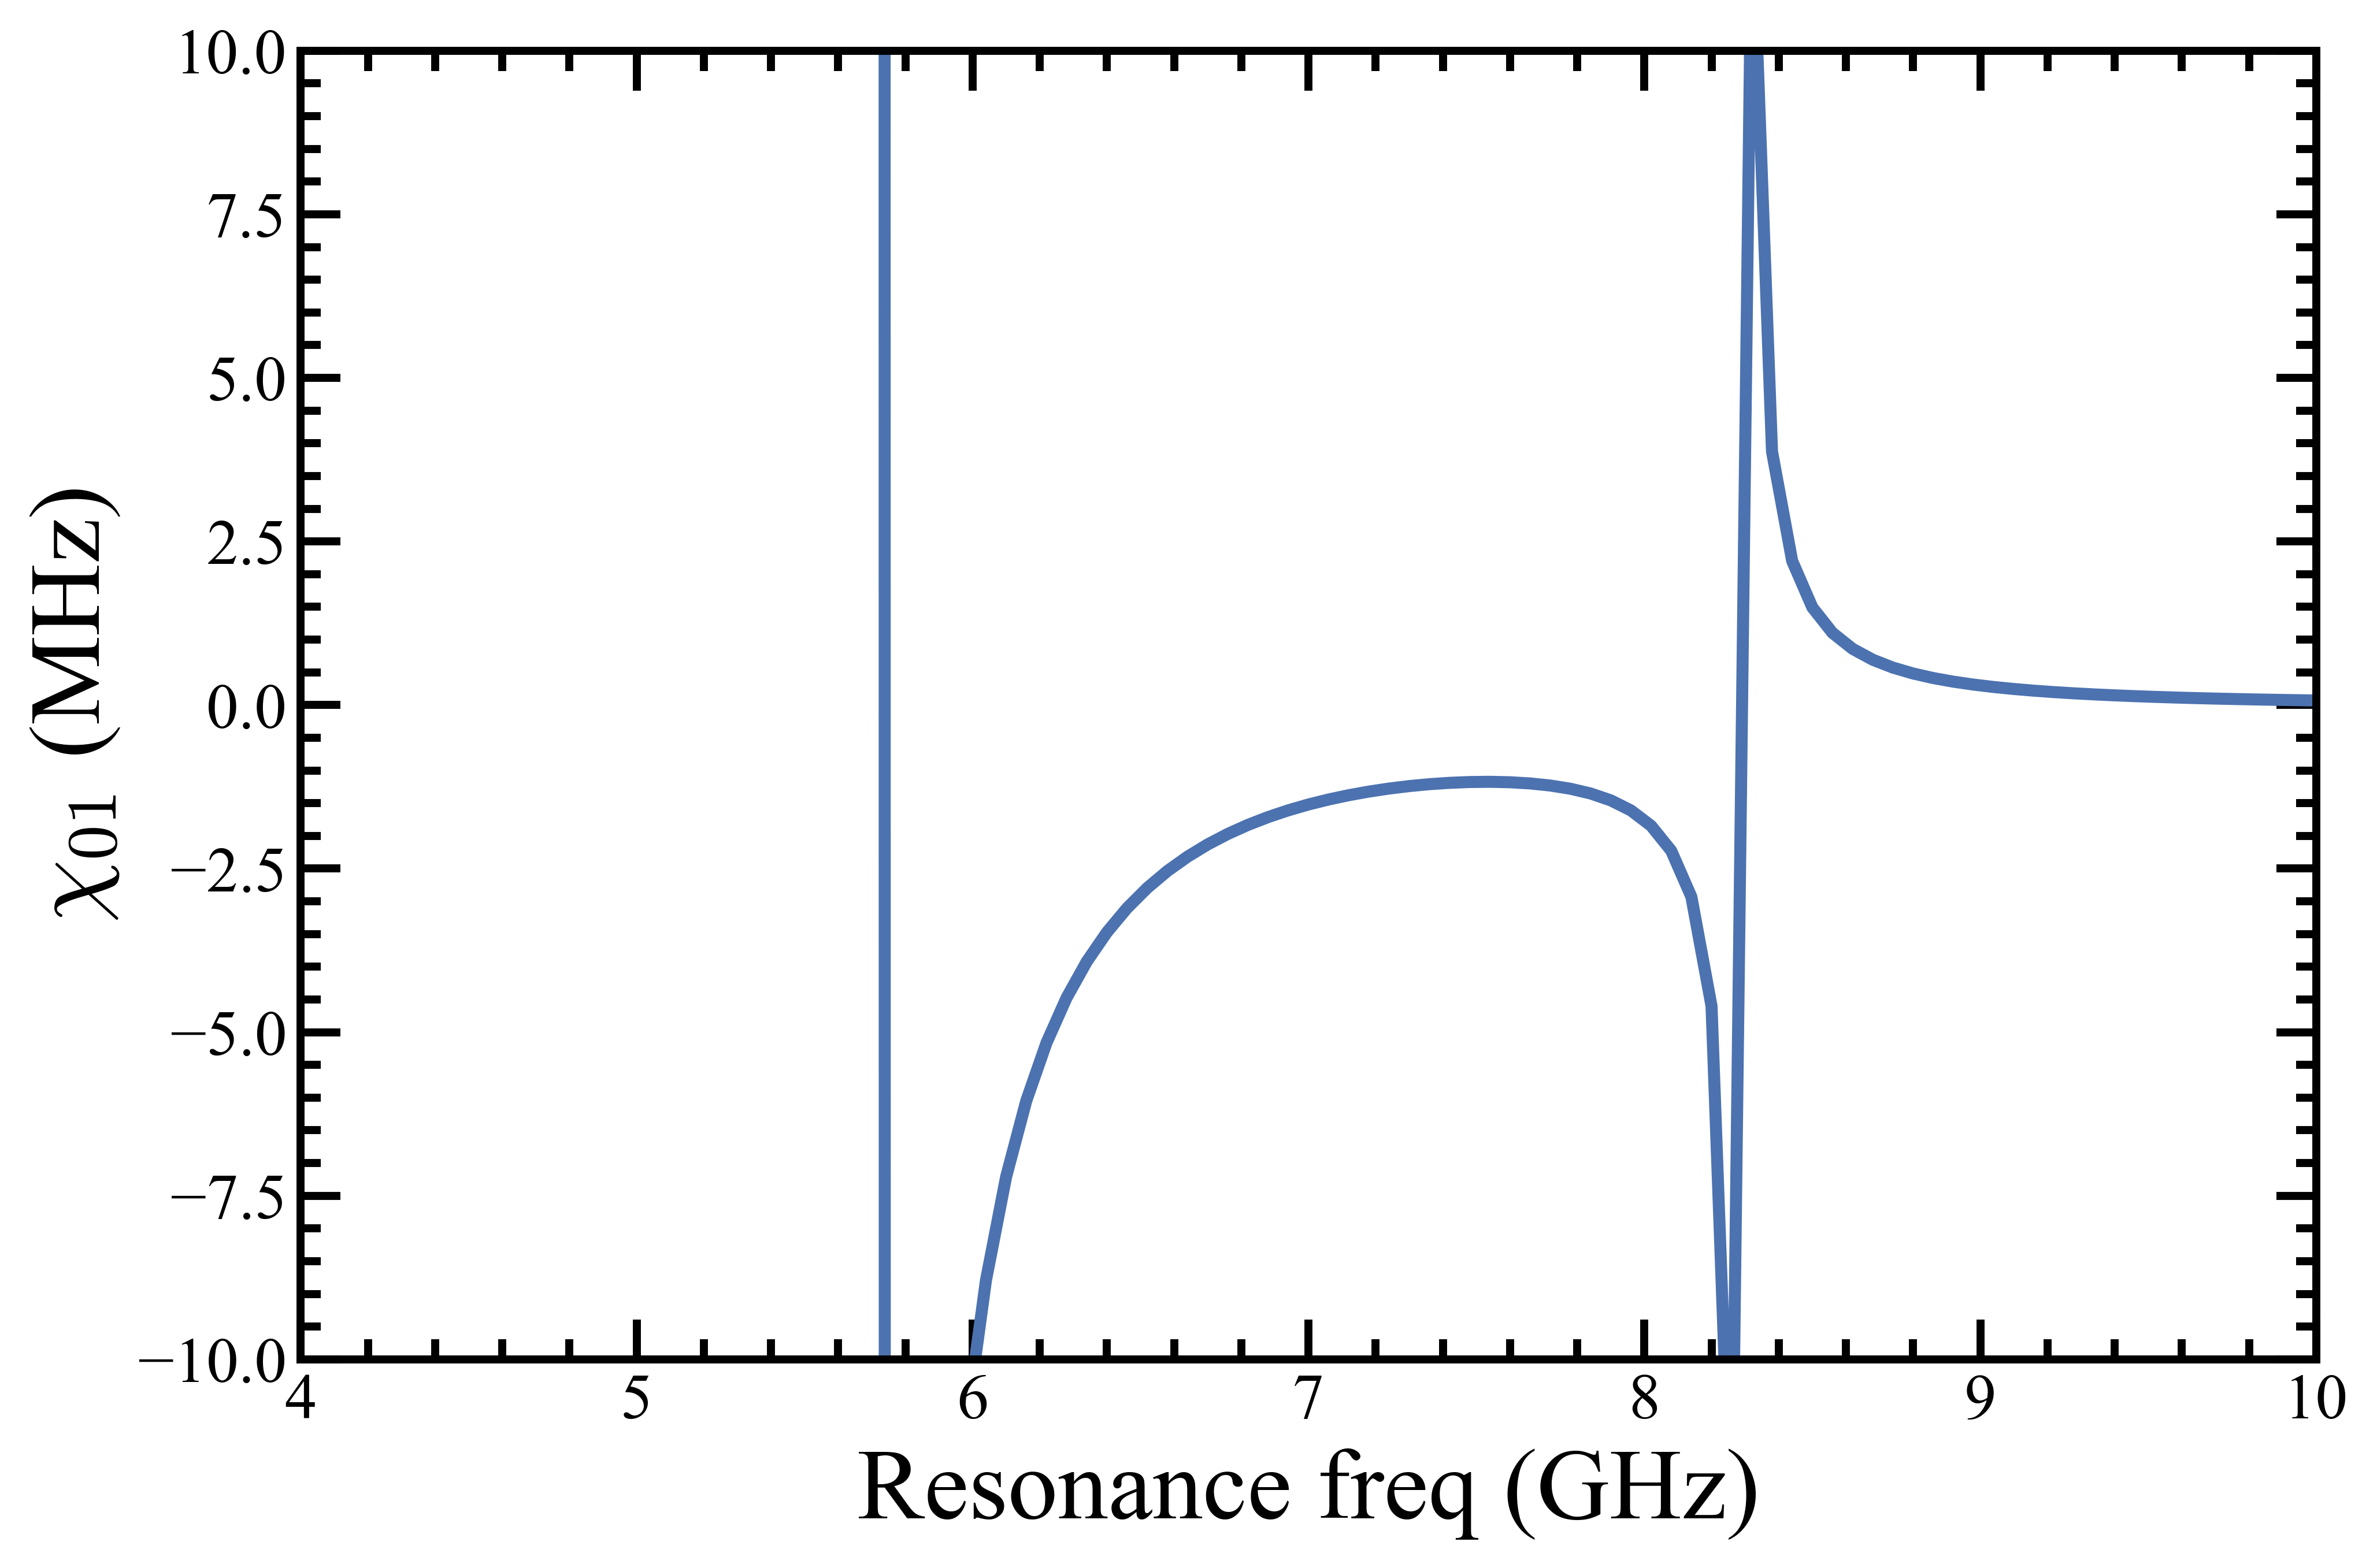

In [99]:
plt.figure(figsize=[9,6])
plt.xlim([w_R_array[0], w_R_array[-1]])
plt.ylim([-10,10])
plt.xlabel(r'Resonance freq (GHz)')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(w_R_array, chi_R_01*1e3, linewidth = 3)

## Energy relaxation
We can use Fermi's golden rule ro estimate relaxation time $T_1$. The transition rate from state $i$ to state $j$ of a quantum system coupled to a noisy environment $\alpha$ follows
$$\Gamma^\alpha_{ij} = \frac{1}{\hbar^2}|\langle j| \hat{O}|i \rangle|^2 S_\alpha(\omega_{ij}),$$
where the noise spectral density $S_\alpha(\omega_{ij})$ describes the environment at frequency $\omega_{ij}$. If we model the noise source as a complex shunting admittance $\mathrm{Y_\alpha(\omega)}$, then the relevant operator is flux, $O \equiv \Phi=\phi_o\phi$, and the noise spectral density is given as 
$$S^\alpha(\omega) = \hbar \omega \mathrm{Re [Y_\alpha]}\left[ \coth \left(\frac{\hbar \omega}{2k_BT} \right) +1 \right]$$

### Dielectric loss
For dielectric loss, we can model the shunting capacitance as having an imaginary part, $C\rightarrow C+iC'$, from which the loss tangent is defined, $\tan {\delta_C} = C' / C \equiv 1/Q_\mathrm{diel}$. The capacitance becomes $C_\mathrm{eff} = C(1+i\tan \delta_C)$, and the admittance becomes $Y_\mathrm{diel} = i\omega C(1+i\tan \delta_C)$, giving
$$\mathrm{Re Y_{diel}} = \frac{\omega C}{Q_\mathrm{diel}}.$$

The decay rate from $i$ to $j$ due to dielectric loss at temperature $T$ is then 
$$\Gamma^\mathrm{diel}_{ij} = \frac{1}{\hbar^2}|\phi_o\langle j| \phi|i \rangle|^2 \frac{\omega_{ij}^2 C}{Q_\mathrm{diel}}\left[ \coth \left(\frac{\hbar \omega}{2k_BT} \right) +1 \right].$$
Note that the effective relaxation rate that we measure is $\Gamma_1 = \Gamma_{ij} + \Gamma_{ji} = \Gamma_{ij} (1+e^{\frac{-\hbar\omega_{ij}}{ k_BT}})$. At $T=0~K$, the stimulated emission effect and the excitation rate are negligible. However, for fluxonium where the transition frequency can be comparable to the temperature of the base plate, these effects must be taken into account.

In [168]:
freq = energies[:,1]-energies[:,0]
h = 6.626e-34 #Planck constant
kB = 1.38e-23 #Boltzmann constant
T_diel = 20e-3 #effective temperature in K
thermal_factor_diel = (1+np.exp(-h*freq*1e9/(kB*T_diel)))
#What is Q of transmon?
Q = 2*np.pi*6e9*(100e-6)
print (Q/1e6)
Q_cap_array = [3e6]
gamma_cap  = np.zeros((len(phi_ext), len(Q_cap_array)), dtype = float)

for Q_idx, Q_cap in enumerate(Q_cap_array):
    for phi_idx in range(len(phi_ext)):
        gamma_cap[phi_idx, Q_idx] = fluxonium.relaxation_rate_cap(E_L, E_C, E_J, Q_cap*(6.0/freq[phi_idx])**0.15, 
                                                                  freq[phi_idx], p_me[phi_idx,0], T_diel)*thermal_factor_diel[phi_idx]

3.7699111843077517


<ipython-input-168-9d1e4b3a71e9>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  gamma_cap[phi_idx, Q_idx] = fluxonium.relaxation_rate_cap(E_L, E_C, E_J, Q_cap*(6.0/freq[phi_idx])**0.15,


(100, 100000.0)

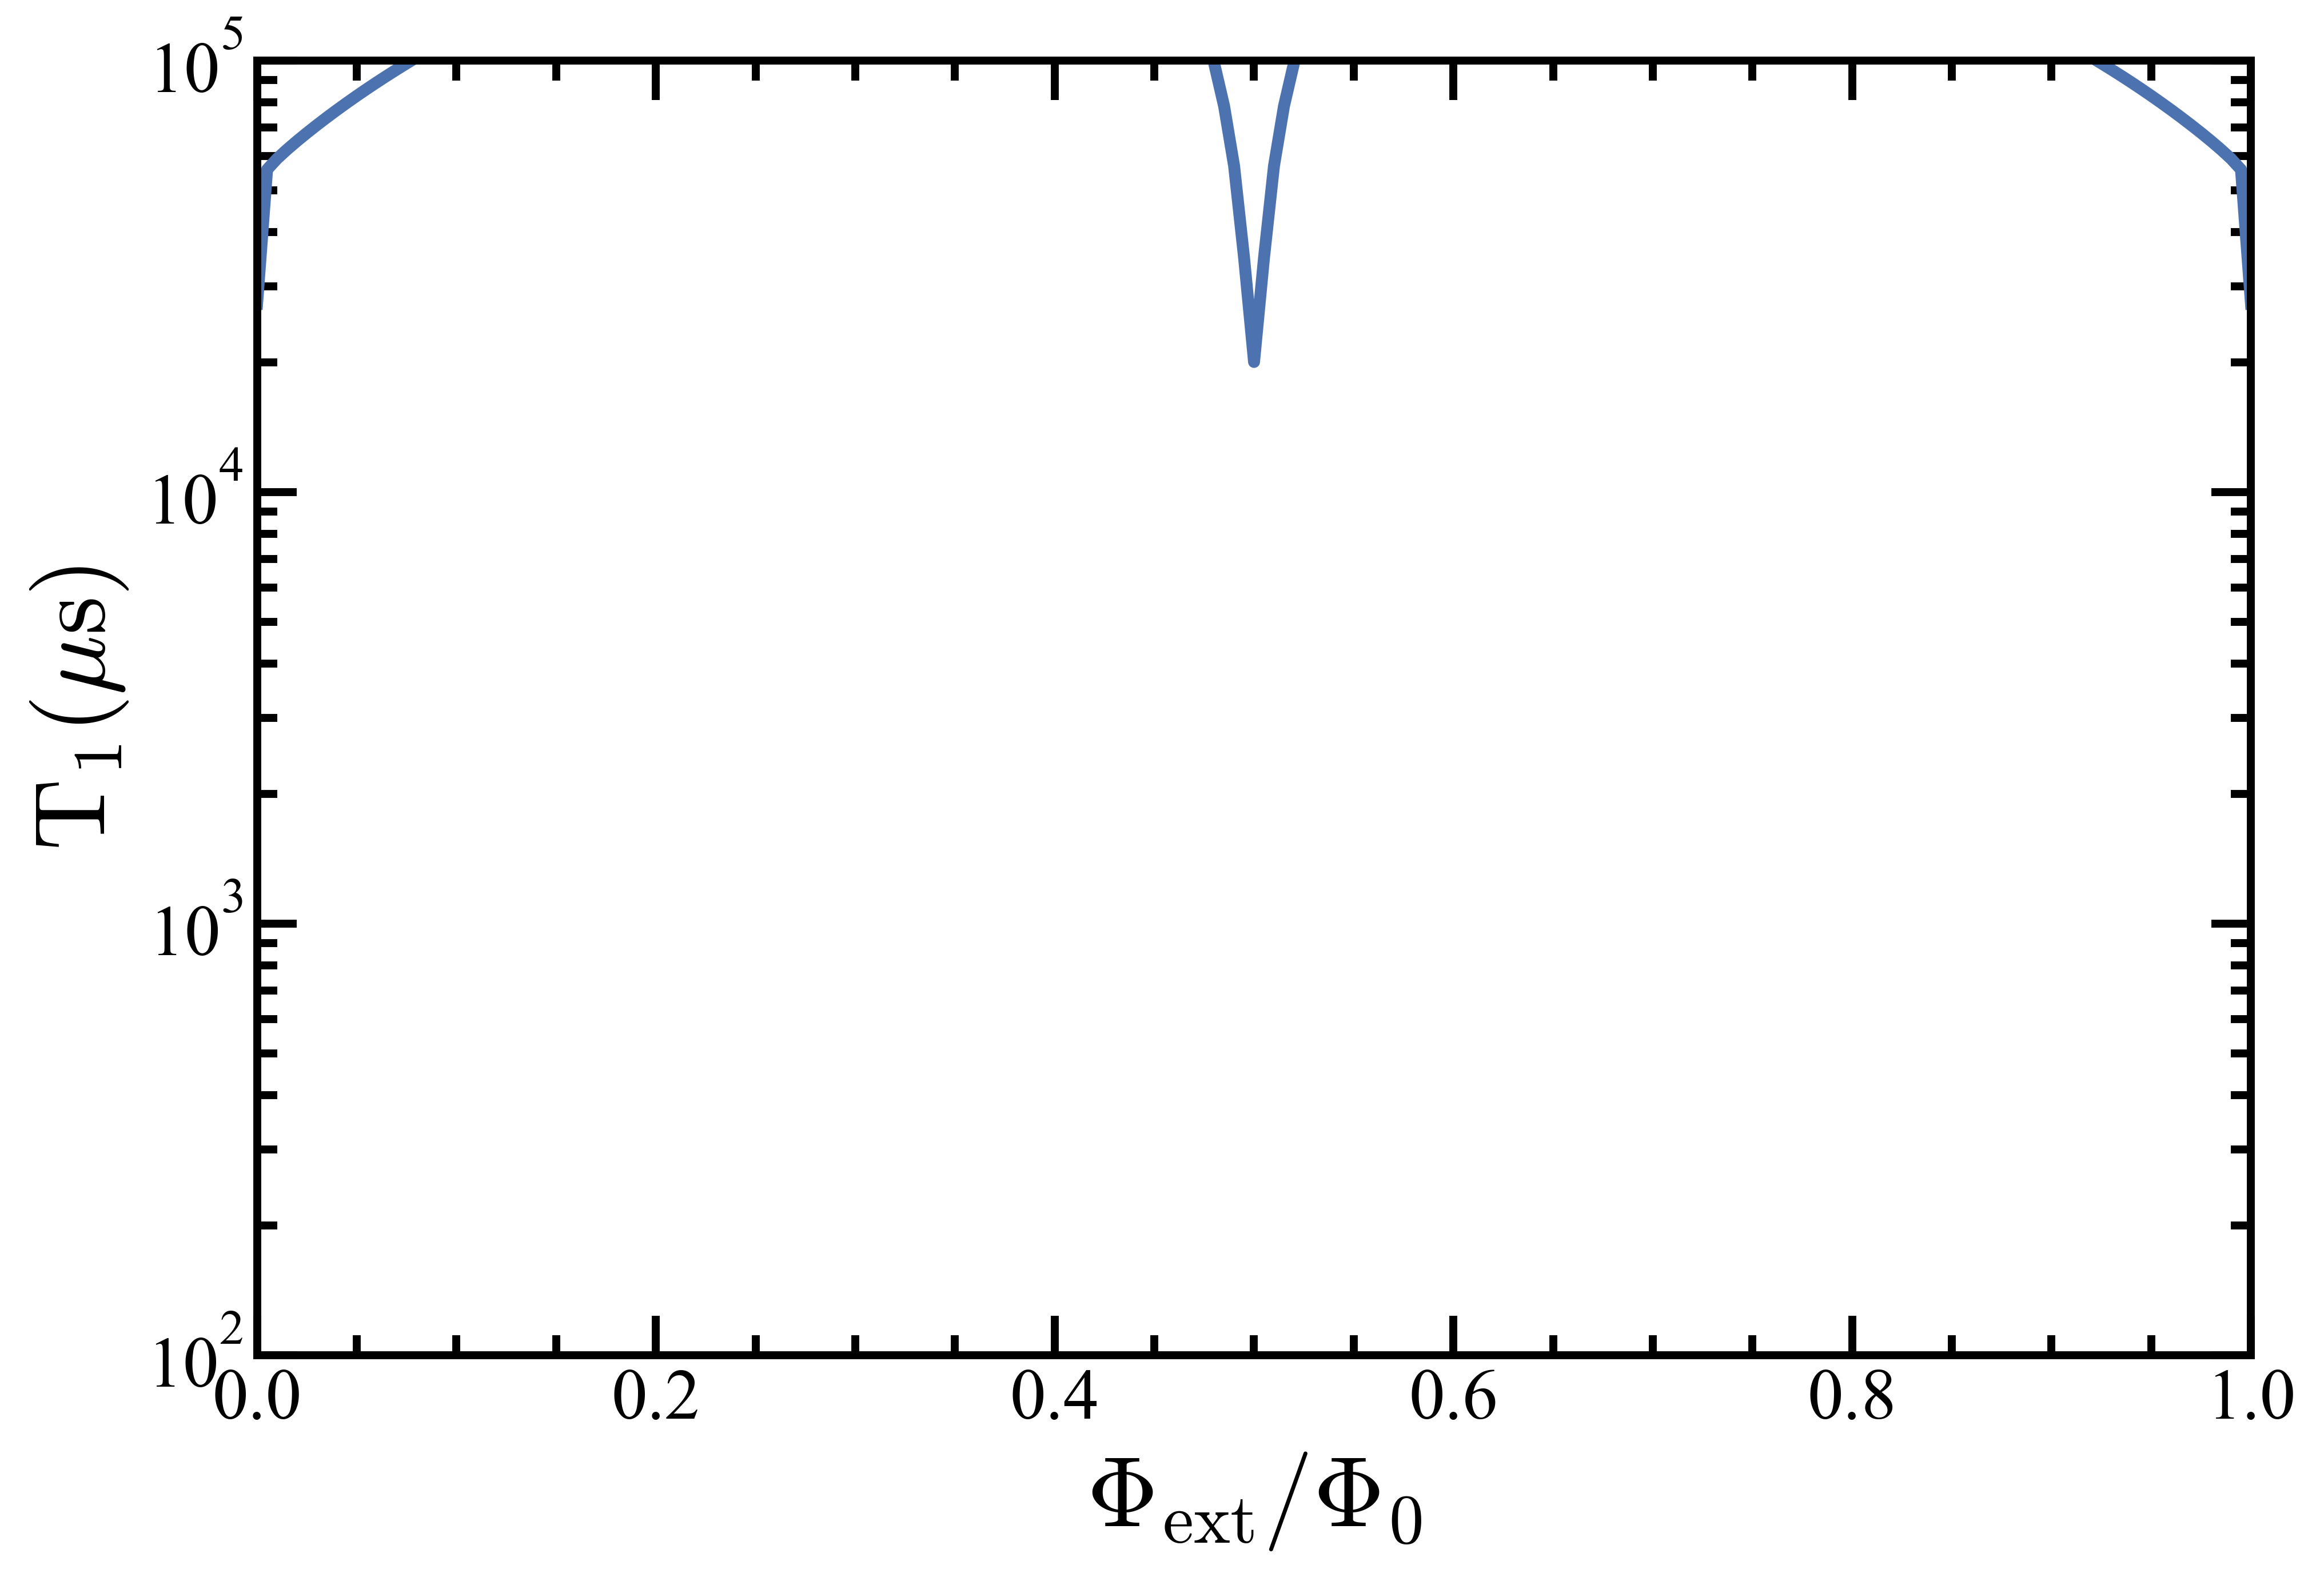

In [169]:
plt.figure(figsize = [9,6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.tick_params(labelsize = 18.0)
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_cap_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_cap[:,idx]) *1e6, linewidth= 3.0, linestyle ='-')
plt.ylim([100,100e3])

### Quasiparticles near small junction
For quasiparticle tunneling, we follow Catelani et al. to get the transition rate
$$\Gamma^\mathrm{qp}_{ij} = |\langle j | \sin \frac{\phi}{2}| i \rangle | ^2 \times \frac{8E_J}{\pi\hbar} x_\mathrm{qp} \sqrt{\frac{2\Delta}{\hbar\omega_{ij}}},$$
where $x_\mathrm{qp}$ is the quasiparticle density normalized by the Cooper pairs density, from which we define the quality factor $Q_\mathrm{qp} = 1/x_\mathrm{qp}$.

In [117]:
#Quasiparticle tunneling across small junction
T_qp = 20e-3 #effective temperature in K
thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
Q_qp_array = [(2e-7)**-1]
gamma_qp = np.zeros((len(phi_ext), len(Q_qp_array)), dtype=complex)
qp_me = np.zeros_like(gamma_qp)
for phi_idx, phi in enumerate(phi_ext):
    qp_me[phi_idx] = abs(fluxonium.qp_matrix_element(N, E_L, E_C, E_J, phi * 2.0 * np.pi, 0, 1))
for Q_idx, Q_qp in enumerate(Q_qp_array):
    for phi_idx in range(len(phi_ext)):
        gamma_qp[phi_idx, Q_idx] = fluxonium.relaxation_rate_qp(E_L, E_C, E_J, Q_qp, freq[phi_idx], 
                                                                      qp_me[phi_idx,0])*thermal_factor_qp[phi_idx]

<ipython-input-118-cd3d368a4636>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(phi_ext, 1.0/abs(gamma_qp[:,idx]) *1e6, linewidth= 2.0, linestyle ='-')


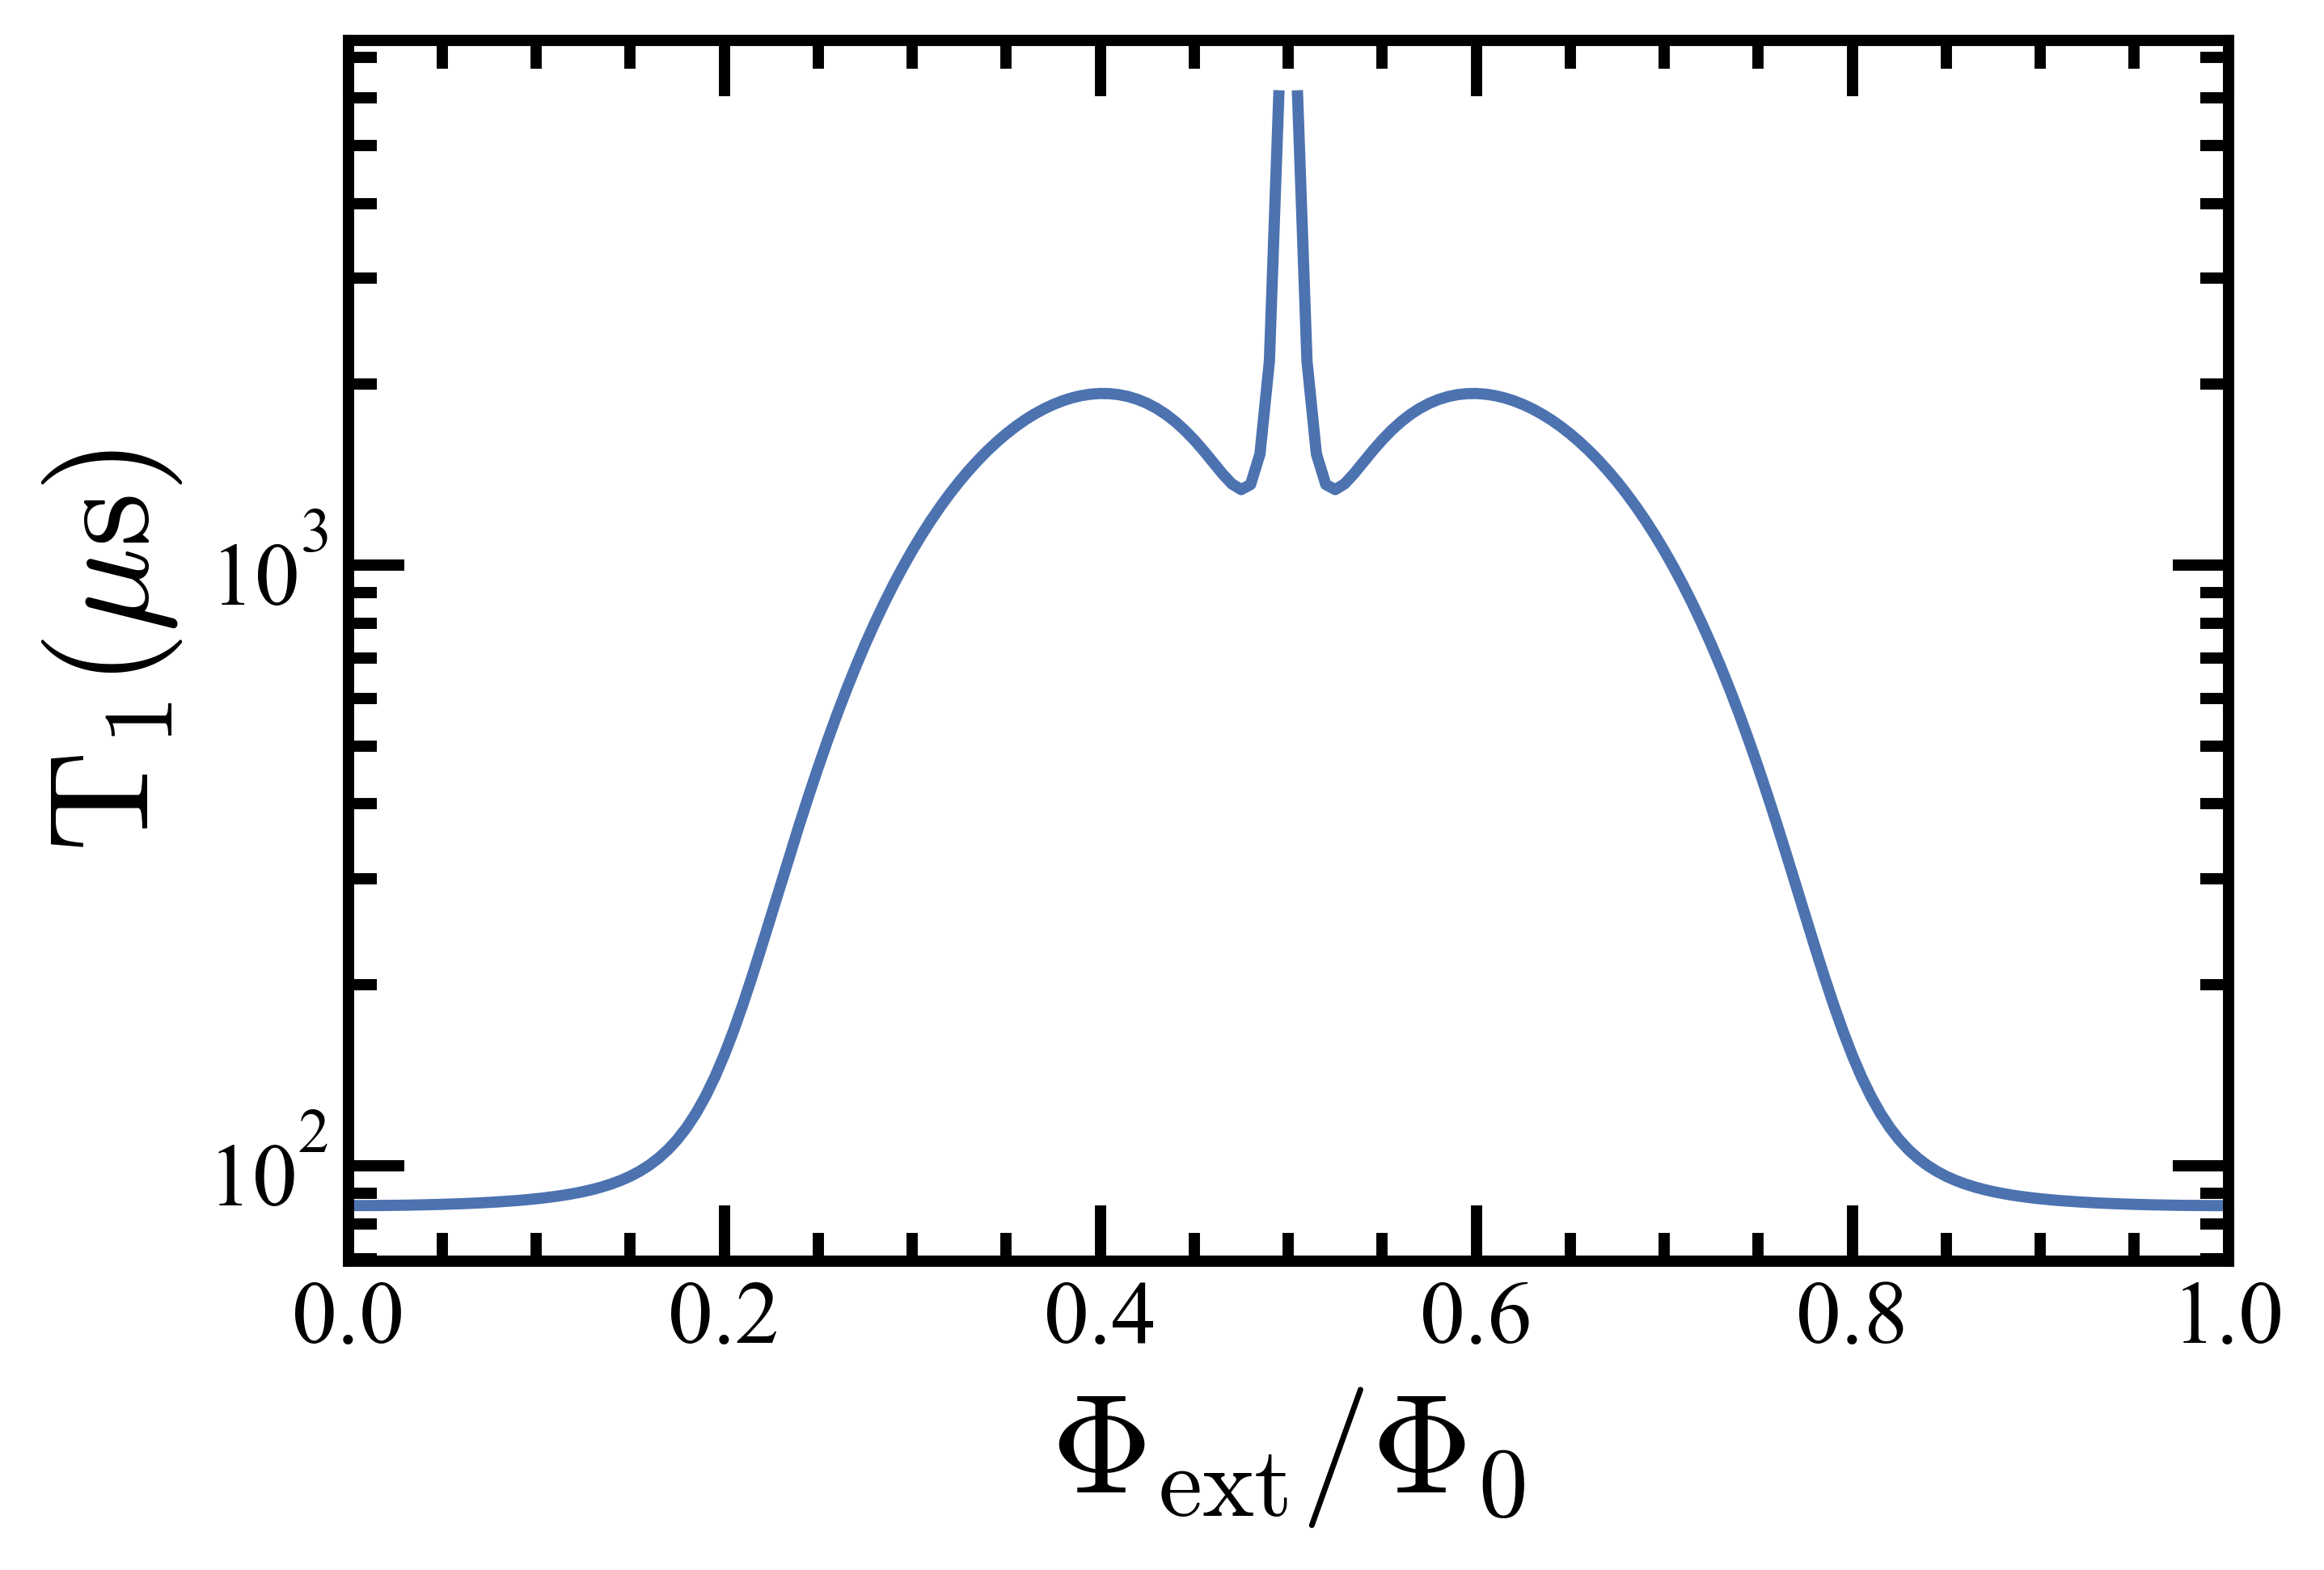

In [118]:
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_qp_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_qp[:,idx]) *1e6, linewidth= 2.0, linestyle ='-')

### Quasiparticles in the inductor
For quasiparticles in the Josephson junction array, we can generalize the formula above for $N$ junctions and linearize $\sin (\phi/2N) \approx \phi/2$ to get
$$\Gamma^\mathrm{qp,array}_{ij} = |\langle j | \frac{\phi}{2}| i \rangle | ^2 \times \frac{8E_L}{\pi\hbar} x_\mathrm{qp} \sqrt{\frac{2\Delta}{\hbar\omega_{ij}}},$$

In [119]:
#Quasiparticle in JJ array. Inductive noise has similar effects.
T_qp = 20e-3 #effective temperature in K
thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
Q_qp_array = [(2e-8)**-1]
gamma_qp_chain = np.zeros((len(phi_ext), len(Q_qp_array)), dtype=complex)
for Q_idx, Q_qp in enumerate(Q_qp_array):
    for phi_idx in range(len(phi_ext)):
        gamma_qp_chain[phi_idx, Q_idx] = fluxonium.relaxation_rate_qp_array(E_L, E_C, E_J, Q_qp, freq[phi_idx], 
                                                                      p_me[phi_idx,0])*thermal_factor_qp[phi_idx]

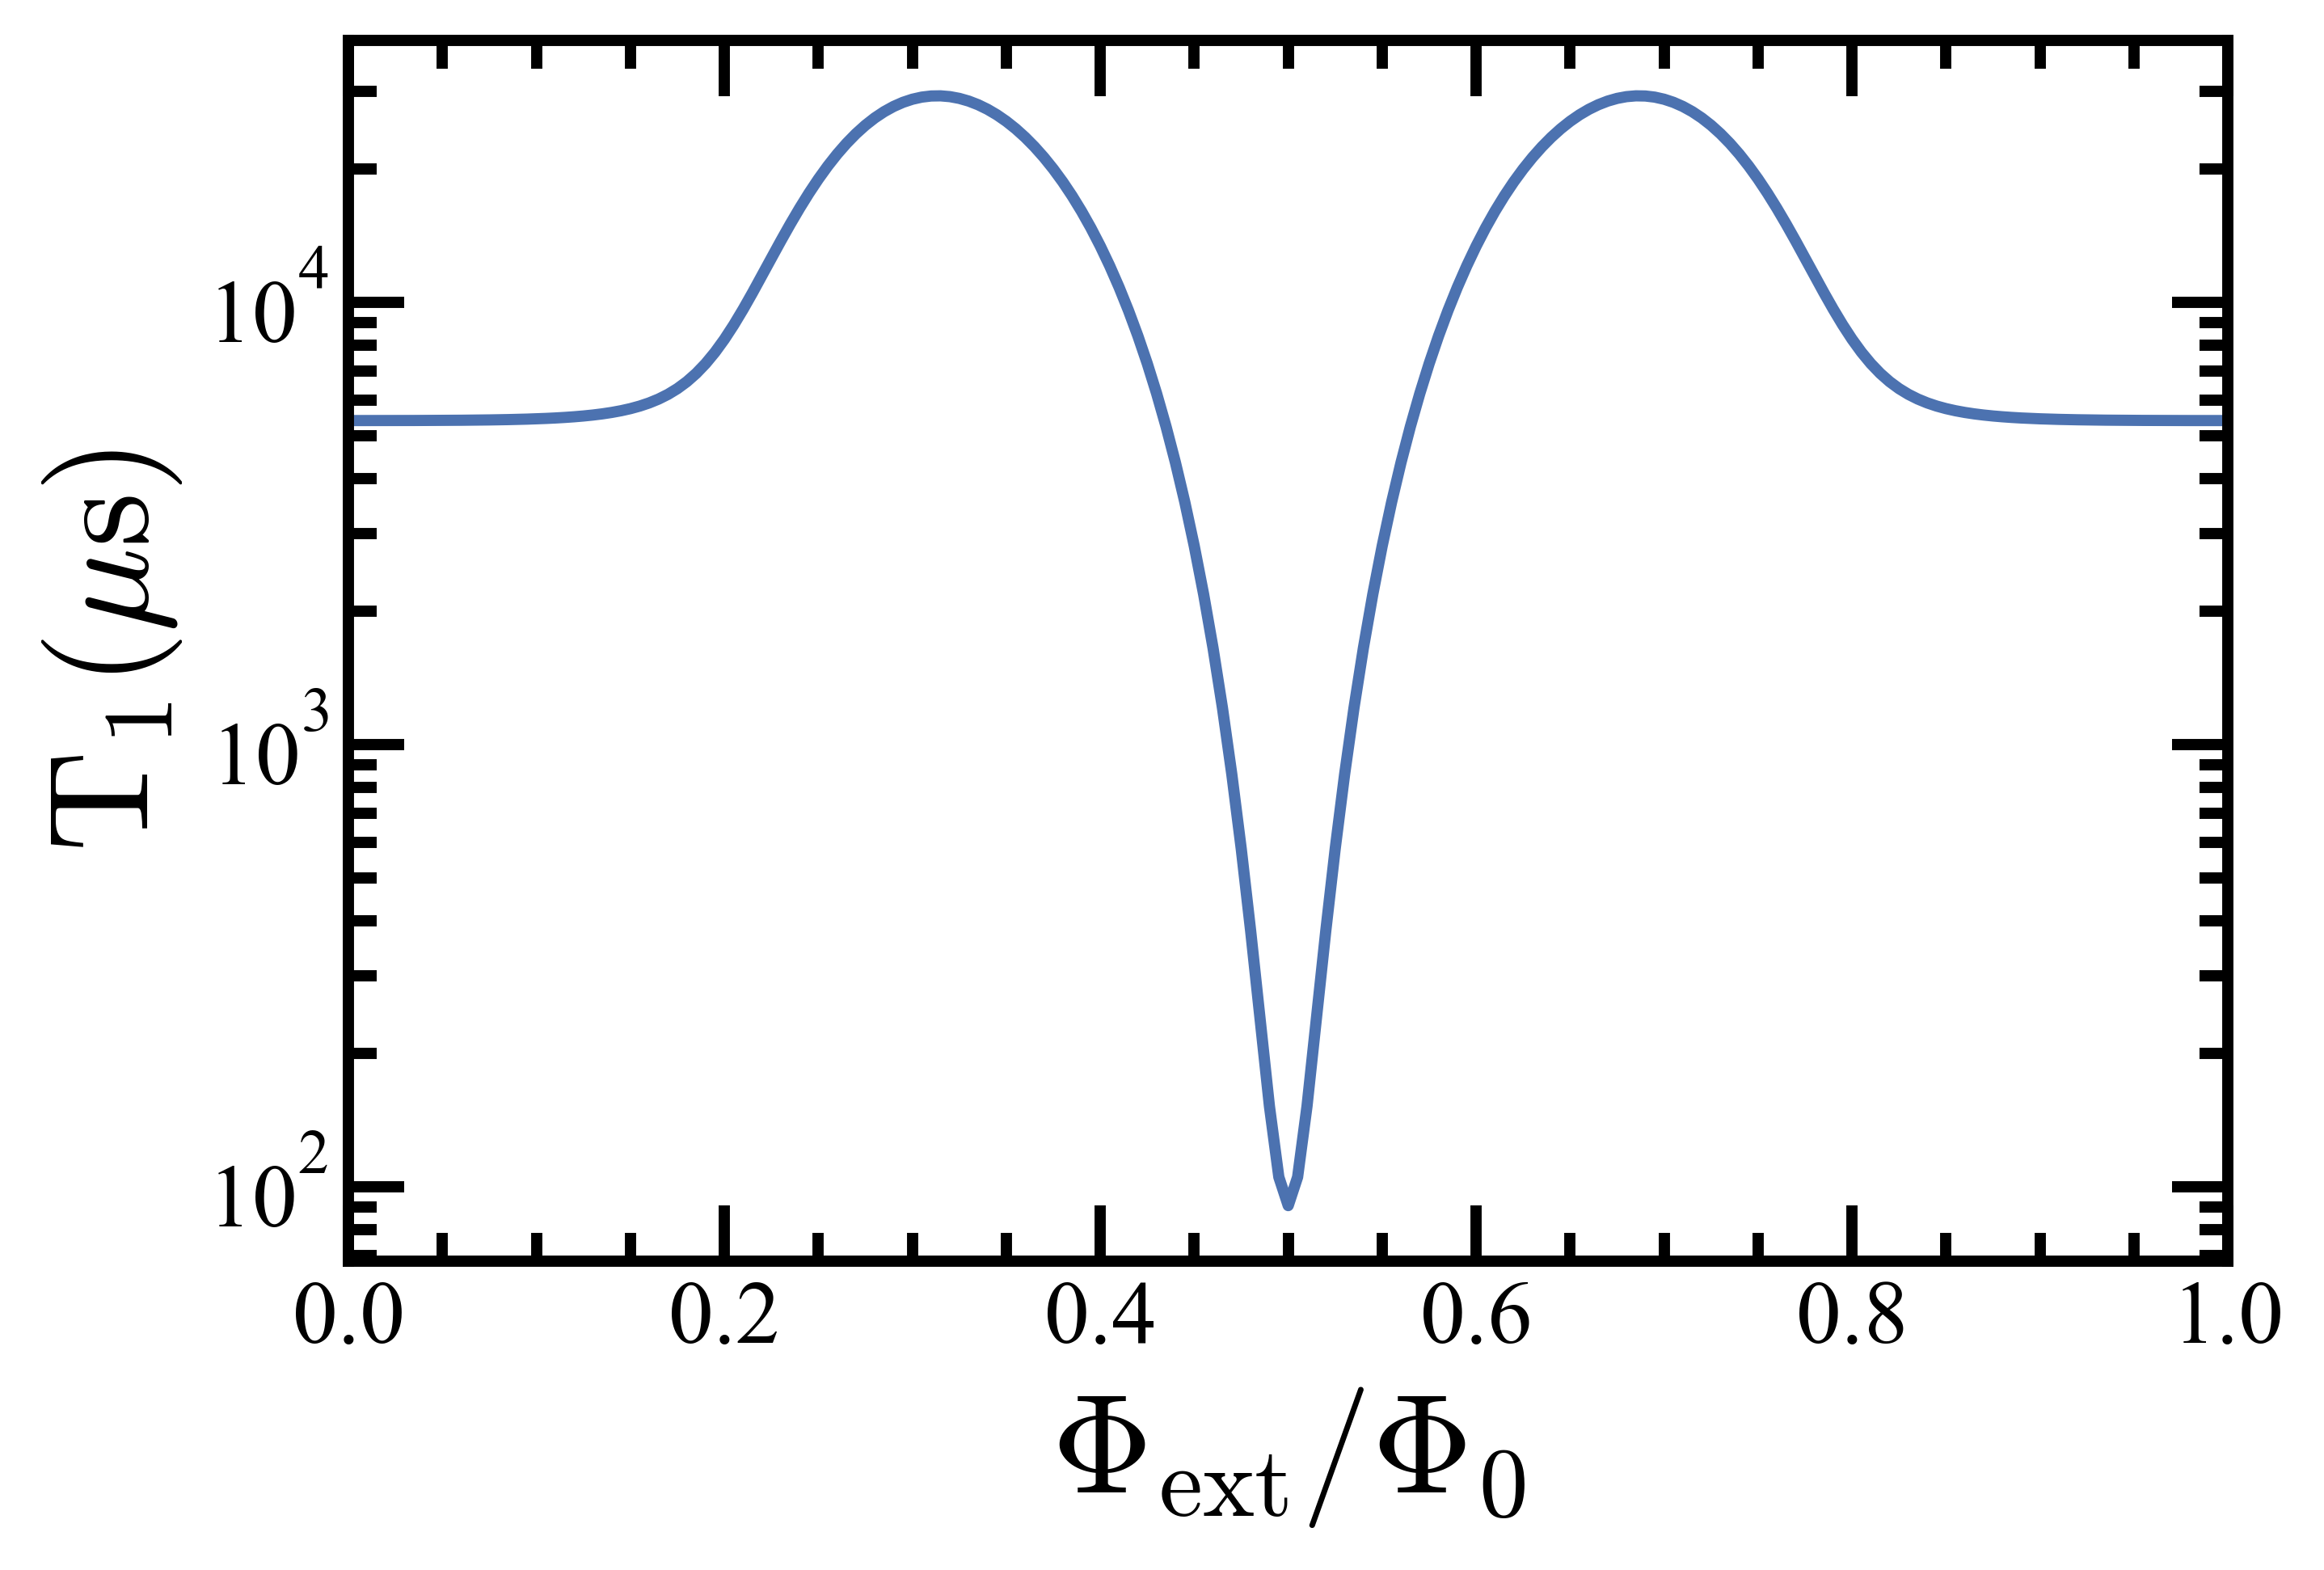

In [120]:
# plt.figure(figsize = [10,8])
# plt.ylim([10,1000])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_qp_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_qp_chain[:,idx]) *1e6, linewidth= 2.0, linestyle ='-', label='qp in inductor')

<ipython-input-121-43fcbcf9238f>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(phi_ext, 1.0/abs(gamma_qp[:,idx]) *1e6, linewidth= 2.0, linestyle ='--', label = 'qp near junction')


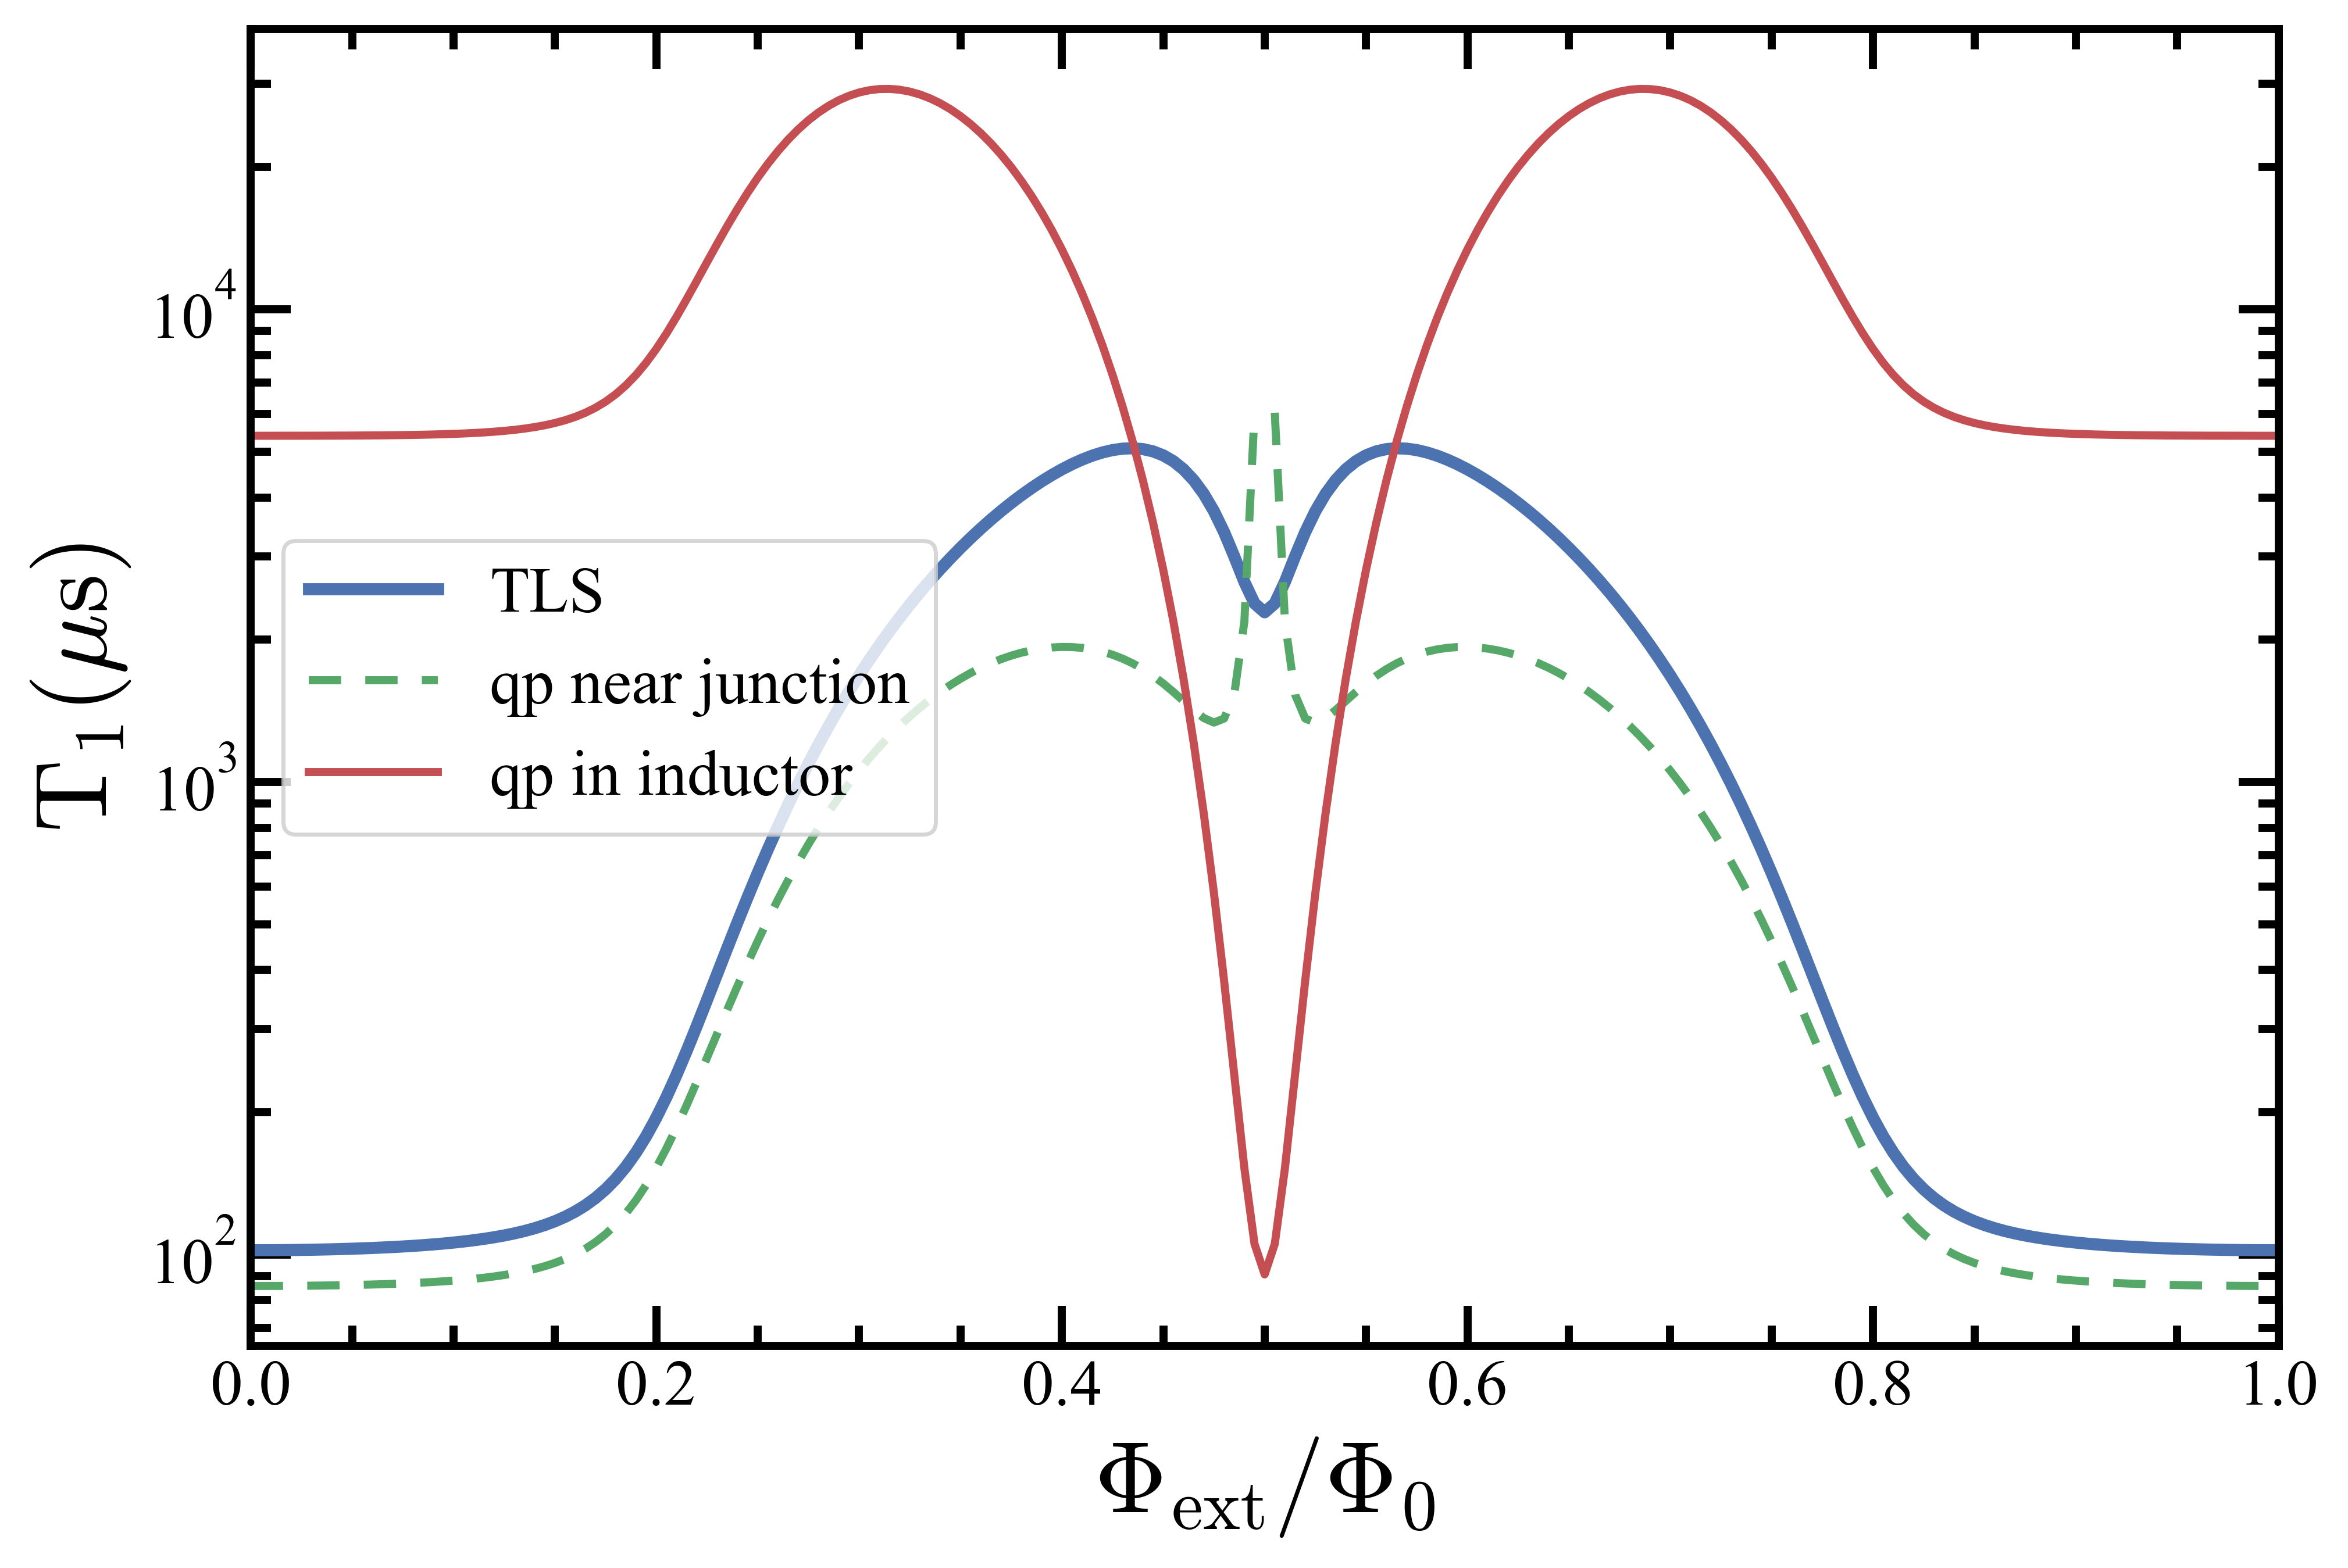

In [121]:
plt.figure(figsize = [9, 6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_cap_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_cap[:,idx]) *1e6, linewidth= 3.0, linestyle ='-', label = 'TLS')
for idx in range (len(Q_qp_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_qp[:,idx]) *1e6, linewidth= 2.0, linestyle ='--', label = 'qp near junction')
for idx in range (len(Q_qp_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_qp_chain[:,idx]) *1e6, linewidth= 2.0, linestyle ='-', label='qp in inductor')
plt.legend(loc='center left')

## Flux noise dephasing
We use the formula below to estimate the pure dephasing rate resulted from flux noise with spectral density
$$S(\omega) = \frac{2\pi A^2}{\omega}$$. Note that this corresponds to cancellation of the very low frequency part of the noise using echo technique.
$$\Gamma_\Phi = \left(\frac{\partial \omega}{\partial \Phi} \right)A\mathrm{ln}\sqrt{2} $$

(1, 1000)

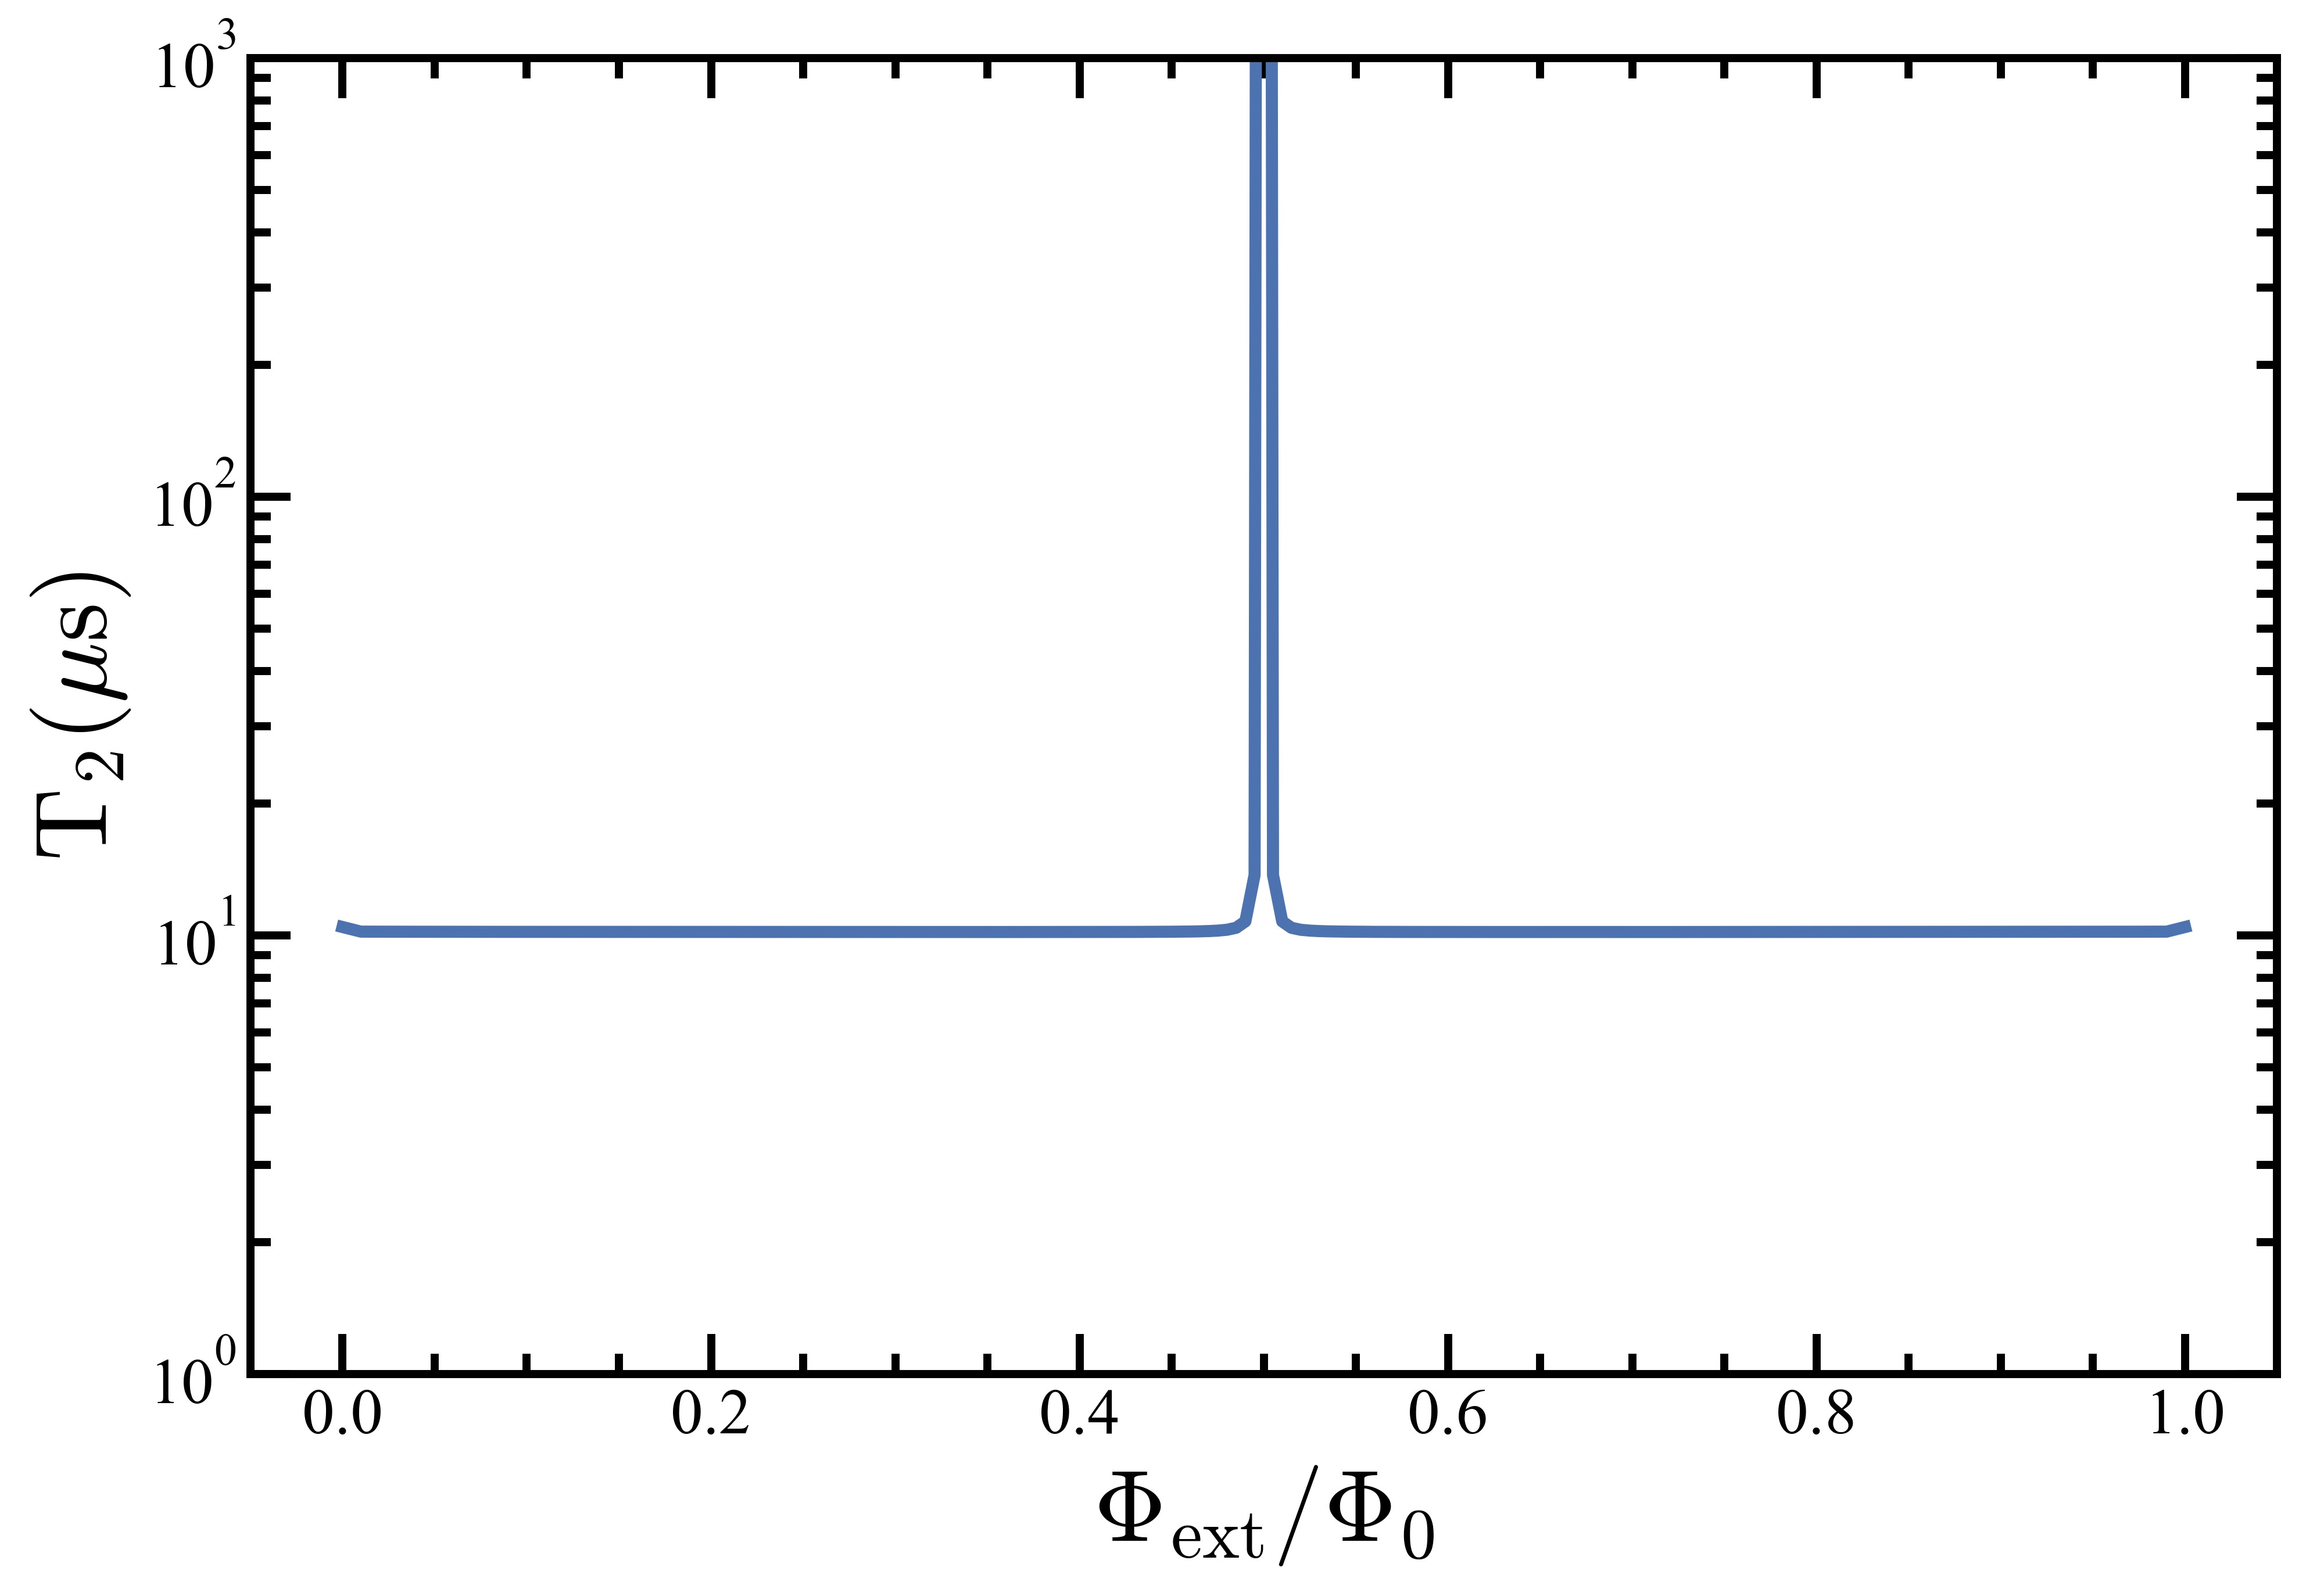

In [165]:
#T2 due to flux noise (measured with echo)
plt.figure(figsize=[9,6])
fn_amp = 2.0e-6 #unit is flux quantum
trans_energy = energies[:,1]-energies[:,0]
sensitivity = np.gradient(trans_energy)/(phi_ext[1]-phi_ext[0]) #in unit of GHz / (Flux/phi_o)
sensitivity = sensitivity*1e9*2*np.pi #Unit of radian Hz / (Flux/phi_o)
gamma = abs(sensitivity)*fn_amp*np.sqrt(np.log(2))
plt.semilogy(phi_ext, (gamma**-1)*1e6)
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel(r'$\mathrm{T_2(\mu s)}$')
plt.ylim([1,1000])

We can also estimate the dephasing limit corresponding to second order flux noise using
$$\Gamma_\Phi^{(2)} \approx \frac{\partial^2 \omega}{\partial\lambda^2}A^2$$

Text(0, 0.5, '$\\mathrm{T_2(s)}$')

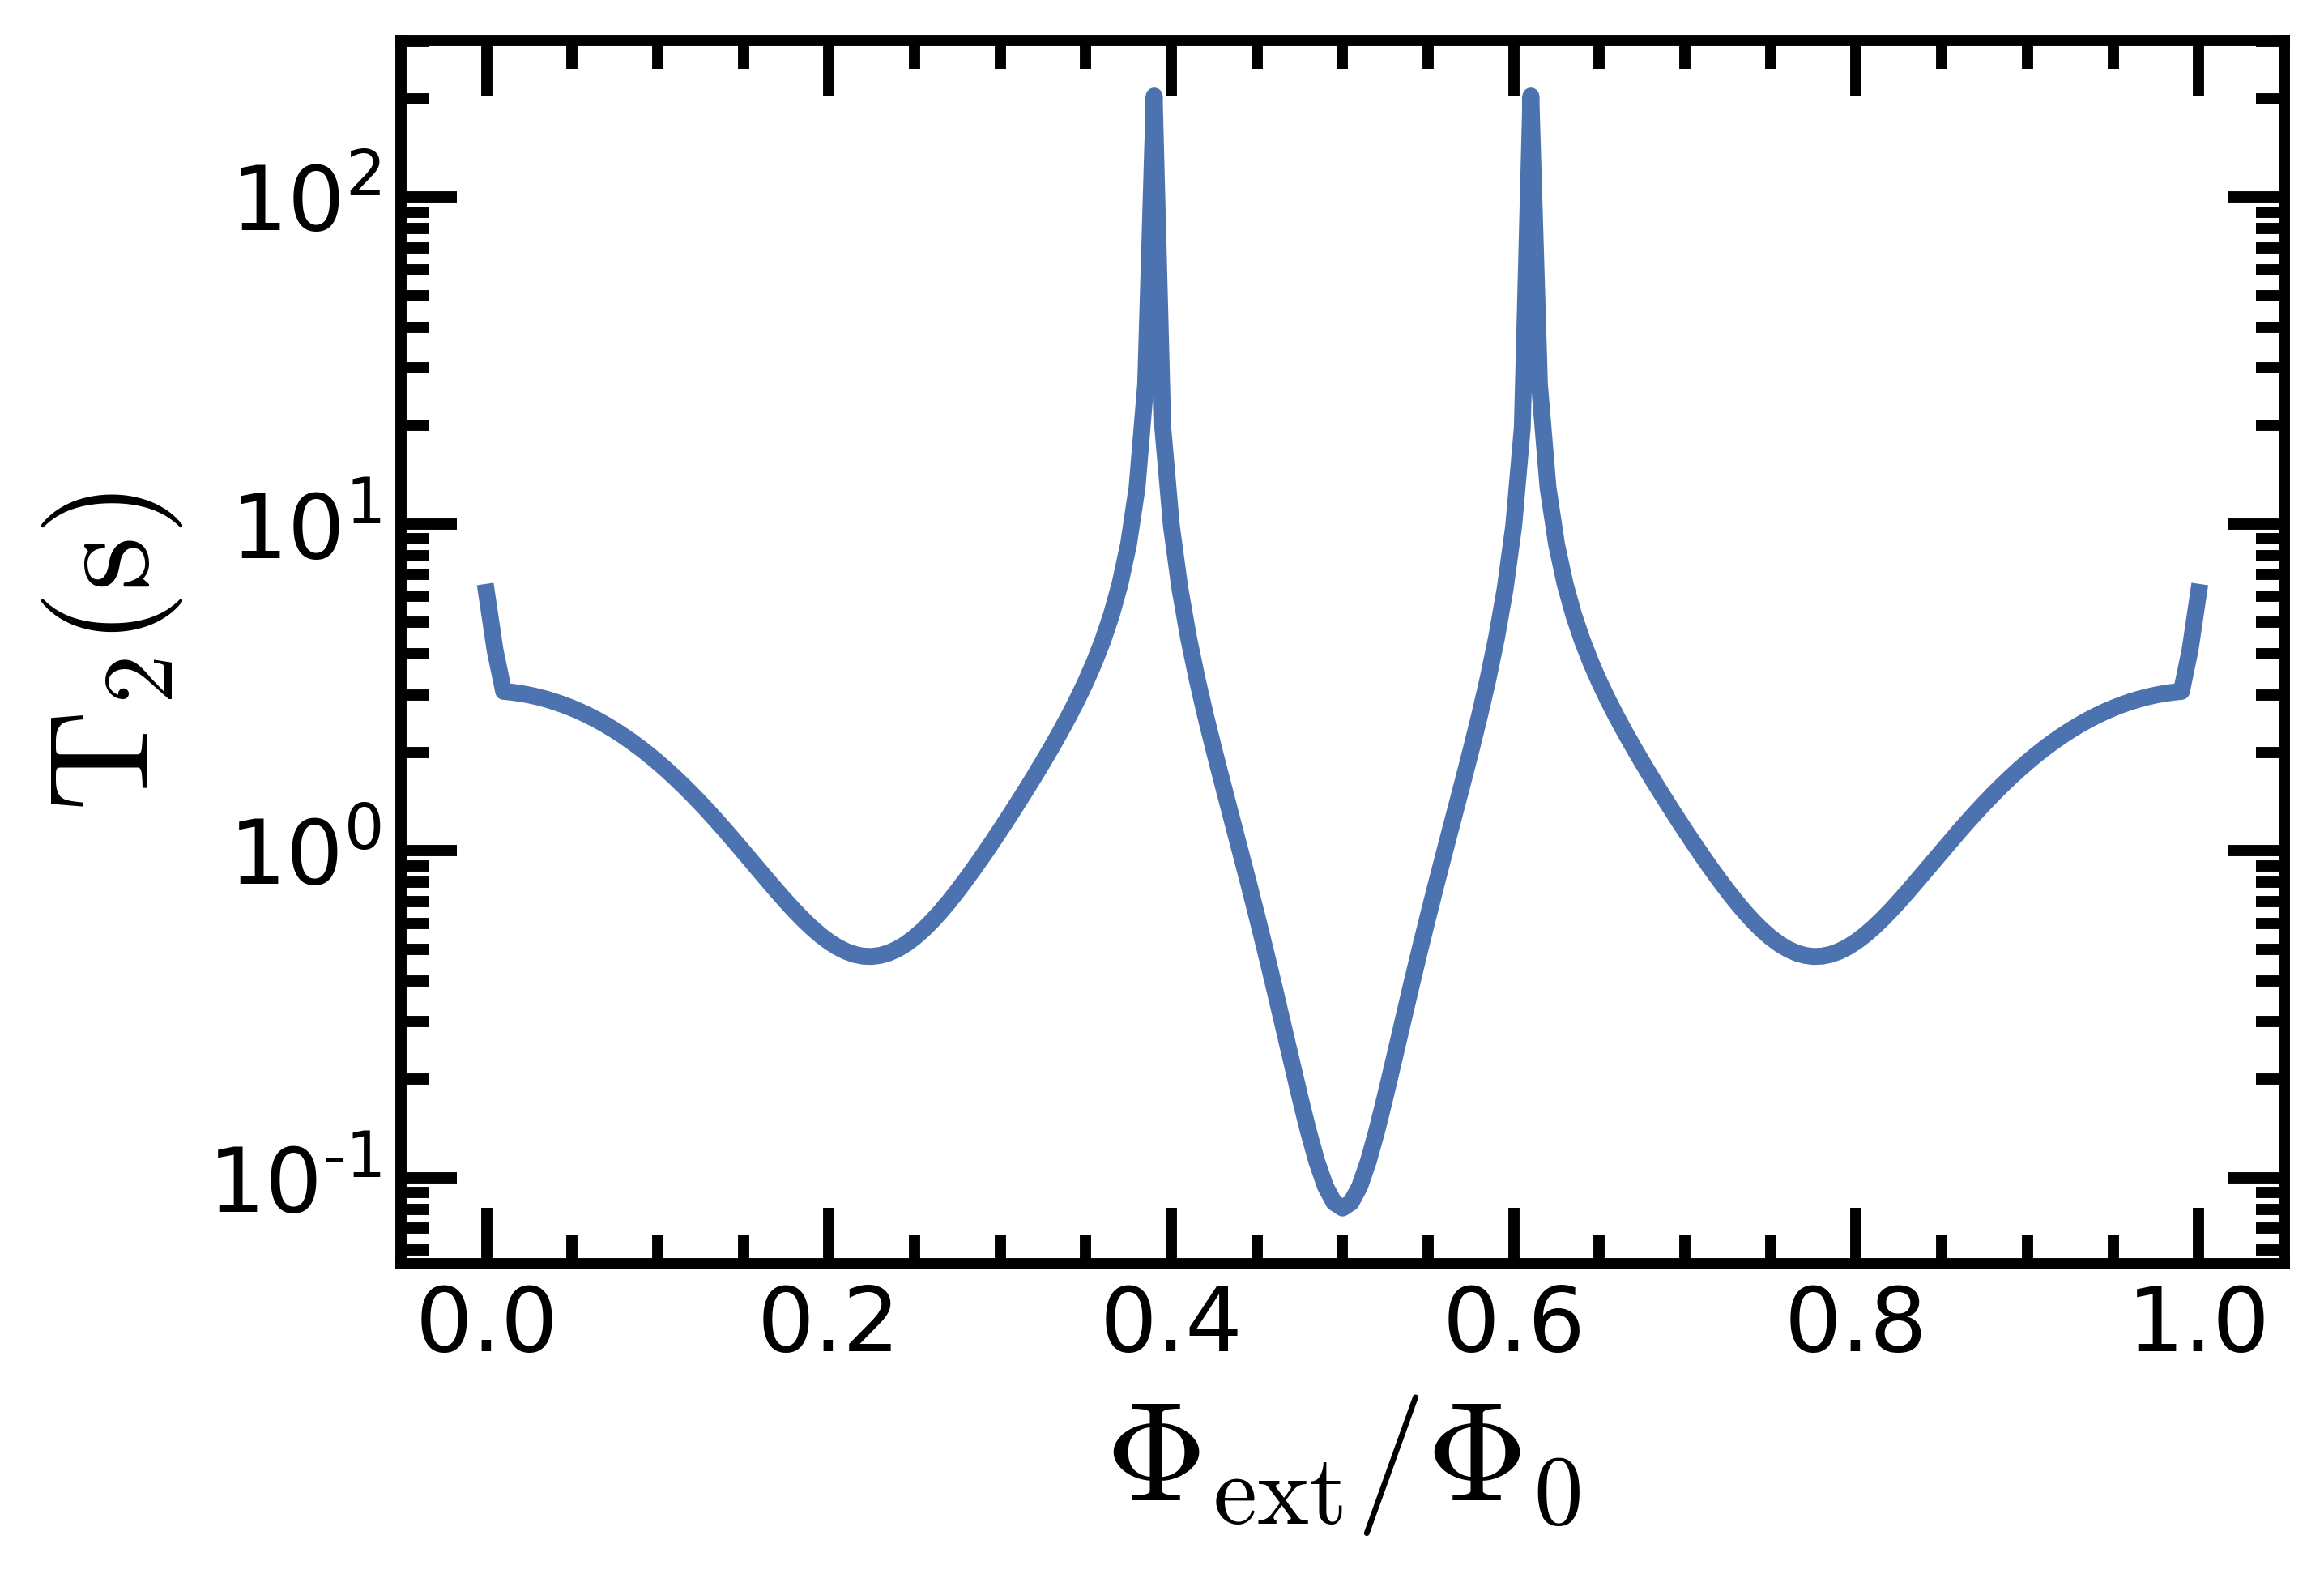

In [28]:
#T2 due to 2nd order flux noise
fn_amp = 2.0e-6 #unit is flux quantum
trans_energy = energies[:,1]-energies[:,0]
sensitivity = np.gradient(trans_energy)/(phi_ext[1]-phi_ext[0]) #in unit of GHz / (Flux/phi_o)
sensitivity2 = np.gradient(sensitivity)/(phi_ext[1]-phi_ext[0]) #in unit of GHz / (Flux/phi_o)^2
sensitivity2 = sensitivity2*1e9*2*np.pi #in unit of radian Hz / (Flux/phi_o)^2
gamma = abs(sensitivity2)*fn_amp**2
plt.semilogy(phi_ext, (gamma**-1))
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel(r'$\mathrm{T_2(s)}$')

## Photon shot noise
Use the formula
$$\Gamma_\mathrm{photon} = \frac{\kappa_R}{2}\mathrm{Re}\left[\sqrt{\left(1+\frac{i\chi_{01}}{\kappa_R} \right)^2 + \frac{4i\chi_{01}\mathrm{n^{eff}_{th}}}{\kappa_R}}-1 \right] $$
from Rigetti et al., PRB (2012).

Text(0.5, 0, '$n_\\mathrm{th}$')

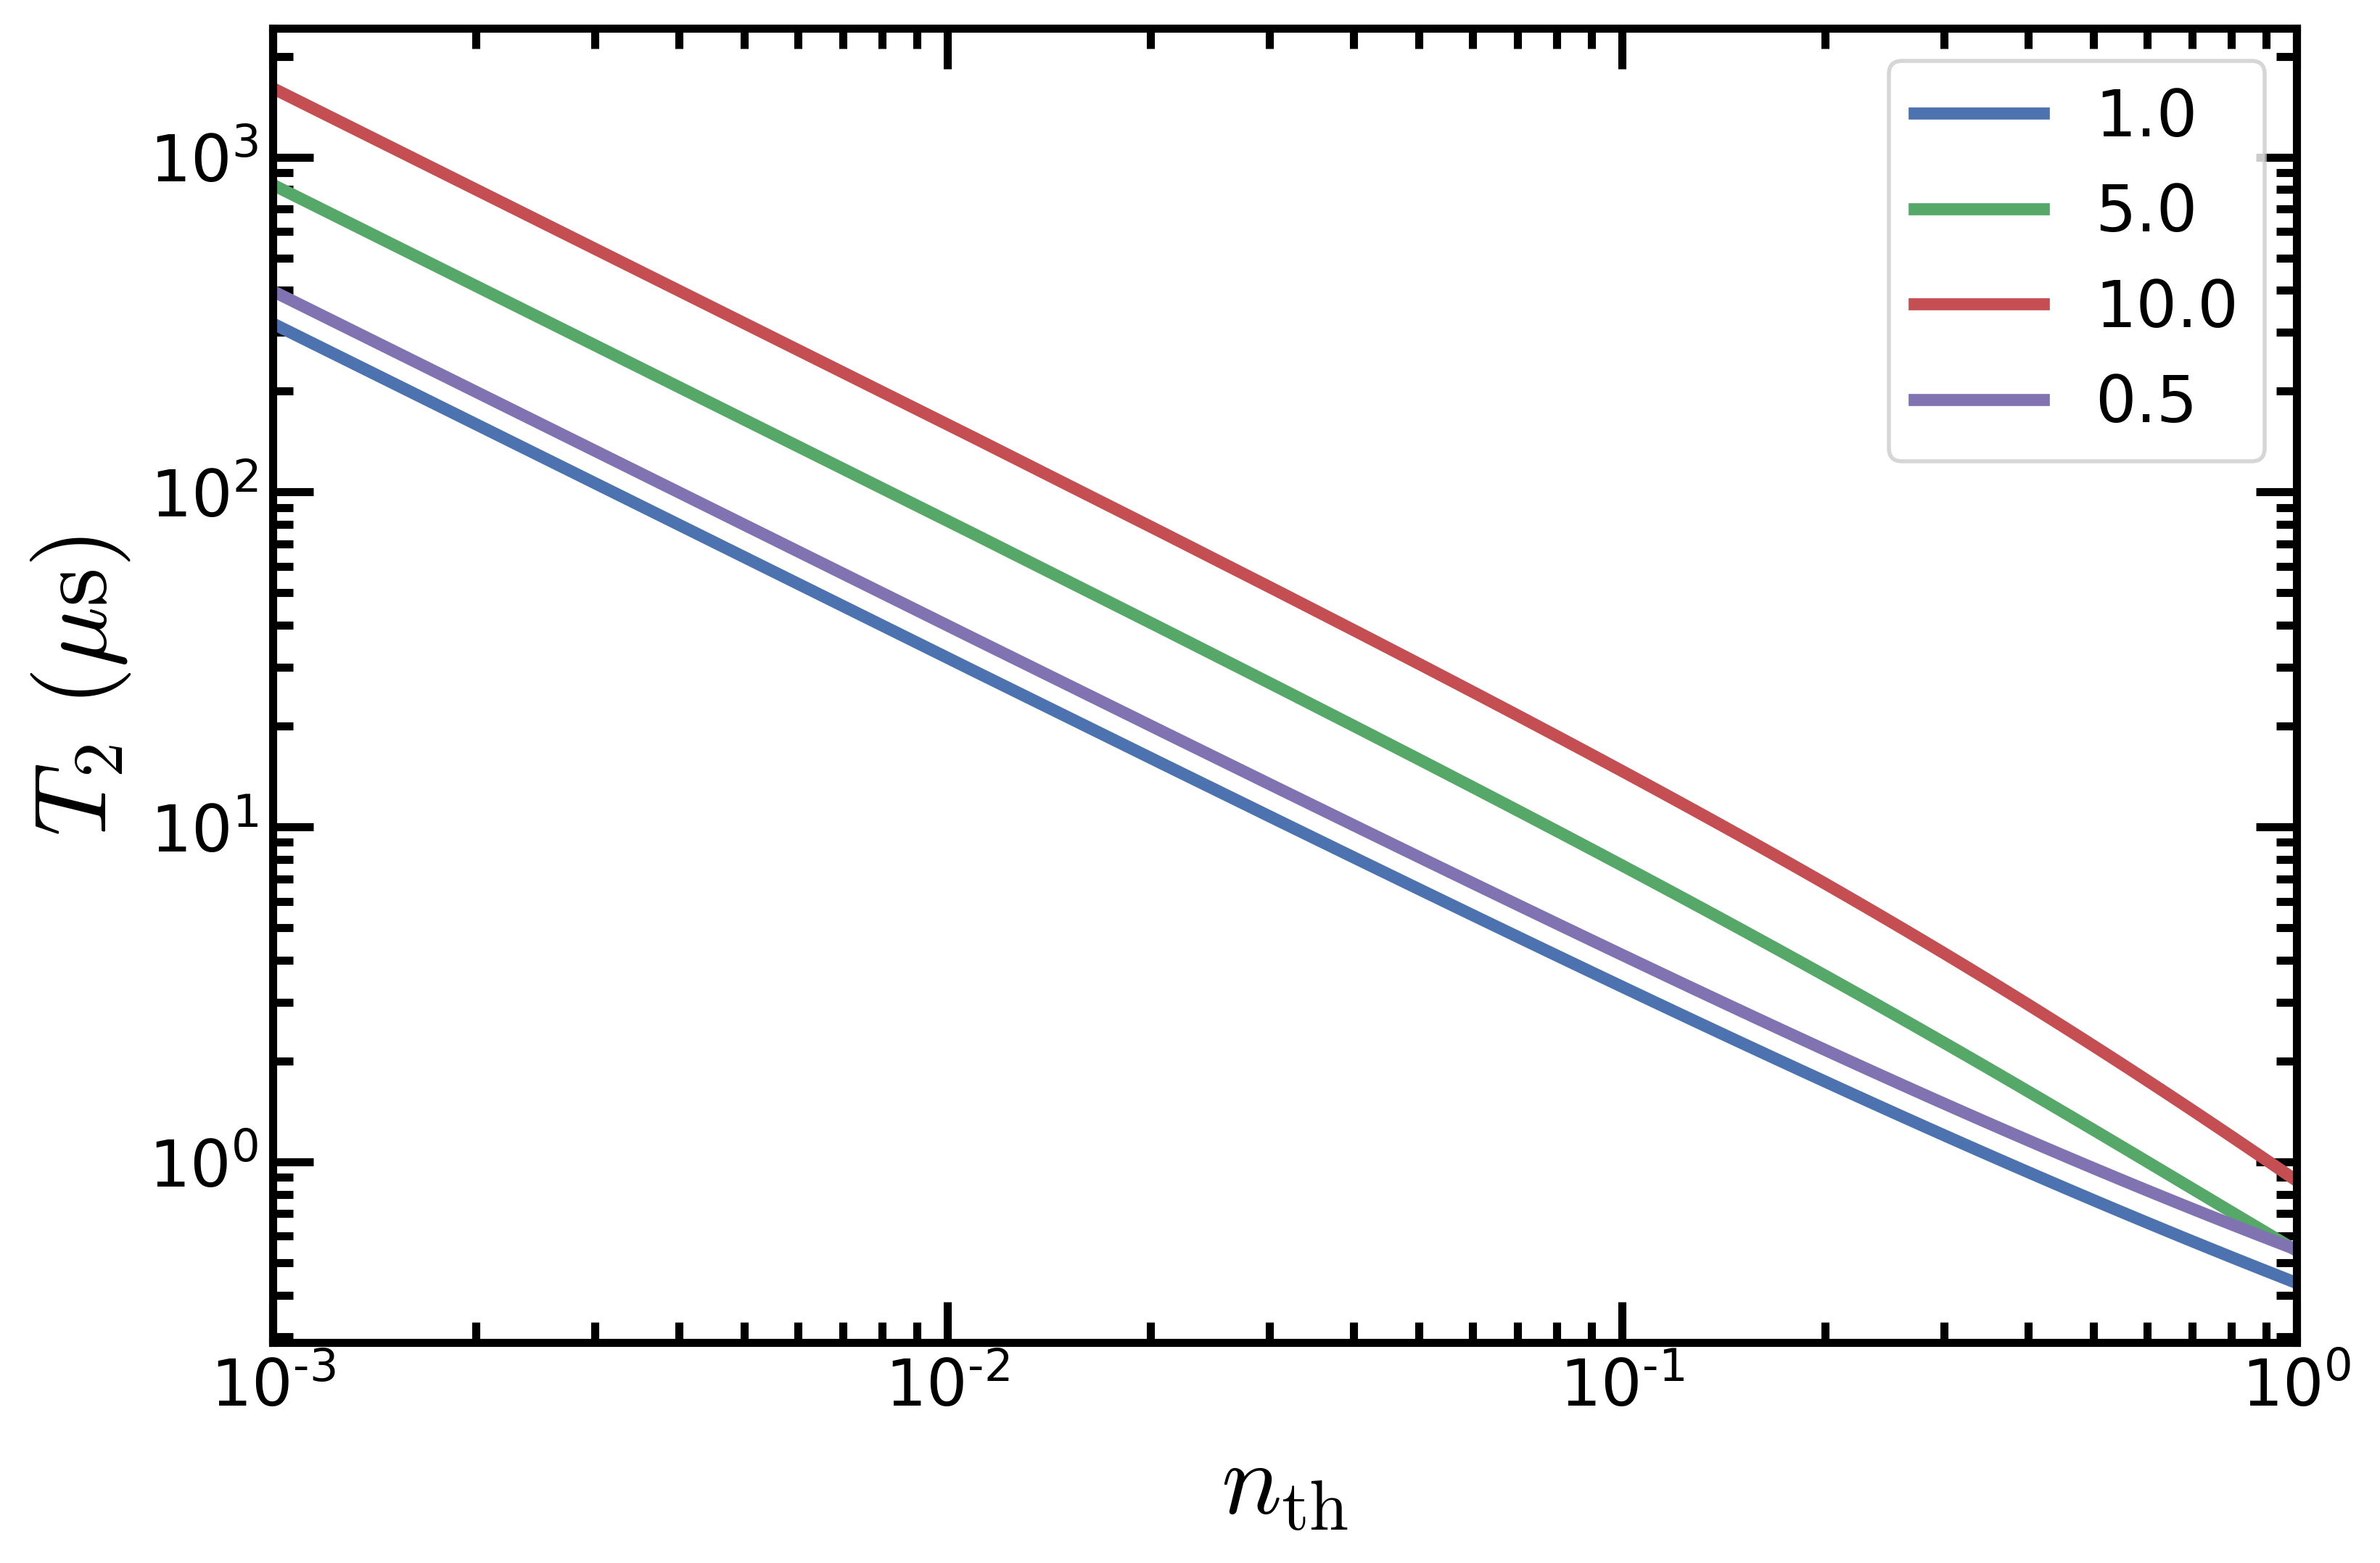

In [8]:
def thermal_dephasing_rate(chi,kappa,n):
    term1 = 1+1j*chi/kappa
    term2 = 4j*chi*n/kappa
    return 0.5*kappa*np.real(np.sqrt(term1**2+term2)-1)

plt.figure(figsize = [9,6])
n = np.linspace(1e-3,1,101)
chi = 1e6 #MHz
for kappa in [1e6, 5e6, 10e6, 0.5e6]:
    gamma = thermal_dephasing_rate(chi,kappa,n)
    plt.loglog(n, (gamma*2*np.pi)**-1*1e6, label = kappa/1e6)
plt.legend()
plt.xlim([1e-3,1])
plt.ylabel(r'$T_2~(\mathrm{\mu s})$')
plt.xlabel(r'$n_\mathrm{th}$')

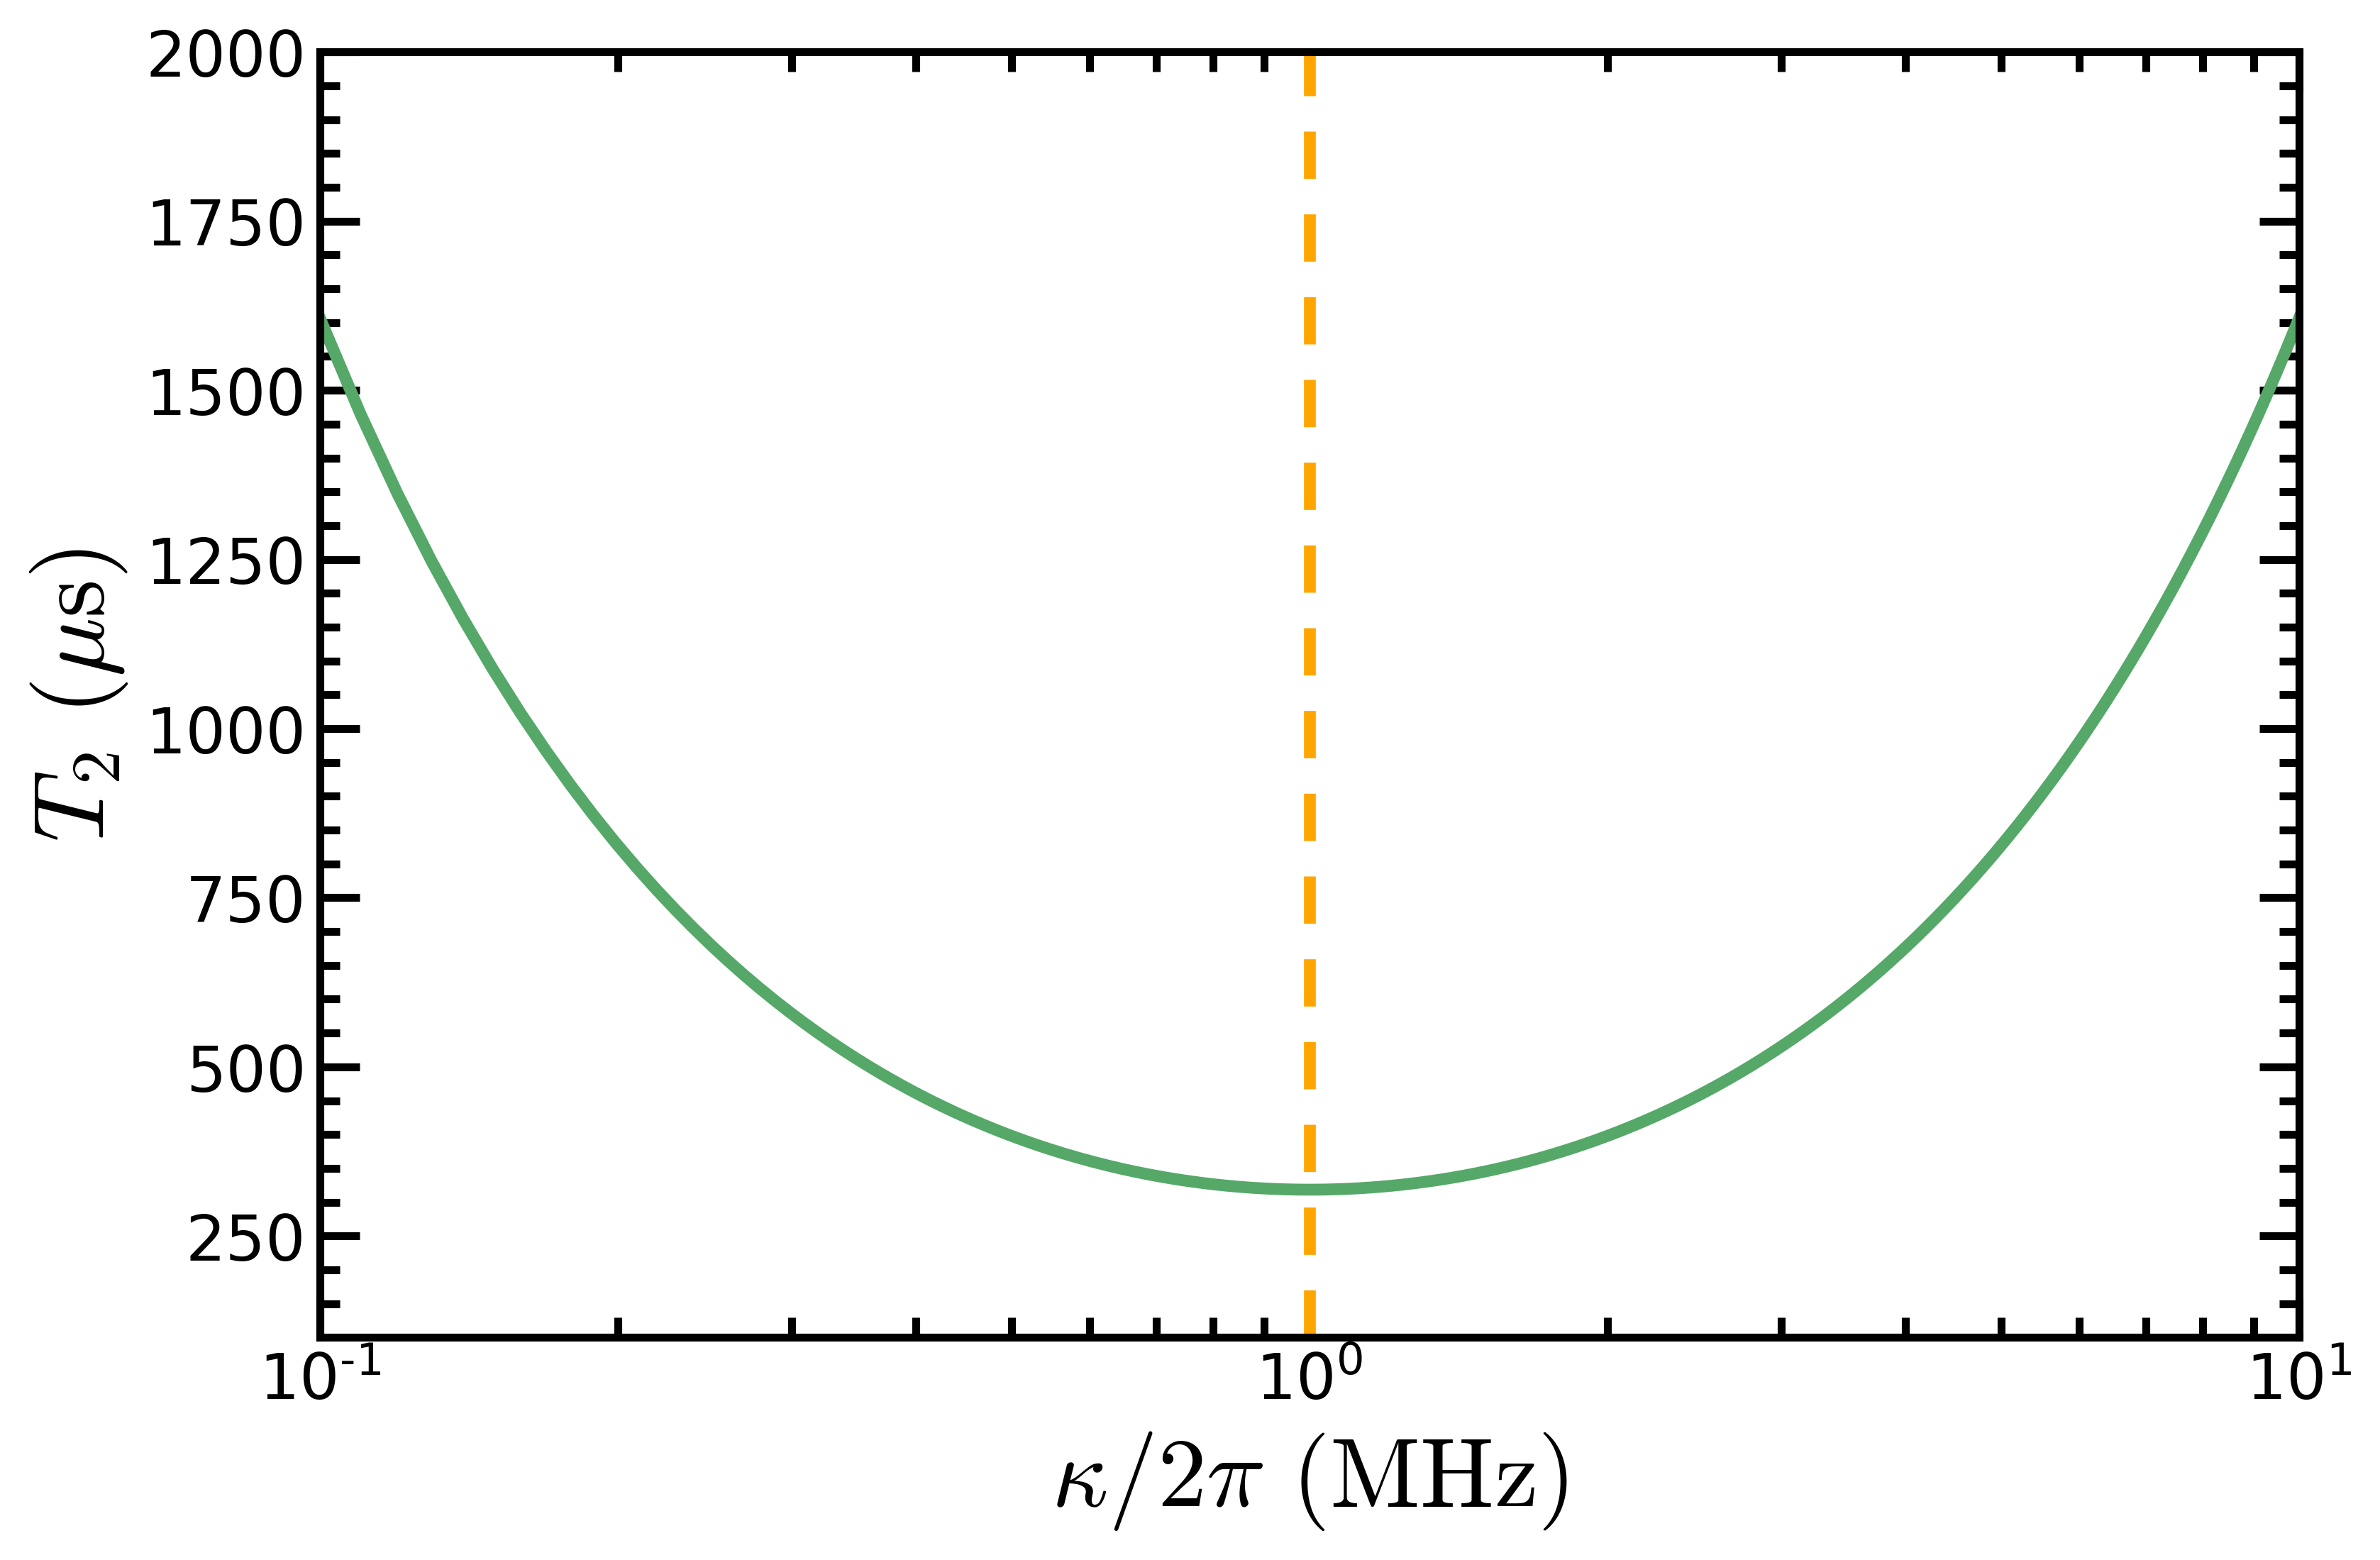

In [10]:
plt.figure(figsize = [9,6])
n = 0.001
kappa = np.linspace (0.1,10,1001)*1e6
gamma = thermal_dephasing_rate(chi,kappa,n)
plt.semilogx(kappa/1e6, (gamma*2*np.pi)**-1*1e6, color = 'C1')
# plt.plot(kappa/1e6, (gamma*2*np.pi)**-1*1e6, color = 'C1')
plt.xlim([kappa[0]/1e6, kappa[-1]/1e6])
plt.ylabel(r'$T_2~(\mathrm{\mu s})$')
plt.xlabel(r'$\kappa/2\pi~(\mathrm{MHz})$')
plt.ylim([100,2000])
plt.axvline(x=1, color = 'orange', linestyle = '--')


## Wave functions in charge basis 


In [31]:
from scipy.sparse import diags
def n_op(N,Nrange):
    n_pts = np.linspace(-Nrange,Nrange,N)
#     n = diags(n_pts,shape=(N,N), format='csr', dtype='complex128')
    n = np.diag(n_pts)
    return Qobj(n)

def n2_op(N,Nrange):
    n_pts = np.linspace(-Nrange,Nrange,N)
#     n = diags(n_pts,shape=(N,N), format='csr', dtype='complex128')
    n = np.diag(n_pts)
    return Qobj(n**2)

def phi_op(N,Nrange):
    n_pts = np.linspace(-Nrange,Nrange,N)
    dnphi = n_pts[-1]-n_pts[-2]
    dnphi_coeff = 1/(2*dnphi)
    phi = -1.j * diags([-dnphi_coeff, dnphi_coeff], [-1,1], shape=(N,N), format='csr', dtype='complex128')
    return Qobj(phi)

# def phi2_op(N,Nrange):
#     n_pts = np.linspace(-Nrange,Nrange,N)
#     dnphi = n_pts[-1]-n_pts[-2]
#     dnphi_coeff = 1/(2*dnphi)
#     phi = 1.j * diags([-dnphi_coeff, dnphi_coeff], [-1,1], shape=(N,N), format='csr', dtype='complex128')
#     return Qobj((phi-phi_ext)**2)

# def cosphi_op(N,Nrange, phi_ext):
#     op = diags([0.5,0.5], [-1,1], shape=(N,N), format='csr', dtype='complex128')
#     return Qobj(op)

def hamiltonian_charge(N, Nrange, E_L, E_C, E_J, phi_ext):
    H = 4*E_C*n2_op(N,Nrange) +0.5*E_L*phi_op(N,Nrange)**2 - E_J*(phi_op(N,Nrange)+phi_ext).cosm()
    return H

In [32]:
E_L=0.5
E_C=1
E_J = 3
phi_ext = np.pi
N = 501
Nrange = 10
evalues, evectors = hamiltonian_charge(N, Nrange, E_L,E_C,E_J,phi_ext).eigenstates()

(-10.0, 10.0)

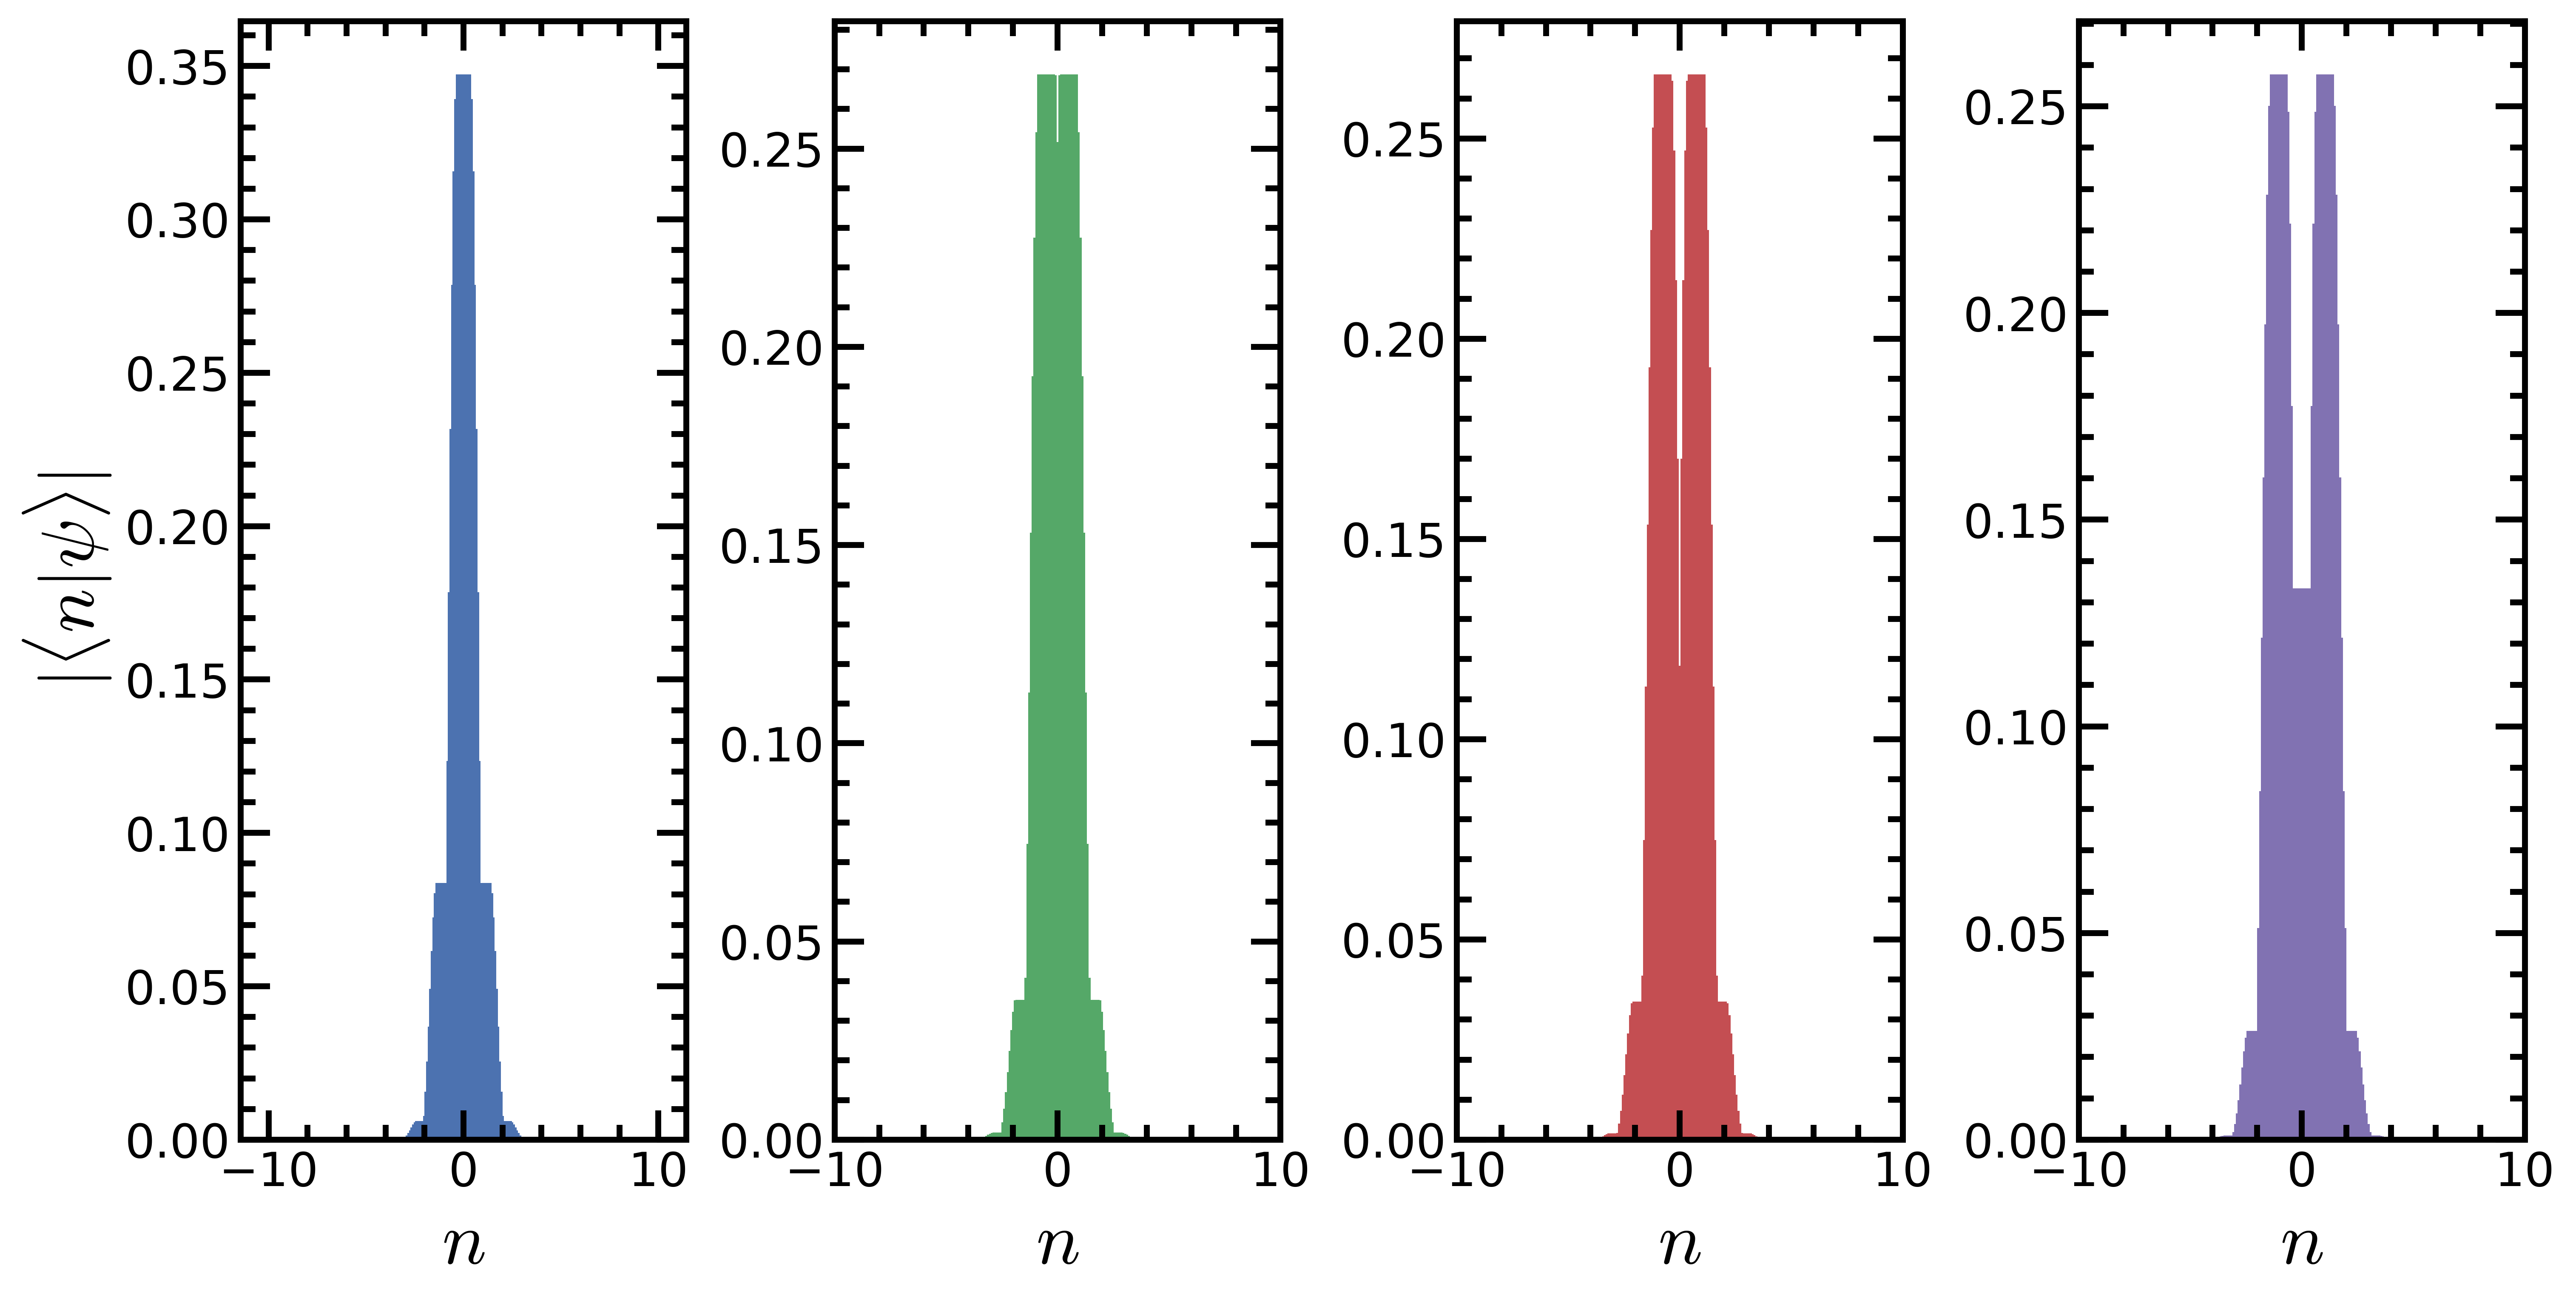

In [33]:
n = np.linspace(-10,10,N)
fig, ax = plt.subplots(1,4, figsize = [12,6], constrained_layout=True)
# fig.tight_layout()

state_to_plot = 0
ax[0].bar(n, abs(evectors[state_to_plot].full()[:,0]))
ax[0].set_xlabel('$n$')
ax[0].set_ylabel(r'$|\langle n|\psi \rangle | $')


state_to_plot = 2
ax[1].bar(n, abs(evectors[state_to_plot].full()[:,0]), color = 'C1')
ax[1].set_xlim([-10,10])
ax[1].set_xlabel('$n$')

state_to_plot = 4
ax[2].bar(n, abs(evectors[state_to_plot].full()[:,0]), color = 'C2')
ax[2].set_xlabel('$n$')
ax[2].set_xlim([-10,10])

state_to_plot = 6
ax[3].bar(n, abs(evectors[state_to_plot].full()[:,0]), color = 'C3')
ax[3].set_xlabel('$n$')
ax[3].set_xlim([-10,10])

In [34]:
level_num = 10
phi_ext = np.linspace(0,1,51)*2*np.pi
energies = np.zeros((len(phi_ext), level_num))
for idx, phi in enumerate(phi_ext):
    energies [idx,:] = hamiltonian_charge(N, Nrange, E_L,E_C,E_J,phi).eigenenergies(eigvals=level_num)

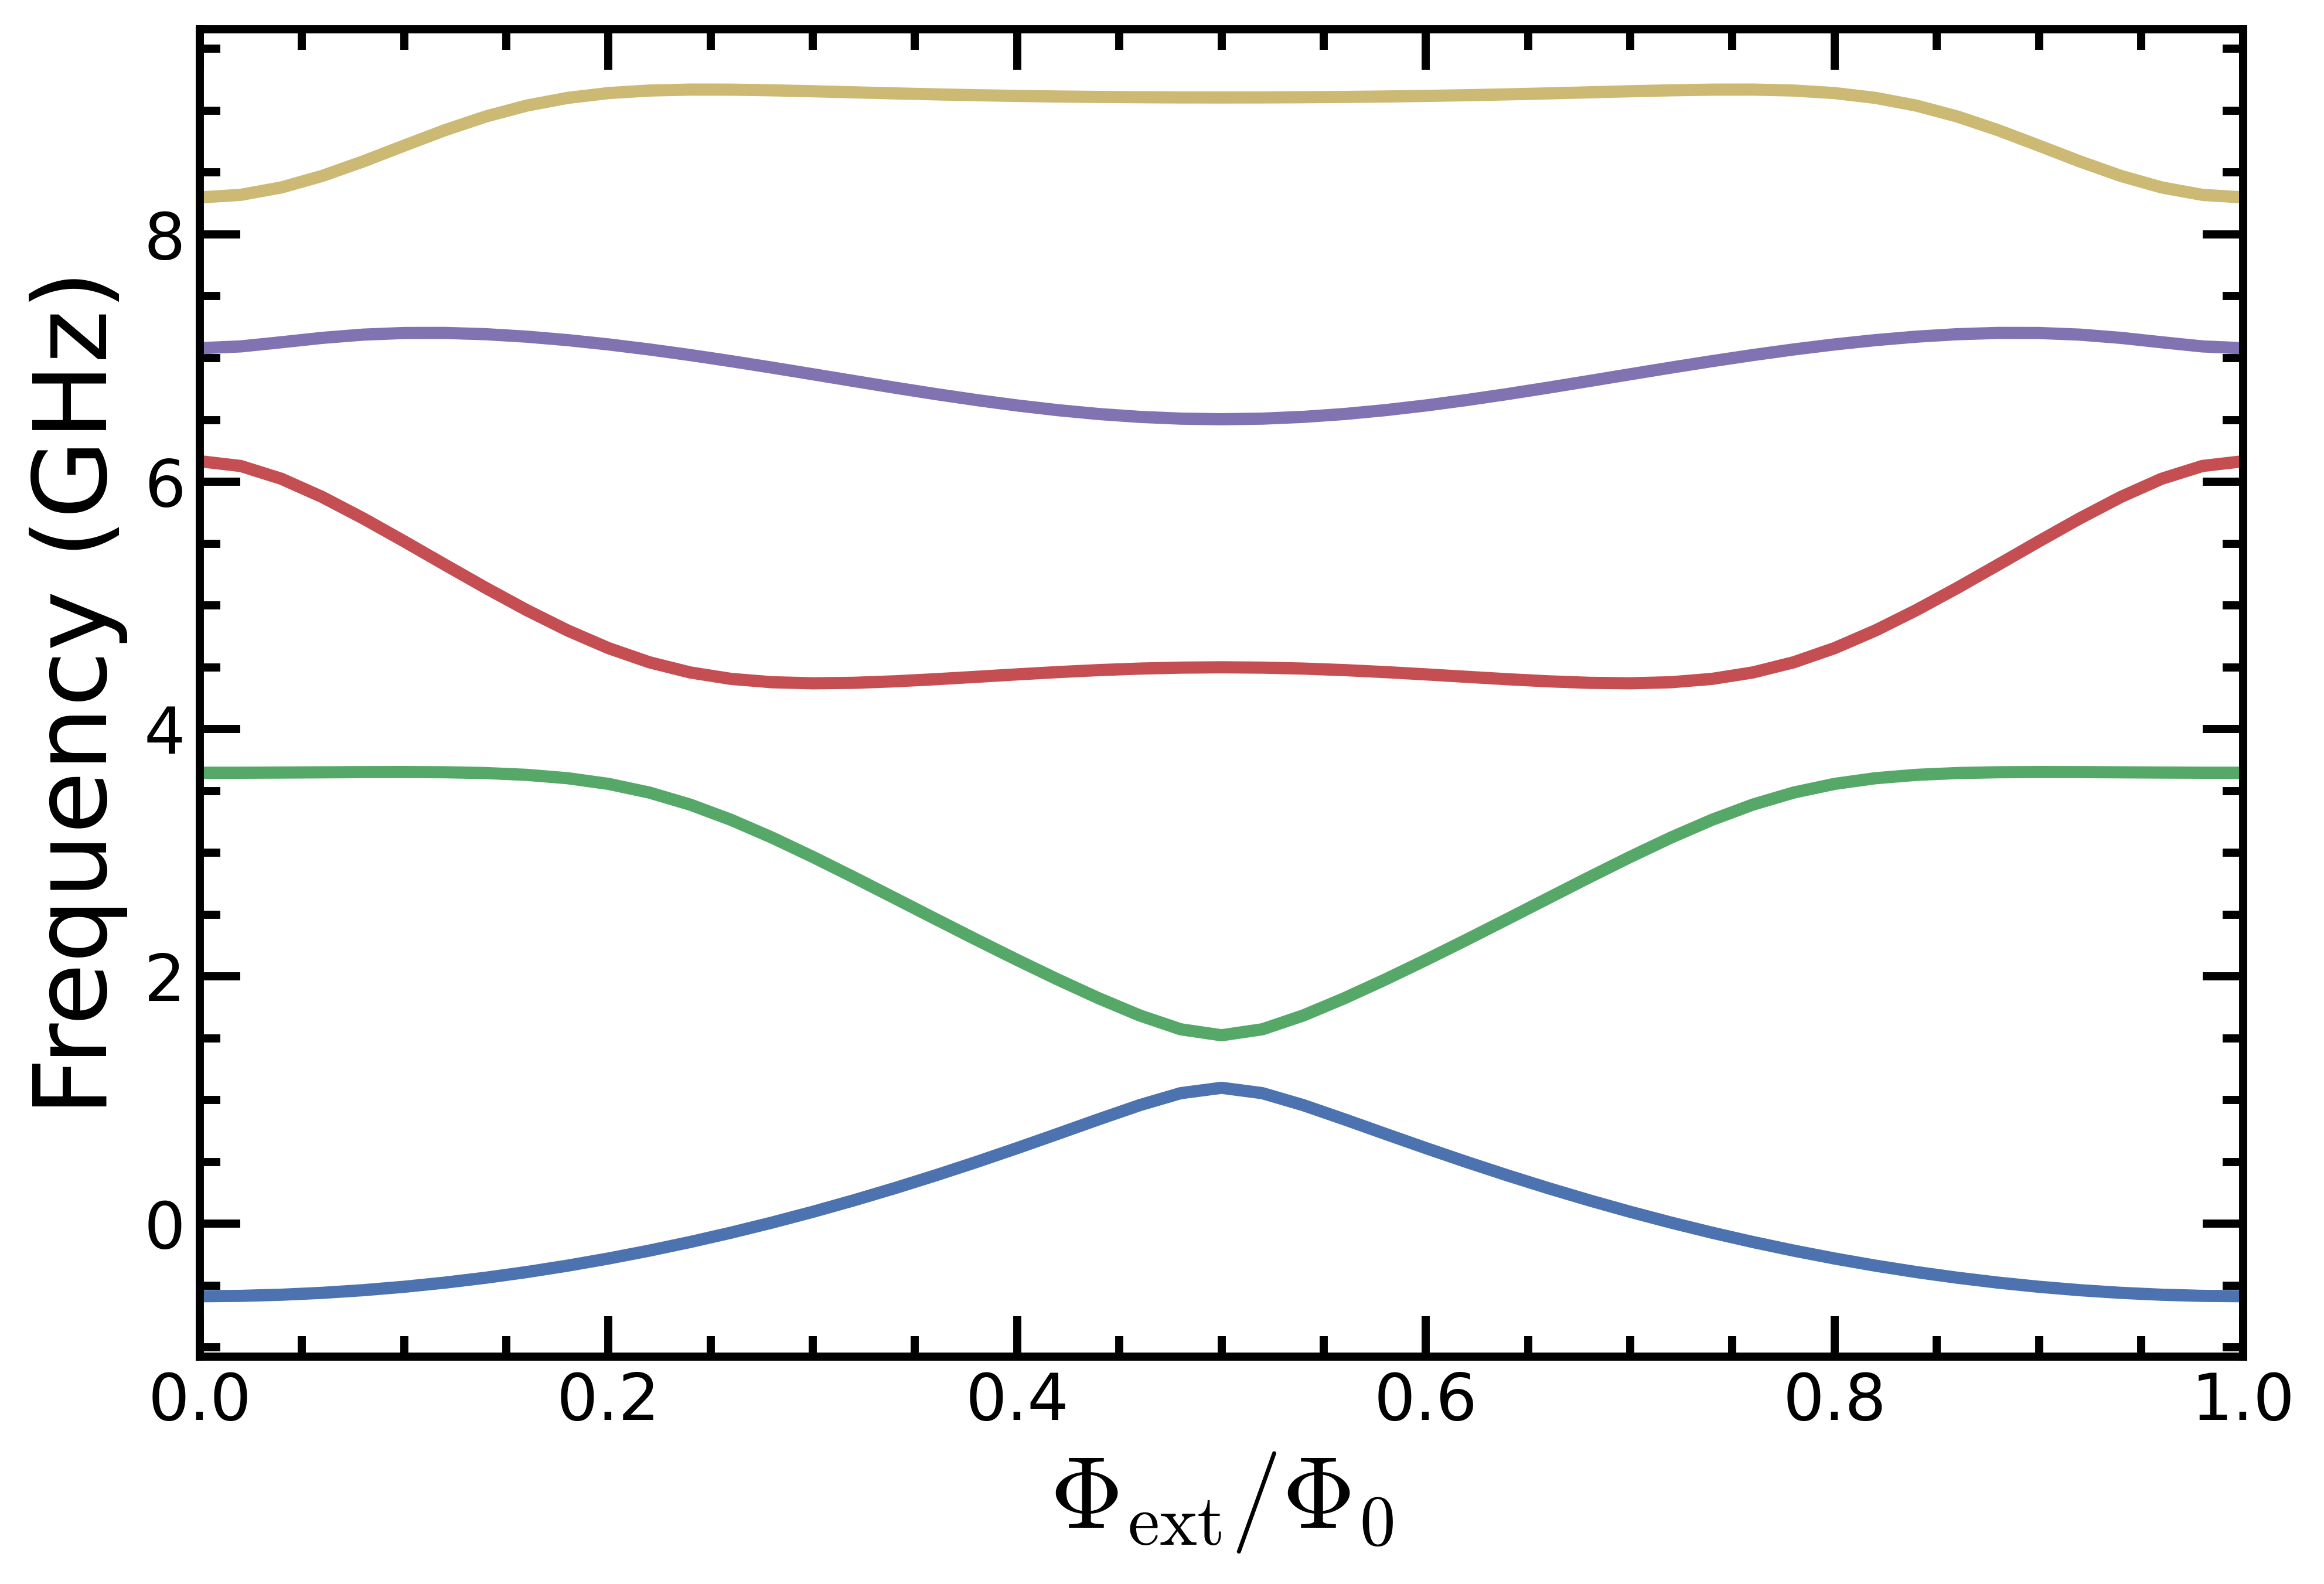

In [35]:
plt.figure(figsize = [9,6])
plt.xlim([phi_ext[0]/(2*np.pi), phi_ext[-1]/(2*np.pi)])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num,2):
    plt.plot(phi_ext/(2*np.pi), energies[:,idx])

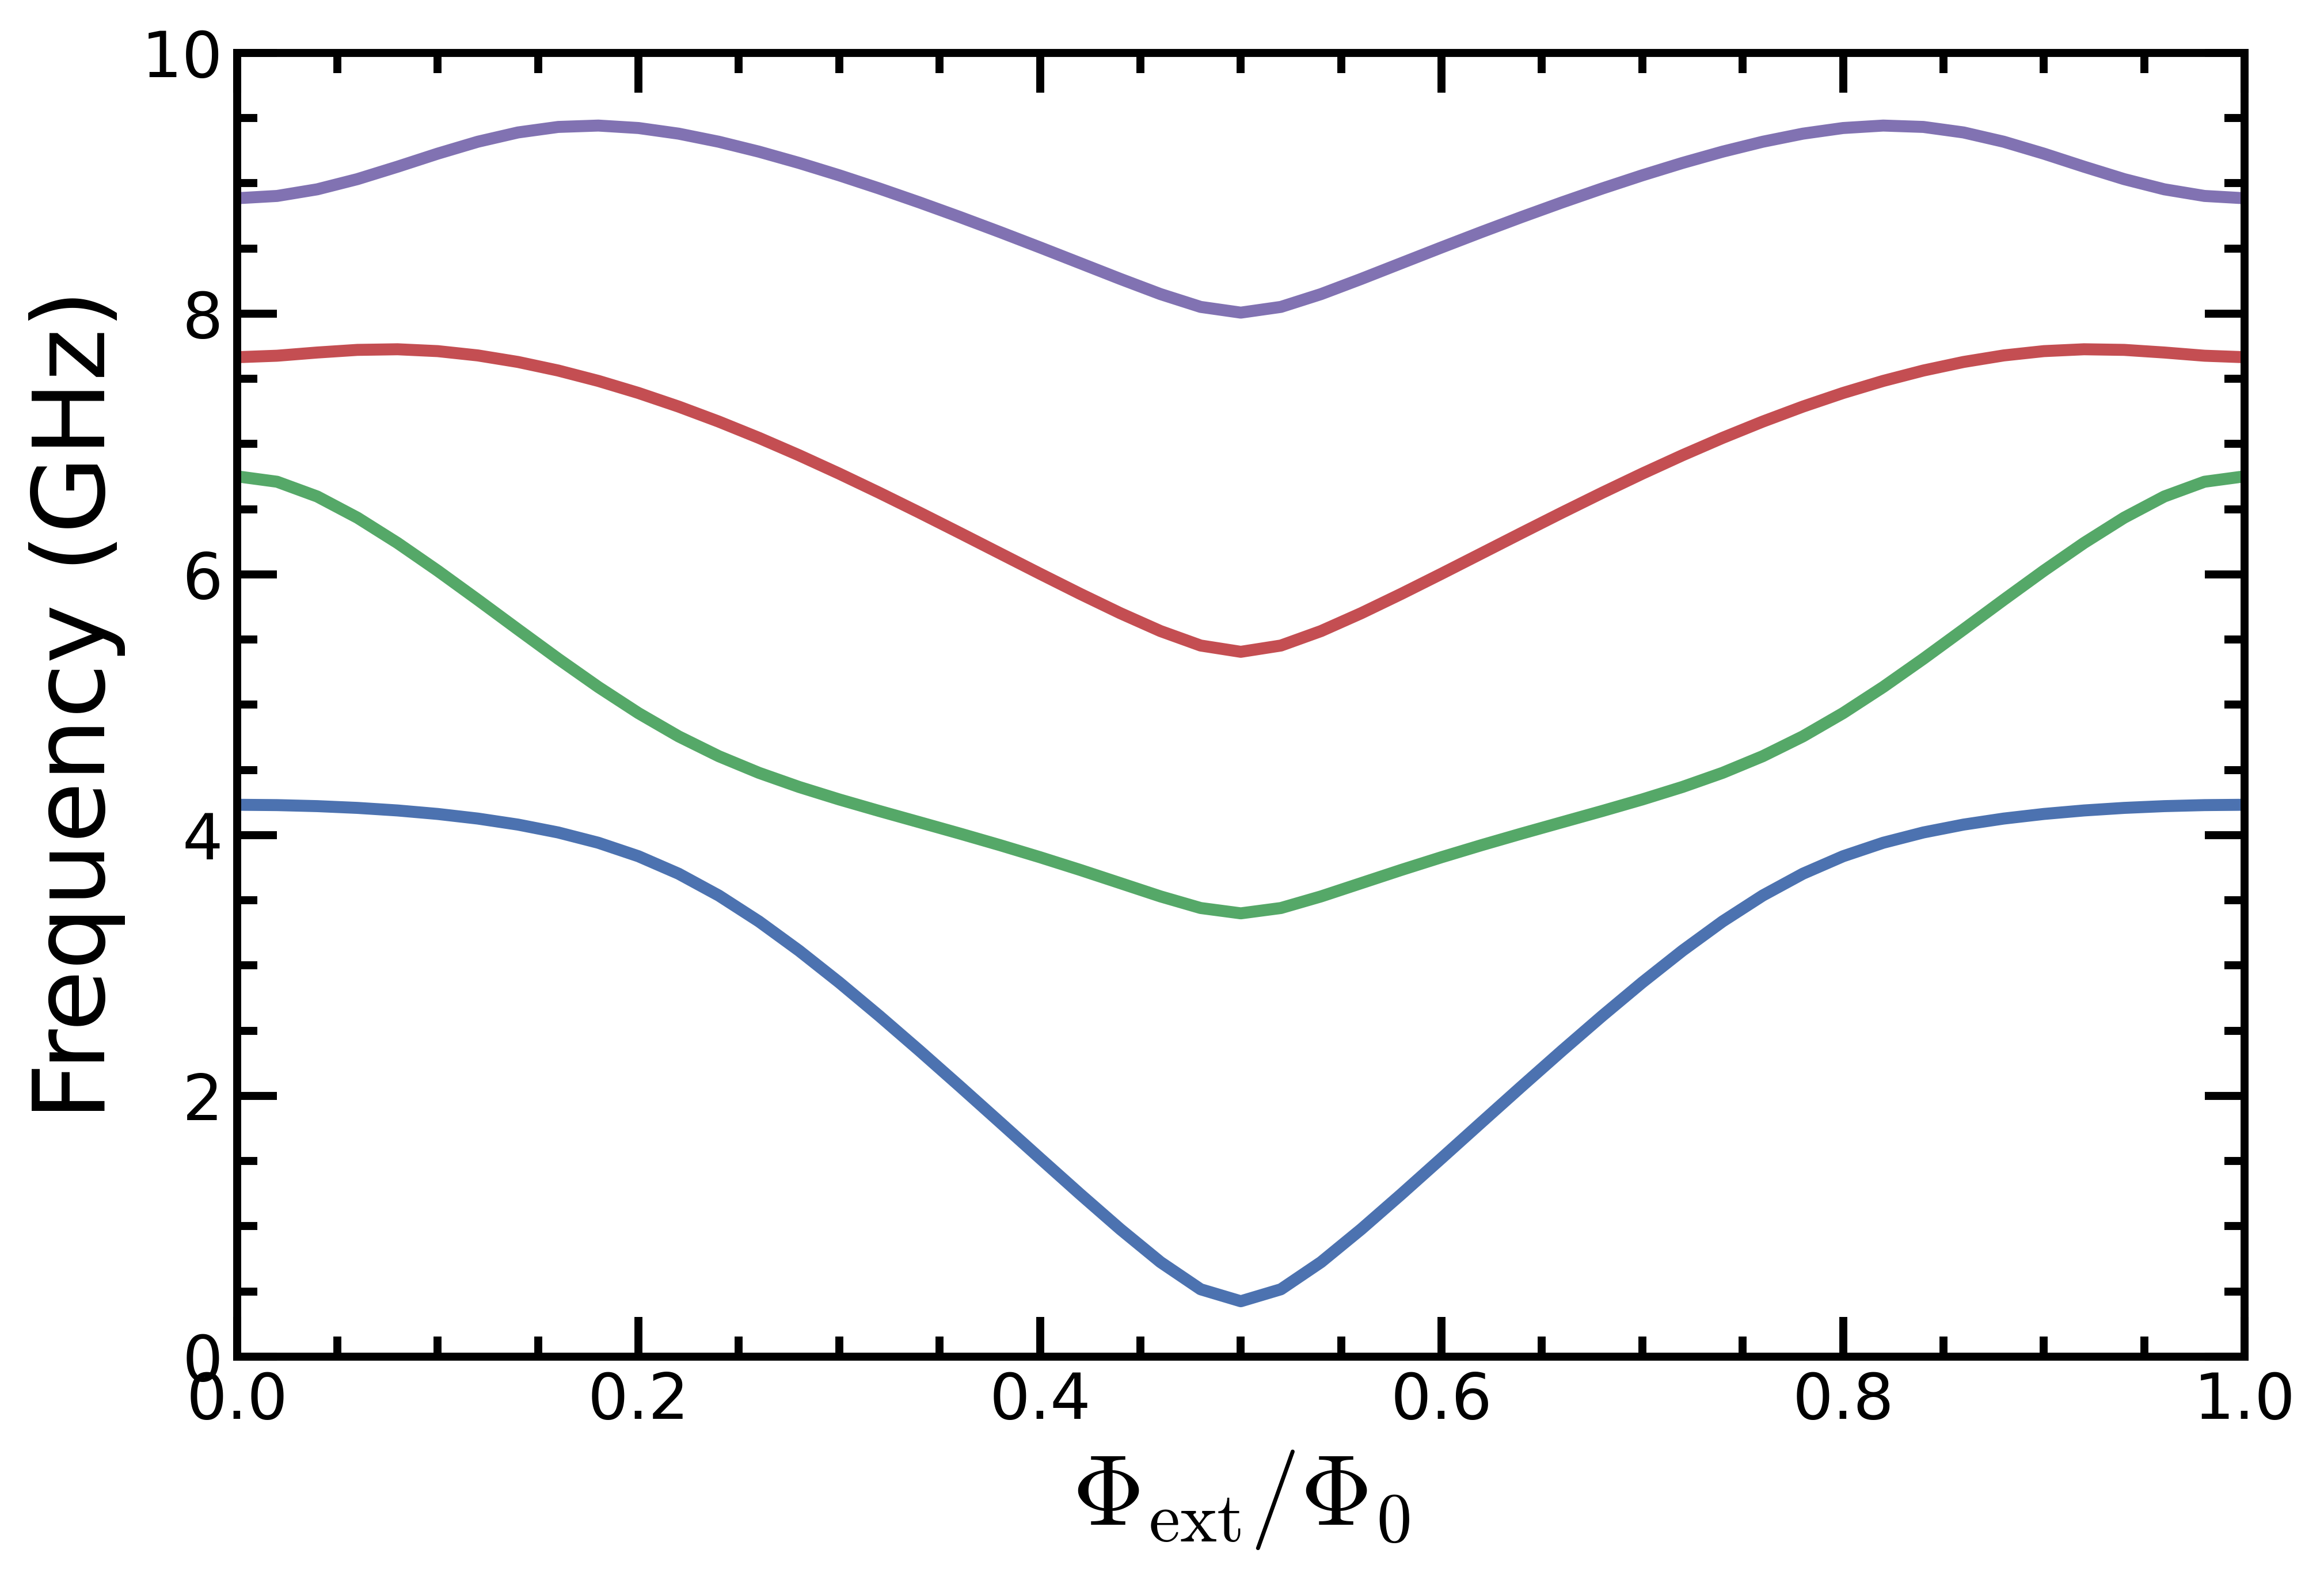

In [36]:
plt.figure(figsize = [9,6])
plt.xlim([phi_ext[0]/(2*np.pi), phi_ext[-1]/(2*np.pi)])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(2,level_num,2):
    plt.plot(phi_ext/(2*np.pi), energies[:,idx]- energies[:,0])    